<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/Copy_of_Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Optimización de flujo de alimentación $F_{in}$

Autor: Juan Manuel Gutiérrez García

Afiliación: Instituto Tecnológico de Morelia

Fecha: enero 2021

# Resumen

En el siguiente cuaderno describimos  la optimización de un biorreactor tipo lote-alimentado. En el proceso nos interesa maximizar la cantidad de biomasa generada al final de la fermentación. Se considera un flujo variable en la alimentación y una restricción en el volumen del biorreactor. El problema consiste en  encontrar el perfil de alimentación óptimo que nos permita maximizar la producción de biomasa en la fermentación. El análisis de hace con los parámetros óptimos obtenidos con datos de las levaduras *Isstchenkia terrícola*, *Kluyveromyces marxianus*, *Pichia kluyveri*, *Zygosaccharomyces bailii* y *Zygosaccharomyces rouxi* 

# Modelo con restricción de volumen

Las ecuaciones diferenciales que describen el proceso que se estudia son 

$$
\begin{aligned}
\frac{dV}{dt} &= F_{in} \\
\frac{dx}{dt} &= r_x - \frac{F_{in}}{V} x \\
\frac{ds}{dt} &= \frac{F_{in}}{V} (s_f - s) -\frac{1}{Y_{xs}}r_x \\
\frac{dp}{dt} &= Y_{px}r_x - \frac{F_{in}}{V} p
\end{aligned}
$$
Siendo

$$r_x = \mu_{max} \left( \frac{s}{k_s + s + k_i s^2} \right) x $$


# Establecer función objetivo

El problema de optimización aquí es maximizar la cantidad de biomasa al final de la fermentación. Por tanto, la función objetivo se puede formular de la siguiente manera:

$$max_{F_{in}(t)}\ J = x(t_f)V(t_f)$$
La optimización está sujeta a las restricciones

$$ 0 < F_{in}(t) < 2\ L/h$$
$$V(t_f) \leq 200\ L$$

## Parámetros del algoritmo genético

Para el correcto funcionamiento del algoritmo genético usando la función ga() es necesario establecer un valor adecuado de los parámetros popSize, pcrossover, pmutation, elitism y maxiter. Además se deben establecer el rango de búsqueda para el parámetro a optimizar

Tabla 1. Valores de parámetros usados en la optimización

|parámetro|	valor|
|:---:|:---:|
|tamaño de población (Fe constante)|	10|
|tamaño de población (Fe variable)|	50|
|probabilidad de cruzamiento|	0.8|
|probabilidad de mutación|	0.1|
|elitismo|	2|
|número de generaciones (Fe constante)|	10|
|número de generaciones (Fe variable)|	1000|

\\
Tabla 2. Rango de búsqueda de $F_{e}$

|parámetro|	mínimo|	máximo|
|:---:|:---:|:---:|
|$F{e} $ (L/h)|	0|	2|

Tabla 3. Parámetros de operación usados durante el análisis


|parámetro| valor|
|:---:|:---:|
$s_f$ | 50 g/L
$V_{lim}$ | 200 L
$t_f$ | 100 h
$x_0$ | 0.2 g/L
$s_0$ | 40 g/L
$p_0$ | 0 g/L
$V_0$ | 10 L

Tabla 4. Parámetros cinéticos de las cinco levaduras

|parámetro| IT | KM | PK | ZB | ZR | 	
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\mu_{max}$ (1/h)|2.410|2.308|2.291|2.021|1.465
|$k_s$ (g/L)|311.651|342.040|333.910|347.062|362.378
|$k_i$ (L/g)|0.190|0.269|0.230|0.272|0.601
|$Y_{xs}$|0.089|0.066|0.0850|0.0564|0.193
|$Y_{px}$|8.577|9.552|5.044|10.397|3.266
              

Para la optimización del flujo de alimentación se emplean los parámetros óptimos de cada levadura

In [3]:
# parámetros cinéticos óptimos de IT 
# ki = 0.190
p_it <- c(mu_max = 2.4102375, ks = 311.6519179, ki = 0.8, Yxs = 0.0897973, Ypx = 8.5770722)
# parámetros cinéticos óptimos de KM
# ki = 0.269
p_km <- c(mu_max = 2.30834, ks = 342.0408, ki = 0.8, Yxs = 0.06644916, Ypx = 9.552475)
# parámetros cinéticos óptimos de PK 
# ki = 0.230
p_pk <- c(mu_max = 2.291, ks = 333.910, ki = 0.8, Yxs = 0.0850, Ypx = 5.044)
# parámetros cinéticos óptimos de ZB 
# ki = 0.272
p_zb <- c(mu_max = 2.021993, ks = 347.0626, ki = 0.8, Yxs = 0.05646044, Ypx =  10.39769)
# parámetros cinéticos óptimos de ZR
# ki = 0.601
p_zr <- c(mu_max = 1.465,ks = 362.378, ki = 0.8, Yxs = 0.193, Ypx = 3.266)

In [4]:
# instalar paquetes 
install.packages("deSolve")
install.packages("GA")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’, ‘RcppArmadillo’




In [5]:
# cargar librerías
library(deSolve)
library(ggplot2)
library(GA)

Loading required package: foreach

Loading required package: iterators

Package 'GA' version 3.2.1
Type 'citation("GA")' for citing this R package in publications.


Attaching package: ‘GA’


The following object is masked from ‘package:utils’:

    de




In [51]:
# @title establecer modelo
model <- function(times, state, parms, Fe) {
        with(as.list(c(state,parms)), {
                
                # velocidad de crecimiento de biomasa
                rx = mu_max*s/(ks + s + ki*s^2)*x
                
                # velocidad de consumo de sustrato
                rs = (1/Yxs)*rx

                # velocidad de generación de producto
                rp = Ypx*rx
                
                # balance de material global 
                dVdt = Fe 
                
                # balance de materia para sustrato
                dsdt = Fe/V*(sf - s) - rs
                
                # balance de materia para biomasa
                dxdt = - Fe/V*x + rx
                
                # balance de materia para el producto
                dpdt = - Fe/V*p + rp

                return(list(c(dVdt, dsdt, dxdt, dpdt), Fe = Fe))
        })
}

In [45]:
# tiempo de integración para la optimización
tf <- 100
times <- seq(0,tf, len = 100)

In [52]:
# establecer parámetros arbitrarios para probar las funciones 
p <- c(mu_max = 1.2, ks = 280,  ki = 0.3, Yxs = 0.2, Ypx = 4)
# establecer valor de parámetros de operación
Fe = 1 # L/h, flujo de alimentación
Vl = 200 # L, valor máximo de volumen en el biorreactor
sf = 50 # g/L, concentración de sustrato en la alimentación

In [53]:
# condiciones iniciales para la optimización
s <- c(V = 10.0, s = 40, x = 0.2, p = 0)

In [54]:
# realizar simulación
out <- ode(func = model, y = s, times = times, parms = p, Fe = Fe)
# guardar resultados 
out <- as.data.frame(out)
tail(out)

time      V        s        x        p        Fe
95   94.94949 104.9495 23.96337 5.035814 20.06703 1 
96   95.95960 105.9596 22.65396 5.299331 21.12182 1 
97   96.96970 106.9697 21.30022 5.571683 22.21194 1 
98   97.97980 107.9798 19.91048 5.851206 23.33074 1 
99   98.98990 108.9899 18.49583 6.135680 24.46932 1 
100 100.00000 110.0000 17.07027 6.422310 25.61651 1

In [55]:
# @title función para graficar los datos 
plot_data <- function(data) {
    show(
            # mostrar biomasa
    ggplot(data = data, aes(x = times, y = x))+
        geom_line(lwd = 2) +
        xlab("Tiempo (h)") +
        ylab("Biomasa (g/L)") +
        theme_bw() +
        theme( 
                plot.title = element_text(size=20),
                axis.text = element_text(size=20),
                axis.title = element_text(size=20))
    )

    

    # mostrar sustrato
    show(
        ggplot(data = data, aes(x = times, y = s))+
        geom_line(lwd = 2)+
        xlab("Tiempo (h)")+
        ylab("Sustrato (g/L)")+
        theme_bw() +
        theme( 
                    plot.title = element_text(size=20),
                    axis.text = element_text(size=20),
                    axis.title = element_text(size=20))
    )

    # mostrar etanol
    show(    ggplot(data = data, aes(x = times, y = p))+
        geom_line(lwd = 2)+
        xlab("Tiempo (h)")+
        ylab("Etanol (g/L)")+
        theme_bw() +
        theme( 
                    plot.title = element_text(size=20),
                    axis.text = element_text(size=20),
                    axis.title = element_text(size=20)))

    # mostrar volumen
    show(
        ggplot(data = data, aes(x = times, y = V))+
        geom_line(lwd = 2) +
        geom_hline(yintercept = Vl, lty = 2, col = "blue", lwd = 2) +
        xlab("Tiempo (h)") +
        ylab("Volumen (L)") +
        theme_bw() +
        theme( 
                    plot.title = element_text(size=20),
                    axis.text = element_text(size=20),
                    axis.title = element_text(size=20))
    )

    # mostrar Fin
    show(
        ggplot(data = data, aes(x = times, y = Fe))+
        geom_line(lwd = 2)+
        xlab("Tiempo (h)")+
        ylab(expression(paste(F[e], " (L/h)")))+
        theme_bw() +
        theme( 
                    plot.title = element_text(size=20),
                    axis.text = element_text(size=20),
                    axis.title = element_text(size=20))
    )
}

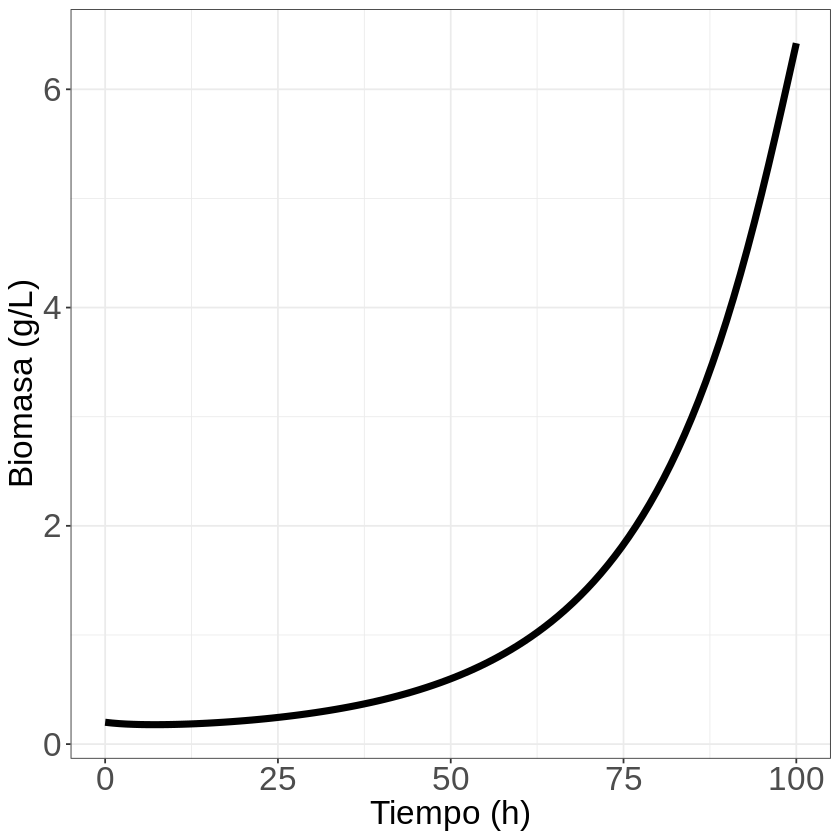

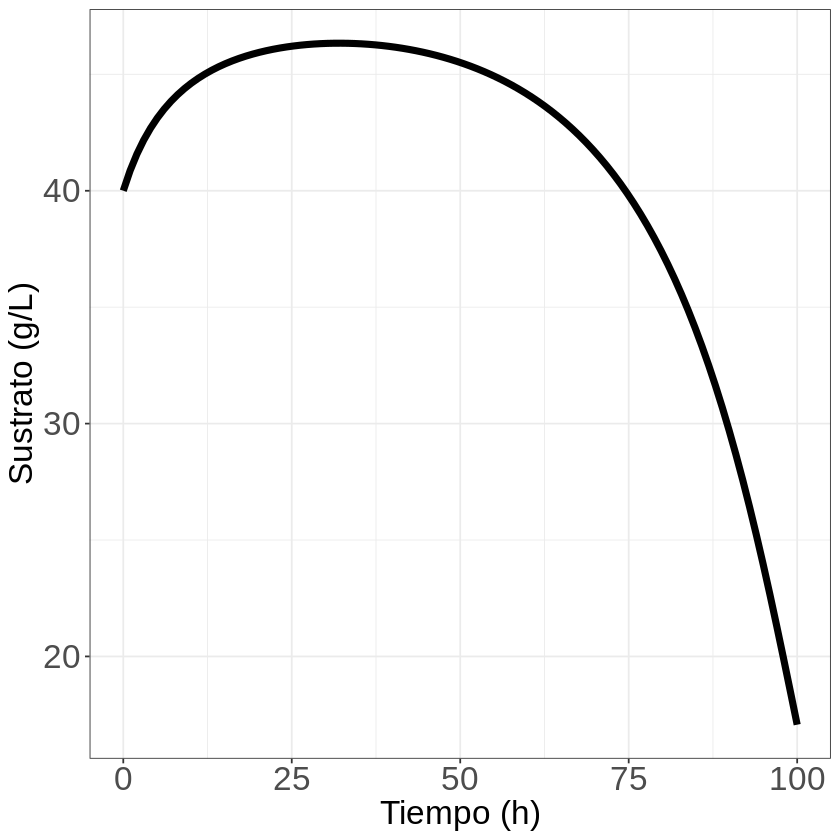

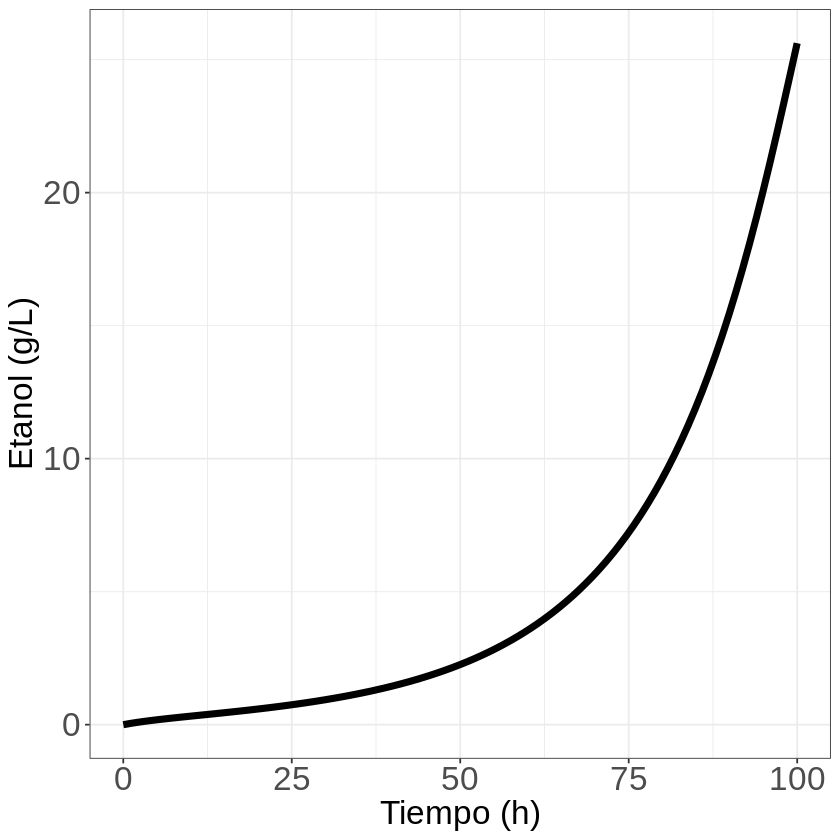

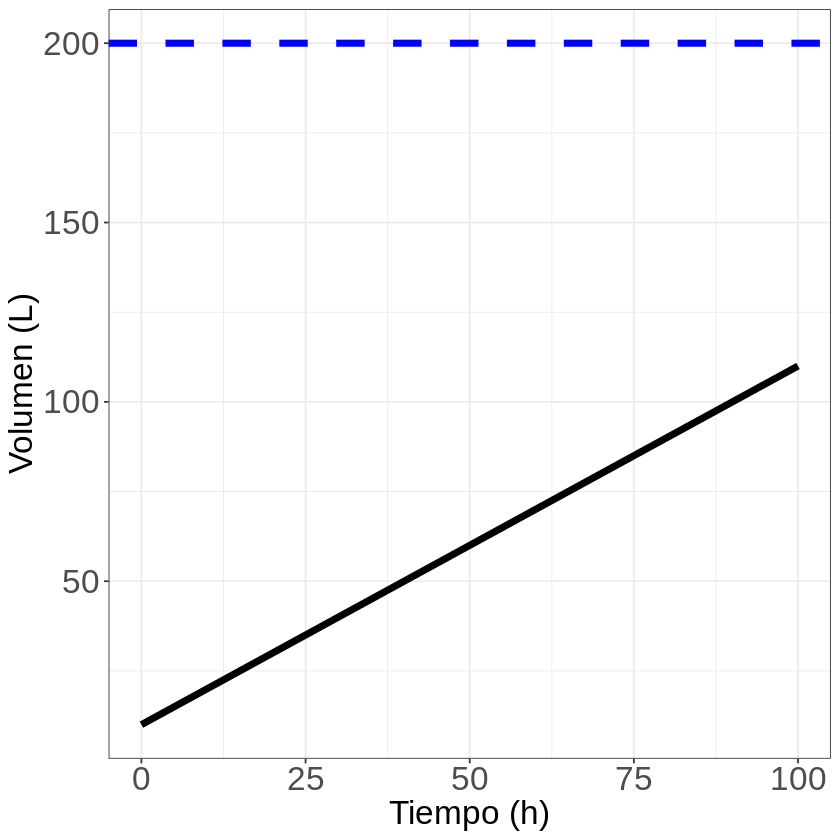

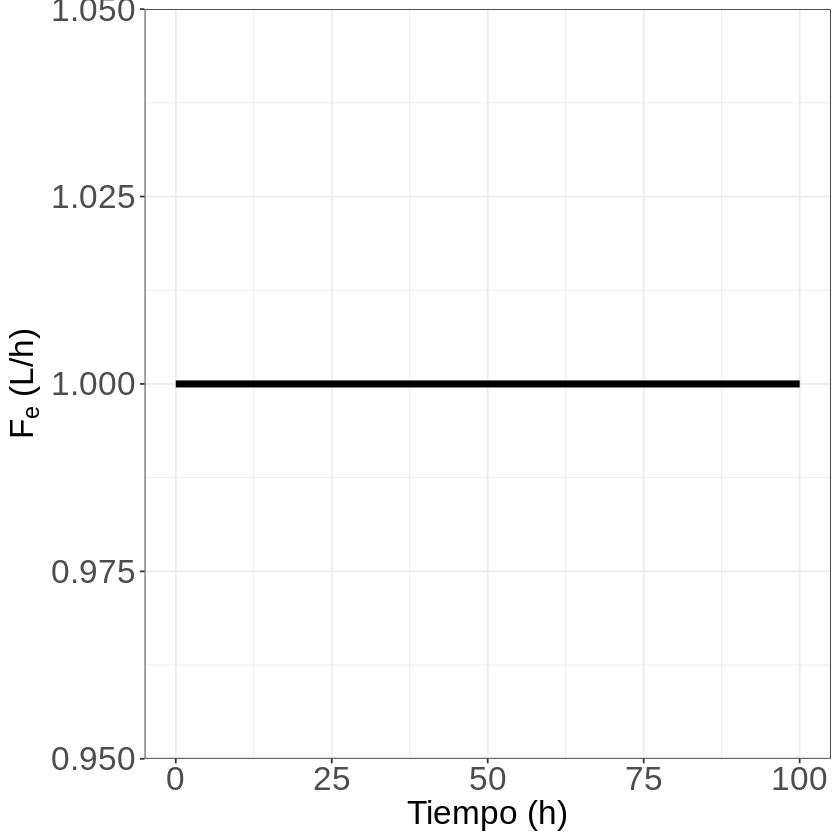

In [56]:
# graficar resultados 
plot_data(out)

In [13]:
#@title función para obtener la biomasa final (función a optimizar)
end_biomass <- function(times, state, parms, Fe) {

        # simular proceso
        out <- ode(func = model, y = s, times = times, 
        parms = parms, Fe = Fe)

        # última observación en la simulación
        out <- as.data.frame(out)
        m <- nrow(out)

        # valor de estado al final de la simulación
        end_V <- out$V[m]
        end_x <- out$x[m]
        
        end_mx <- end_V*end_x
        
        return(list(end_x = end_x, end_V = end_V, end_mx = end_mx))
}

In [57]:
end_biomass(times = times, state = s, parms = p, Fe = Fe)

$end_x
[1] 6.42231

$end_V
[1] 110

$end_mx
[1] 706.4541

In [58]:
#@title función para obtener la biomasa final para diferentes valores de Fe 
end_biomass2 <- function(times, state, parms, Fe) {
        
        # vectores para guardar los valores finales
        n <- length(Fe)
        end_x <- numeric(length = n)
        end_V <- numeric(length = n)
        end_mx <- numeric(length = n)
        # ciclo for para evaluar todos los valores en Fe
        for (i in 1:n) {
                
                # obtener valores finales final de mx
                out <- end_biomass(times = times,state = state,
                parms = parms, Fe = Fe[i])
                
                # guardar mx final para Fe[i]
                end_x[i] <- out$end_x
                end_V[i] <- out$end_V
                end_mx[i] <- out$end_mx
                
        }
        
        return(list(end_x = end_x, end_V = end_V, end_mx = end_mx))
}

In [59]:
Fe = seq(0,2,len = length(times))

end_biomass2(times = times, state = s, parms = p, Fe = Fe)

$end_x
  [1] 8.198170 8.406466 8.556831 8.670147 8.758266 8.828382 8.885086 8.931420
  [9] 8.969457 9.000632 9.025949 9.046104 9.061577 9.072675 9.079586 9.082395
 [17] 9.081113 9.075687 9.066023 9.051980 9.033399 9.010097 8.981883 8.948568
 [25] 8.909962 8.865906 8.816246 8.760873 8.699702 8.632733 8.559992 8.481541
 [33] 8.397536 8.308188 8.213765 8.114593 8.011031 7.903572 7.792610 7.678656
 [41] 7.562210 7.443784 7.323882 7.202992 7.081582 6.960091 6.838920 6.718399
 [49] 6.598976 6.480819 6.364218 6.249387 6.136500 6.025704 5.917113 5.810813
 [57] 5.706869 5.605322 5.506153 5.409504 5.315233 5.223370 5.133887 5.046750
 [65] 4.961920 4.879351 4.798994 4.720795 4.644701 4.570656 4.498602 4.428483
 [73] 4.360227 4.293822 4.229166 4.166220 4.104928 4.045239 3.987099 3.930460
 [81] 3.875272 3.821487 3.769059 3.717944 3.668099 3.619482 3.572052 3.525771
 [89] 3.480602 3.436508 3.393455 3.351408 3.310337 3.270209 3.230996 3.192667
 [97] 3.155195 3.118554 3.082717 3.047660

$end_V
  [1]  10.00000  12.02020  14.04040  16.06061  18.08081  20.10101  22.12121
  [8]  24.14141  26.16162  28.18182  30.20202  32.22222  34.24242  36.26263
 [15]  38.28283  40.30303  42.32323  44.34343  46.36364  48.38384  50.40404
 [22]  52.42424  54.44444  56.46465  58.48485  60.50505  62.52525  64.54545
 [29]  66.56566  68.58586  70.60606  72.62626  74.64646  76.66667  78.68687
 [36]  80.70707  82.72727  84.74747  86.76768  88.78788  90.80808  92.82828
 [43]  94.84848  96.86869  98.88889 100.90909 102.92929 104.94949 106.96970
 [50] 108.98990 111.01010 113.03030 115.05051 117.07071 119.09091 121.11111
 [57] 123.13131 125.15152 127.17172 129.19192 131.21212 133.23232 135.25253
 [64] 137.27273 139.29293 141.31313 143.33333 145.35354 147.37374 149.39394
 [71] 151.41414 153.43434 155.45455 157.47475 159.49495 161.51515 163.53535
 [78] 165.55556 167.57576 169.59596 171.61616 173.63636 175.65657 177.67677
 [85] 179.69697 181.71717 183.73737 185.75758 187.77778 189.79798 191.81818
 [92] 193.83838 195.85859 197.87879 199.89899 201.91919 203.93939 205.95960
 [99] 207.97980 210.00000

$end_mx
  [1]  81.9817 101.0474 120.1414 139.2478 158.3565 177.4594 196.5489 215.6171
  [9] 234.6555 253.6542 272.6019 291.4856 310.2904 328.9990 347.5922 366.0481
 [17] 384.3421 402.4471 420.3338 437.9696 455.3198 472.3475 489.0136 505.2777
 [25] 521.0978 536.4321 551.2380 565.4745 579.1013 592.0834 604.3873 615.9826
 [33] 626.8464 636.9611 646.3154 654.9051 662.7307 669.8078 676.1467 681.7715
 [41] 686.7098 690.9937 694.6591 697.7444 700.2898 702.3364 703.9252 705.0926
 [49] 705.8905 706.3438 706.4925 706.3701 706.0074 705.4334 704.6743 703.7541
 [57] 702.6943 701.5145 700.2270 698.8642 697.4231 695.9217 694.3711 692.7812
 [65] 691.1604 689.5164 687.8558 686.1843 684.5070 682.8283 681.1520 679.4815
 [73] 677.8171 676.1686 674.5307 672.9076 671.3009 669.7117 668.1412 666.5901
 [81] 665.0593 663.5491 662.0599 660.5922 659.1462 657.7219 656.3194 654.9387
 [89] 653.5797 652.2423 650.9263 649.6316 648.3579 647.1050 645.8727 644.6607
 [97] 643.4686 642.2960 641.1429 640.0087

# Optimización manteniendo $F_{in}$ constante

In [60]:
# valores de Fin que vamos a investigar
print(Fe)

  [1] 0.00000000 0.02020202 0.04040404 0.06060606 0.08080808 0.10101010
  [7] 0.12121212 0.14141414 0.16161616 0.18181818 0.20202020 0.22222222
 [13] 0.24242424 0.26262626 0.28282828 0.30303030 0.32323232 0.34343434
 [19] 0.36363636 0.38383838 0.40404040 0.42424242 0.44444444 0.46464646
 [25] 0.48484848 0.50505051 0.52525253 0.54545455 0.56565657 0.58585859
 [31] 0.60606061 0.62626263 0.64646465 0.66666667 0.68686869 0.70707071
 [37] 0.72727273 0.74747475 0.76767677 0.78787879 0.80808081 0.82828283
 [43] 0.84848485 0.86868687 0.88888889 0.90909091 0.92929293 0.94949495
 [49] 0.96969697 0.98989899 1.01010101 1.03030303 1.05050505 1.07070707
 [55] 1.09090909 1.11111111 1.13131313 1.15151515 1.17171717 1.19191919
 [61] 1.21212121 1.23232323 1.25252525 1.27272727 1.29292929 1.31313131
 [67] 1.33333333 1.35353535 1.37373737 1.39393939 1.41414141 1.43434343
 [73] 1.45454545 1.47474747 1.49494949 1.51515152 1.53535354 1.55555556
 [79] 1.57575758 1.59595960 1.61616162 1.63636364 1.65656566 1.6

In [61]:
# @title función fitness para encontrar el flujo óptimo Fin de alimentación al biorreactor 
fitness1 <- function(x, times, state, parms) {
        # end_biomass() regresa el valor de la biomasa final
        # para el flujo de alimentación Fin 
        out <- end_biomass(times = times, 
        state = state,
        parms = parms, 
        Fe = x) # x es el flujo de alimentación Fin
        
        end_mx <- out$end_mx
        return(end_mx)
}

In [62]:
# probar la función con Fin = 1
fitness1(x = 1, times = times, state = s, parms = p)

[1] 706.4541

### Optimización de $F_e$ para *Isstchenkia terrícola*

In [63]:
# @title función para mostrar fitness
show_fitness <- function(times = times, state = s, parms = p, Fe = Fe){
    # obtener biomasa final para todos los Fin
    out <- end_biomass2(times = times, state = state, parms = parms, Fe = Fe)
    # mostrar función que se va a optimizar 
    par(mar = c(5,7,4,2) + 0.1)
    plot(Fe, out$end_mx, ylab = "Producción de biomasa (g)", xlab = expression(paste(F[e], " (L/h)")), 
        type = "l", col = 1, lwd = 3, cex.lab = 1.6, cex.axis = 1.5)
}

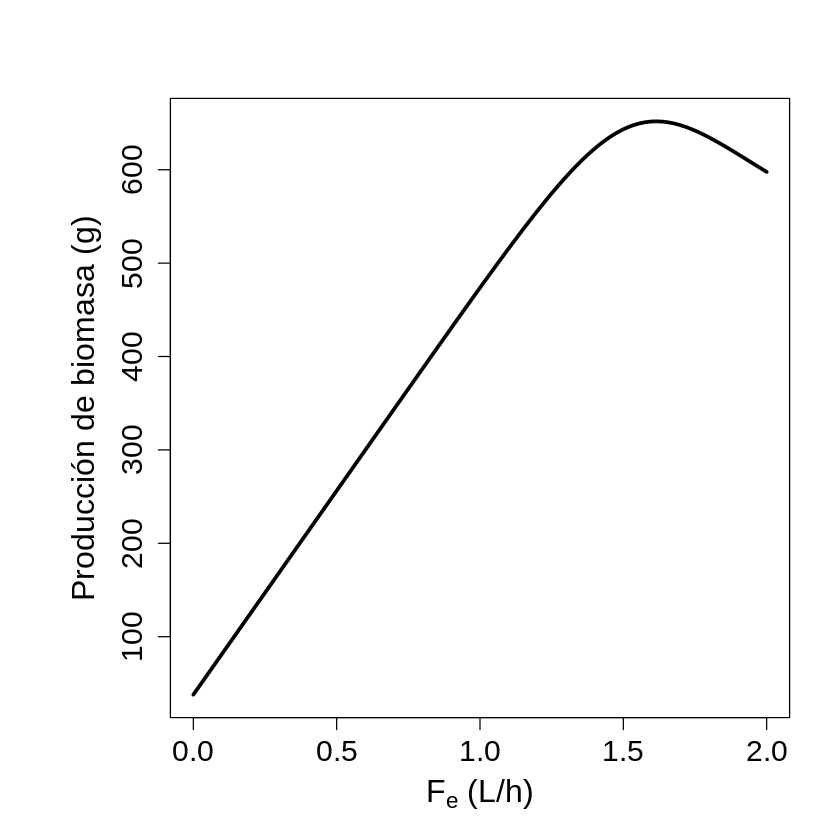

In [64]:
# mostrar función fitness evaluada para todos los Fin
show_fitness(times = times, state = s, parms = p_it, Fe = Fe)

In [65]:
#@title función para encontrar el flujo de alimentación óptimo
get_Fin_opt <- function(p, pop_size, generations) {
    time1 <- Sys.time()
    GA <- ga(type = "real-valued",
         fitness = fitness1,
         times= times,
         state = s,
         parms = p,
         lower = 0,
         upper = 2,
         maxiter = generations, 
         popSize = pop_size, 
         elitism = 2)
    time2 <- Sys.time()
    cat("tiempo de ejecución:",time2 - time1,"\n")
         return(GA)
}

In [149]:
#@title función para mostrar evolución del AG
show_GA_evol <- function(GA) {
    out <- plot(GA)
    show(
            ggplot(out) +
    geom_ribbon(aes(x = iter, ymin = median, ymax = max, 
                    colour = "mediana", fill = "mediana")) +
    geom_line(aes(x = iter, y = max, colour = "mejor"), lwd = 2) +
    geom_point(aes(x = iter, y = max, colour = "mejor"), cex = 2) +
    geom_line(aes(x = iter, y = mean, colour = "promedio"), lty = 2, lwd = 2) +
    geom_point(aes(x = iter, y = mean, colour = "promedio"), pch = 1, cex = 2) +
    xlab("Generación") +  ylab("Producción de biomasa (g)") +
    scale_colour_manual(breaks = c("mejor", "promedio", "mediana"),
                        values = c("green3", "dodgerblue3", adjustcolor("green3", alpha.f = 0.1))) +
    scale_fill_manual(breaks = "mediana",
                        values = adjustcolor("green3", alpha.f = 0.1)) +
    guides(fill = "none", 
            colour = guide_legend(override.aes = 
                                    list(fill = c(NA, NA, adjustcolor("green3", alpha.f = 0.1)),
                                        pch = c(19,1,NA)))) +
    theme_bw() +
    theme( 
        plot.title = element_text(size=25),
        axis.text = element_text(size=20),
        axis.title = element_text(size=20),
        legend.title = element_blank(),
        legend.text = element_text(size=20),
        legend.position = c(0.8, 0.50), 
        #legend.pos = "top",
        #legend.background = element_blank()
        legend.background = element_rect(fill=NA))
    )
}

In [67]:
#@title función para mostrar resultados de la optimización
show_results <- function(GA, parms) {
    # mostrar evolución del algoritmo
    show_GA_evol(GA)
    # valor Fin que genera la máxima producción de biomasa 
    cat("Fin_opt:", GA@solution," L/h\n")
    # maxima producción de biomasa que se obtiene
    cat("mx_opt:", GA@fitnessValue, "g\n")
    # mostrar resultados de la optimización
    show_fitness(times = times, state = s, parms = parms, Fe = Fe)
    abline(v = GA@solution, col="red", lwd = 3, lty = 2)
    abline(v = c(0,2), col="blue", lwd = 3, lty = 3)
    # simular con perfil óptimo
    out_opt <- ode(func = model, y = s, times = times,
     parms = parms, Fe = GA@solution)
    out_opt <- as.data.frame(out_opt)
    return(out_opt)
}

In [68]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_it_const <- get_Fin_opt(p_it, pop_size = pop_size_const, generations = generation_const)

tiempo de ejecución: 0.6955831 


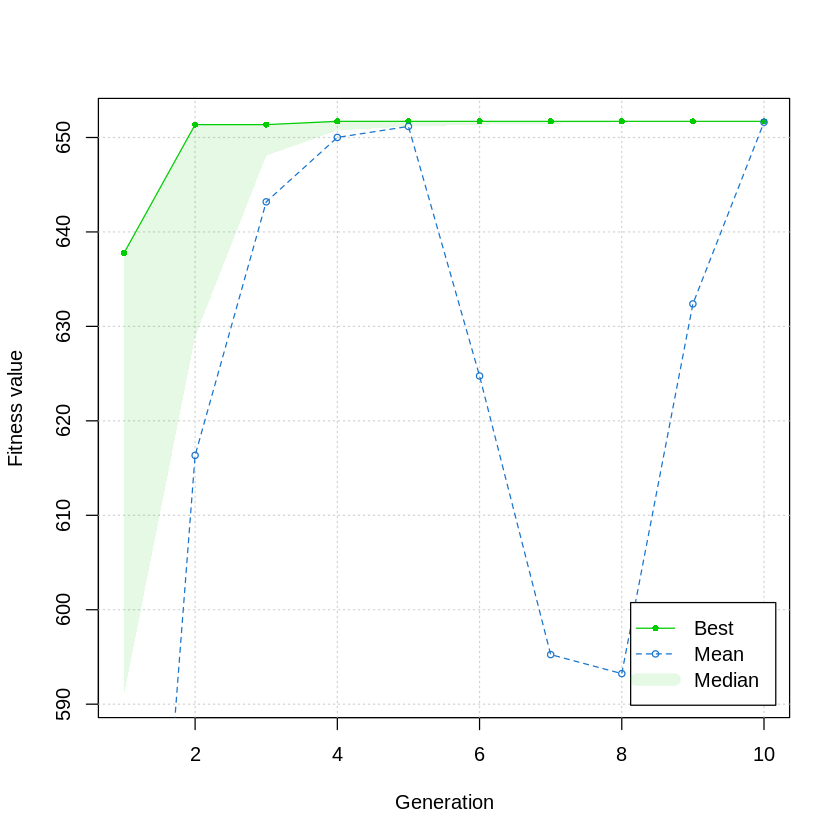

Fin_opt: 1.62926  L/h
mx_opt: 651.7111 g


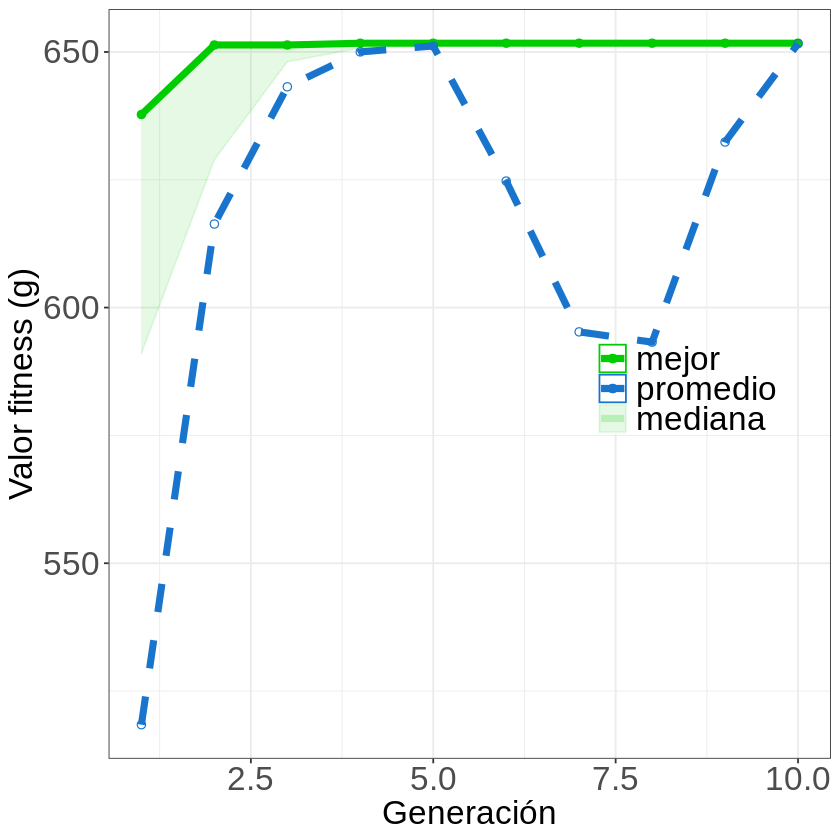

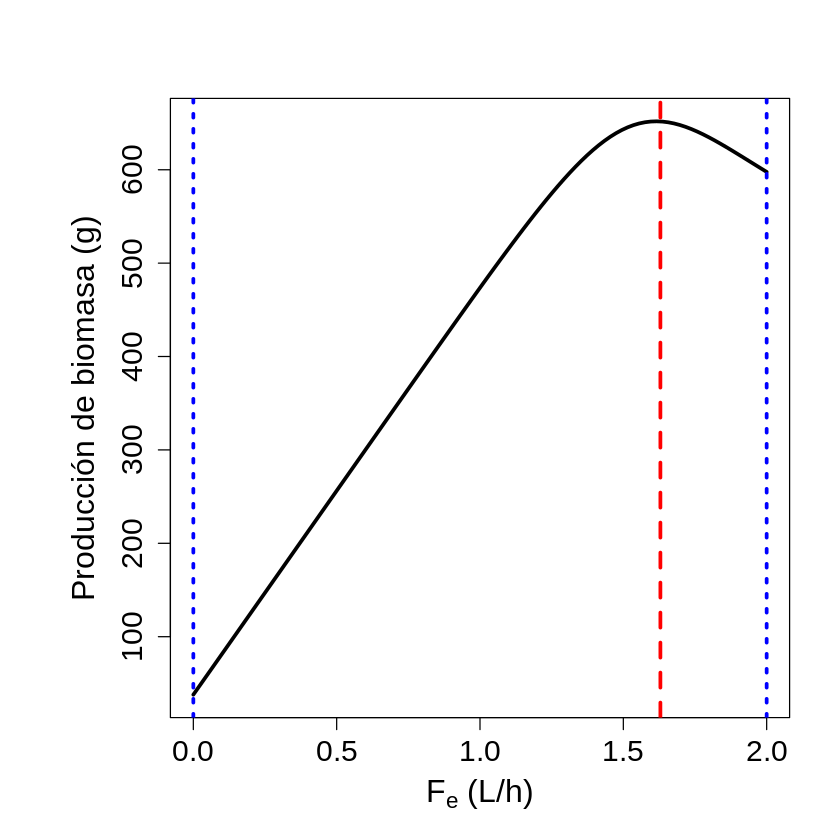

In [69]:
out_it_opt_const <- show_results(GA_it_const, p = p_it)

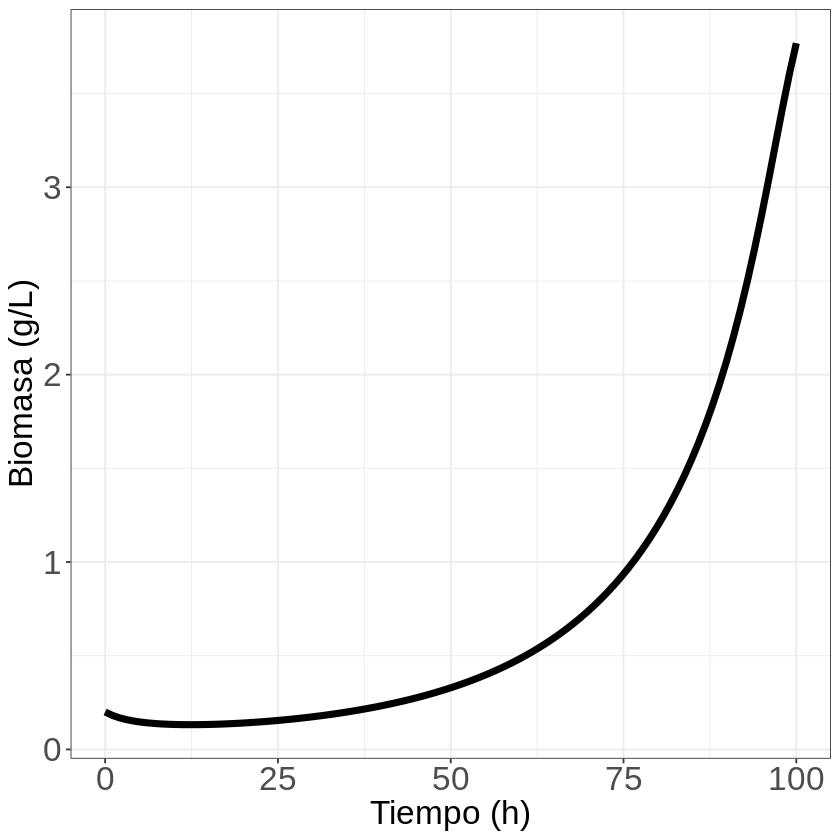

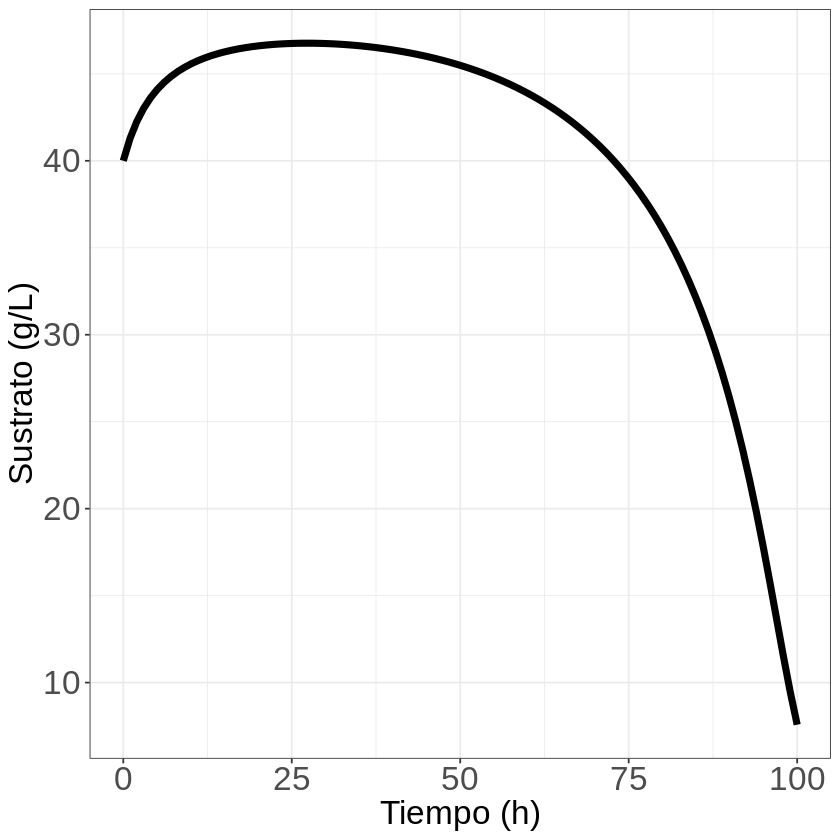

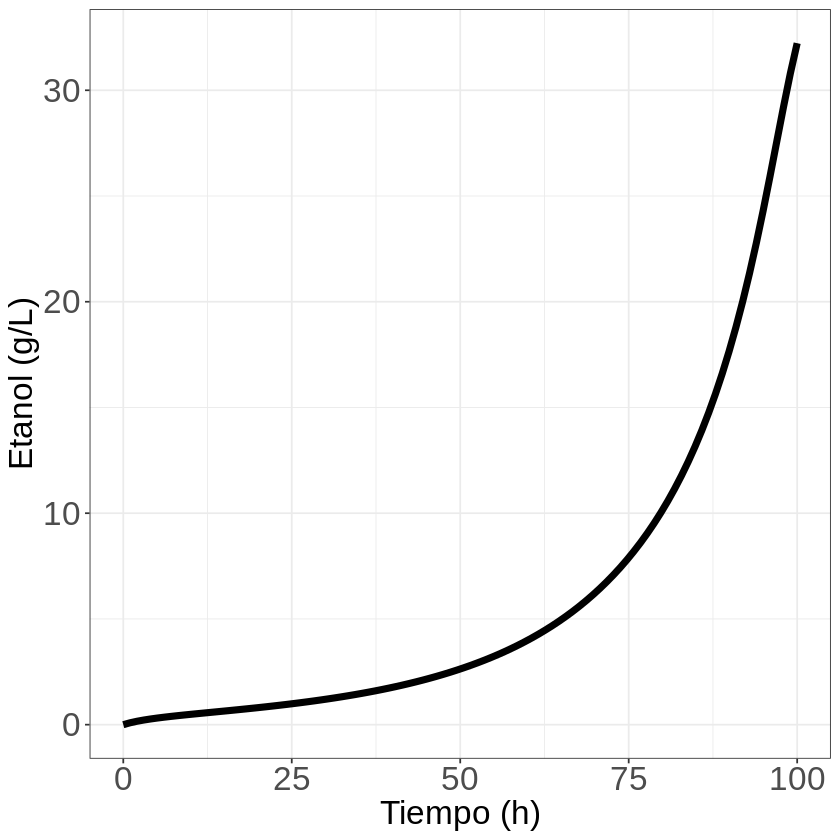

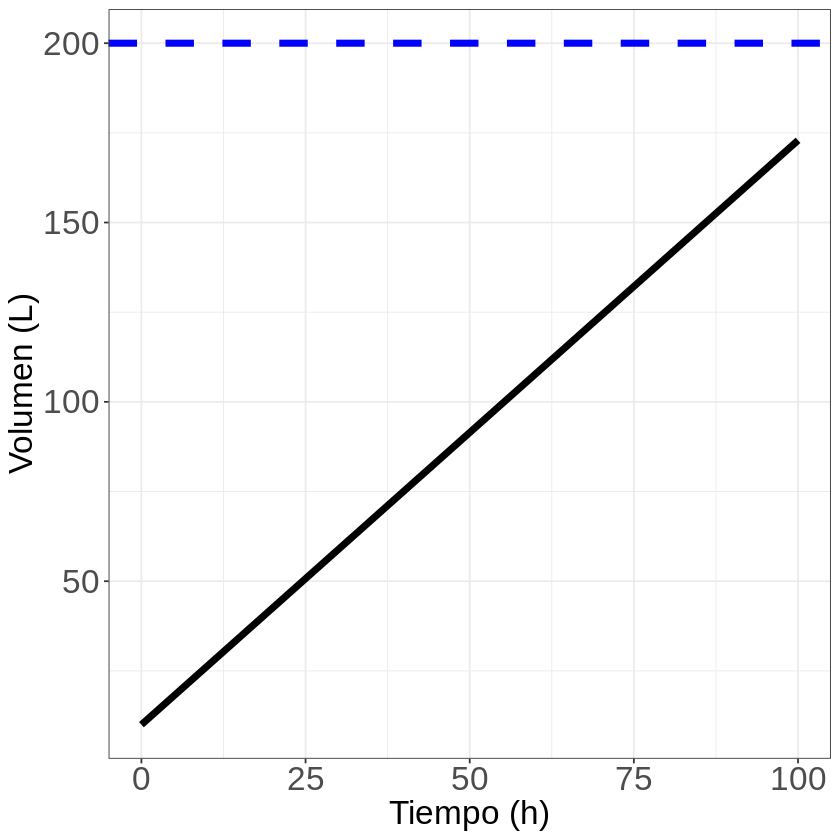

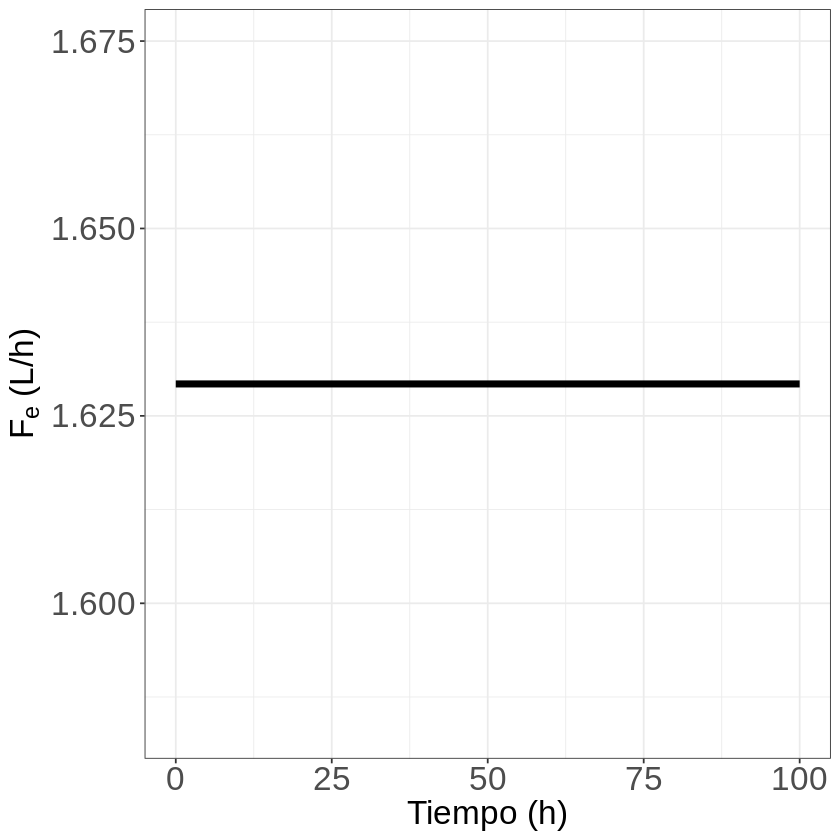

In [70]:
plot_data(out_it_opt_const)

### Optimización de Fin para *Kluyveromyces marxianus*

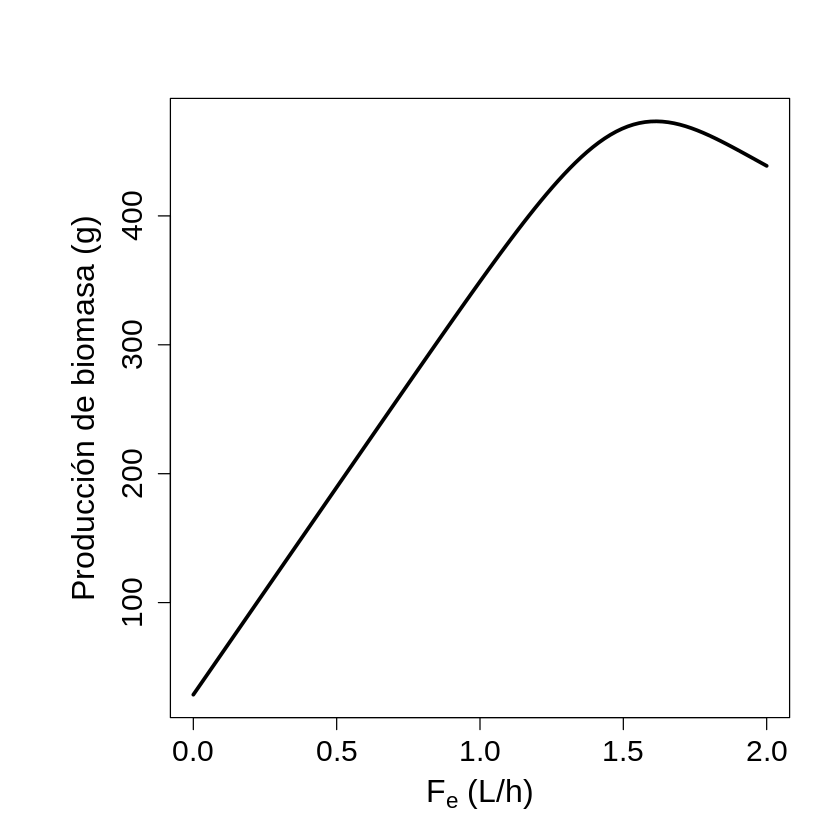

In [28]:
# mostrar función fitness evaluada para todos los Fe
show_fitness(times = times, state = s, parms = p_km, Fe = Fe)

In [29]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_km_const <- get_Fin_opt(p_km, pop_size = pop_size_const, generations = generation_const)

tiempo de ejecución: 0.6060605 


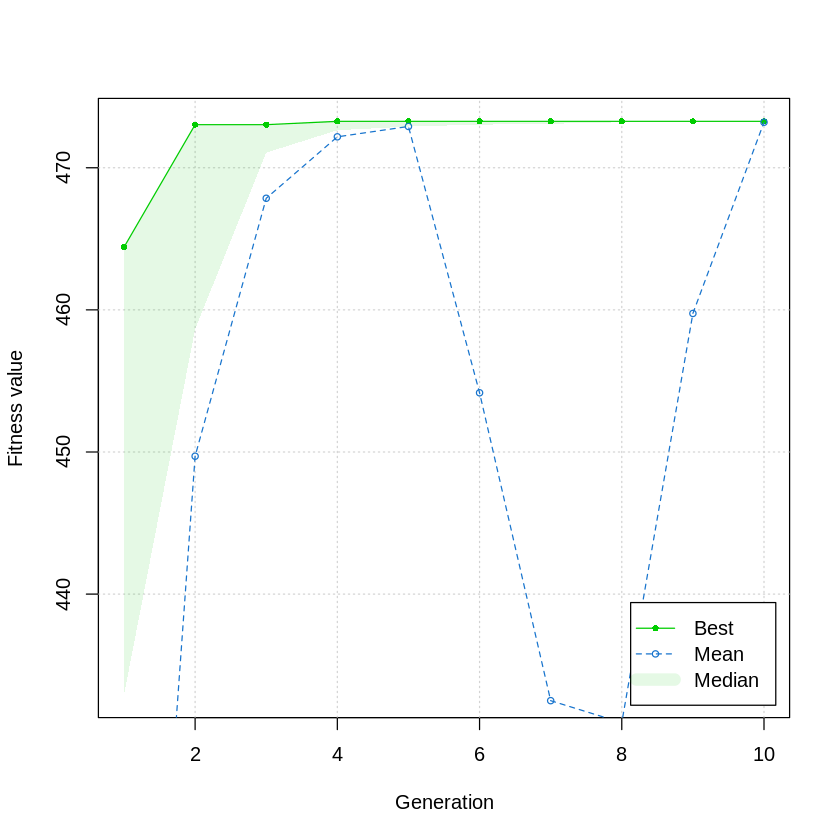

Fin_opt: 1.62926  L/h
mx_opt: 473.2654 g


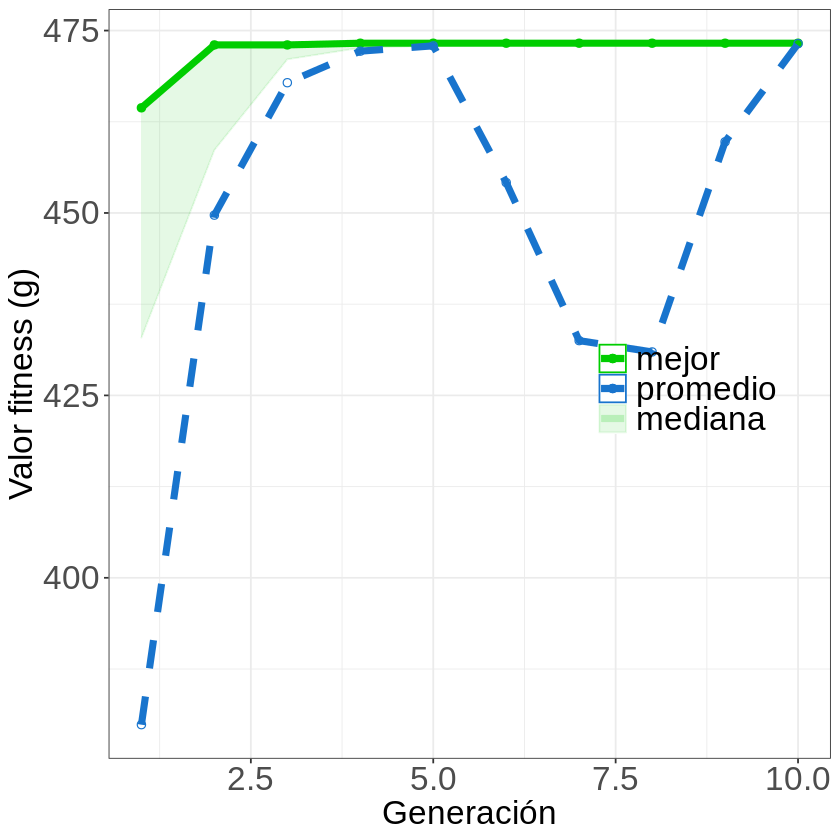

time      V        s         x        p        Fe     
95   94.94949 164.6974 17.579754 2.126095 20.19347 1.62926
96   95.95960 166.3431 15.710609 2.250577 21.38373 1.62926
97   96.96970 167.9889 13.803126 2.377602 22.59825 1.62926
98   97.97980 169.6346 11.907802 2.503812 23.80498 1.62926
99   98.98990 171.2803 10.087903 2.625006 24.96376 1.62926
100 100.00000 172.9260  8.409264 2.736809 26.03281 1.62926

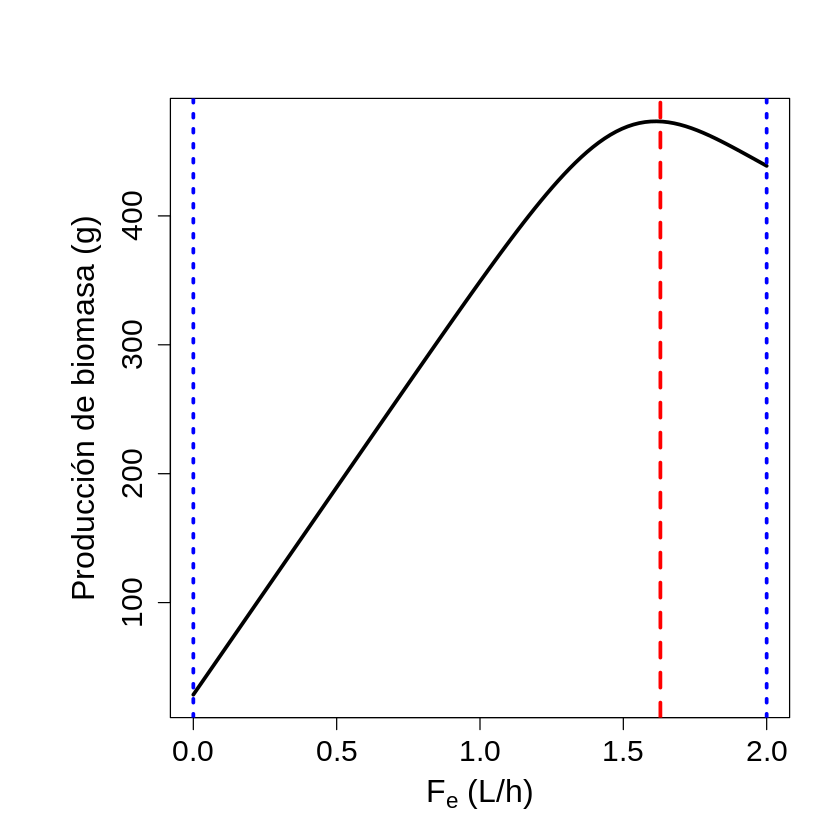

In [30]:
out_km_opt_const <- show_results(GA_km_const, p = p_km)
tail(out_km_opt_const)

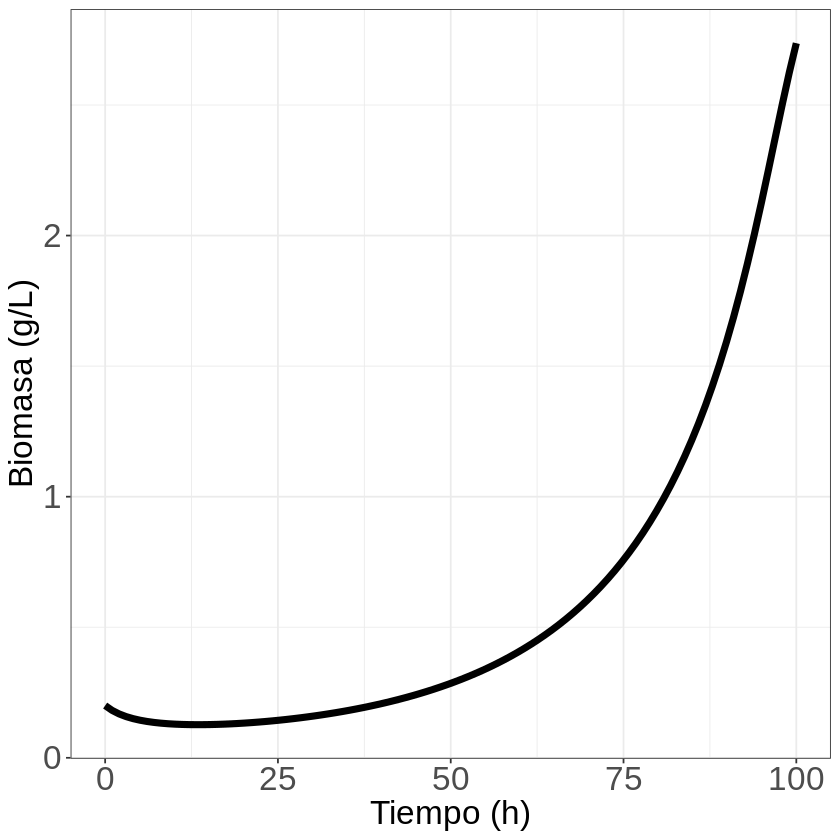

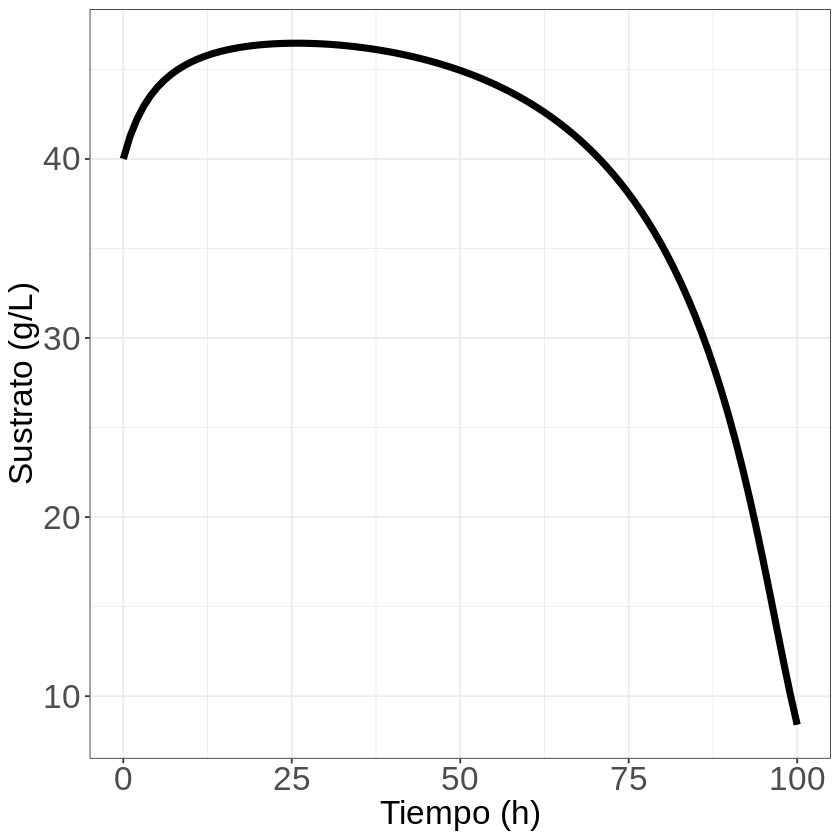

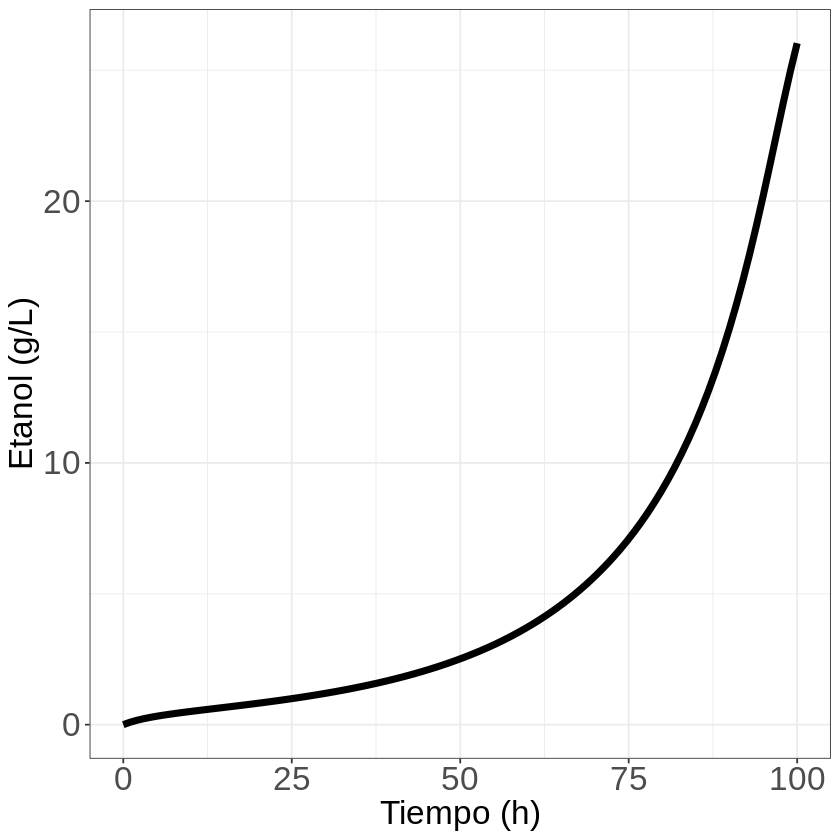

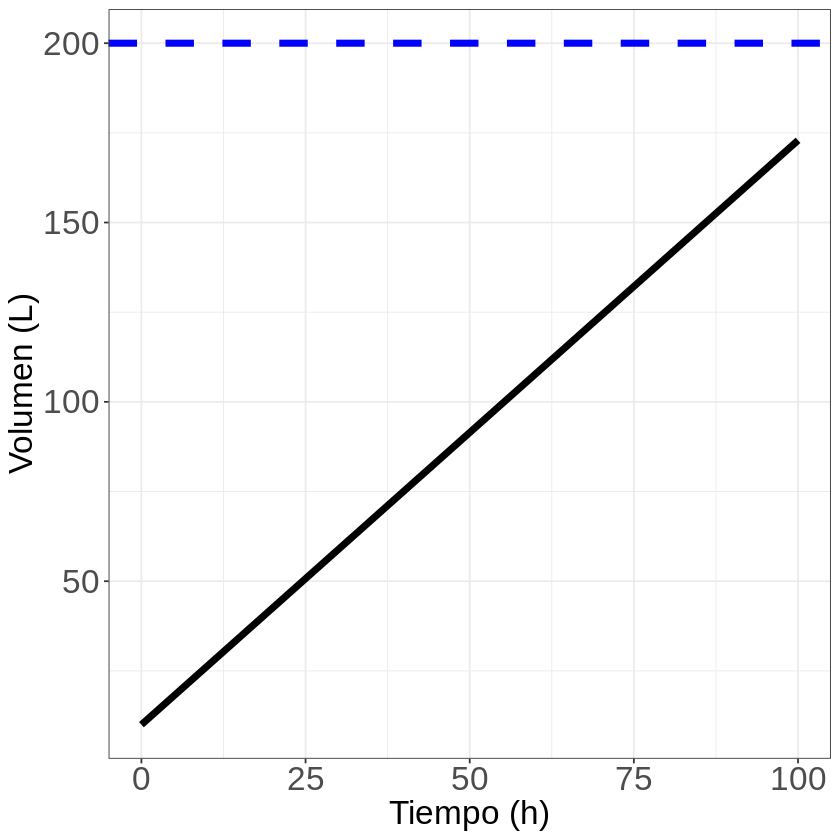

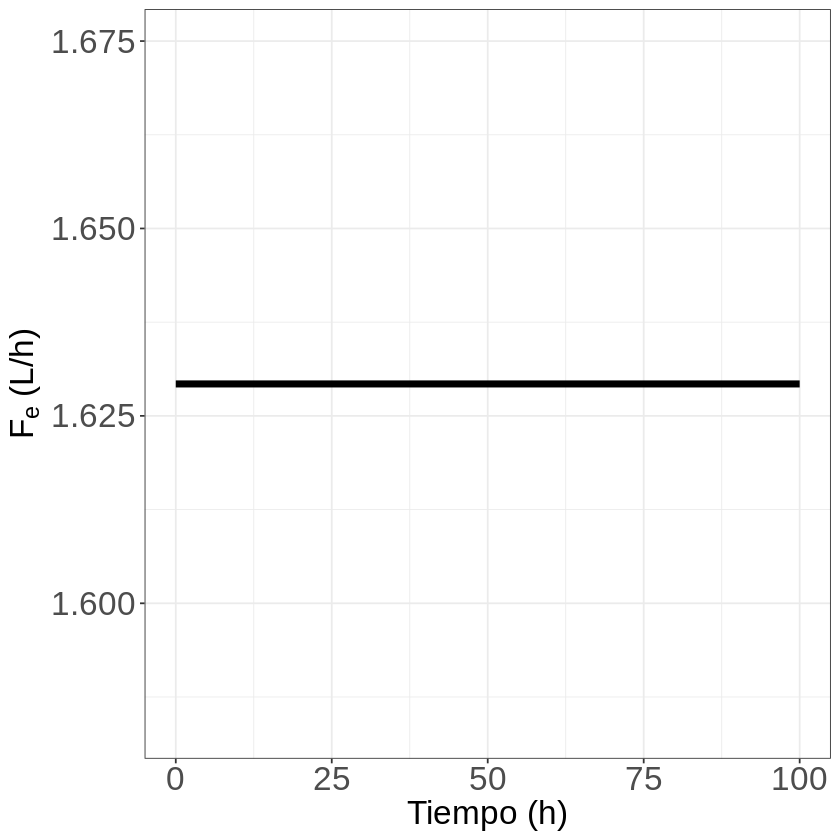

In [31]:
plot_data(out_km_opt_const)

### Optimización de Fin para *Pichia kluyveri*

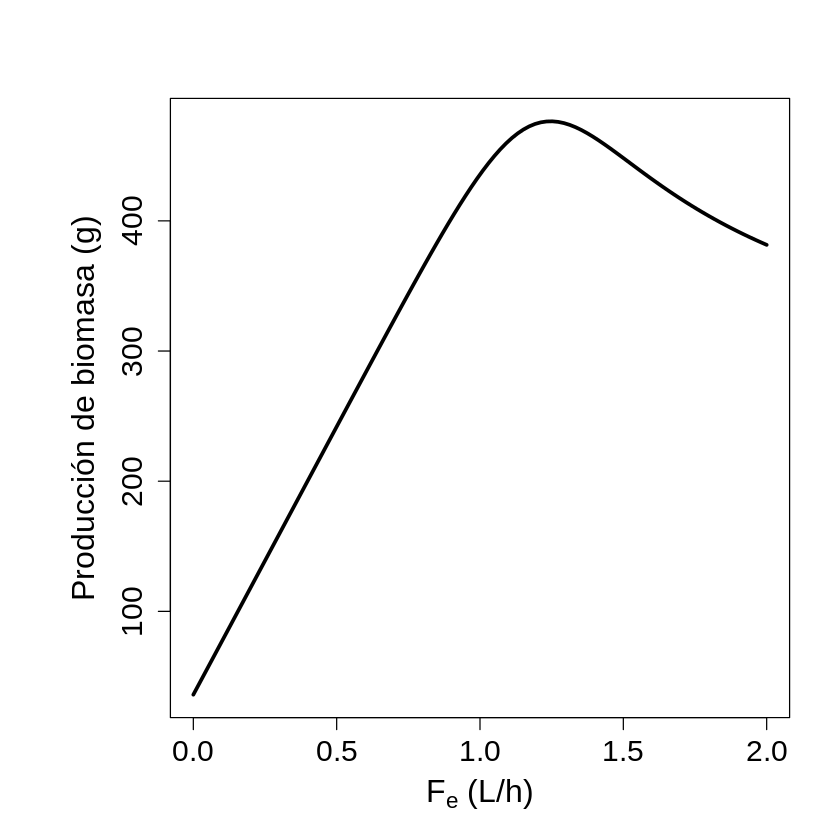

In [32]:
# mostrar función fitness evaluada para todos los Fe
show_fitness(times = times, state = s, parms = p_pk, Fe = Fe)

In [33]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_pk_const <- get_Fin_opt(p_pk, pop_size = pop_size_const, generations = generation_const)

tiempo de ejecución: 0.6113222 


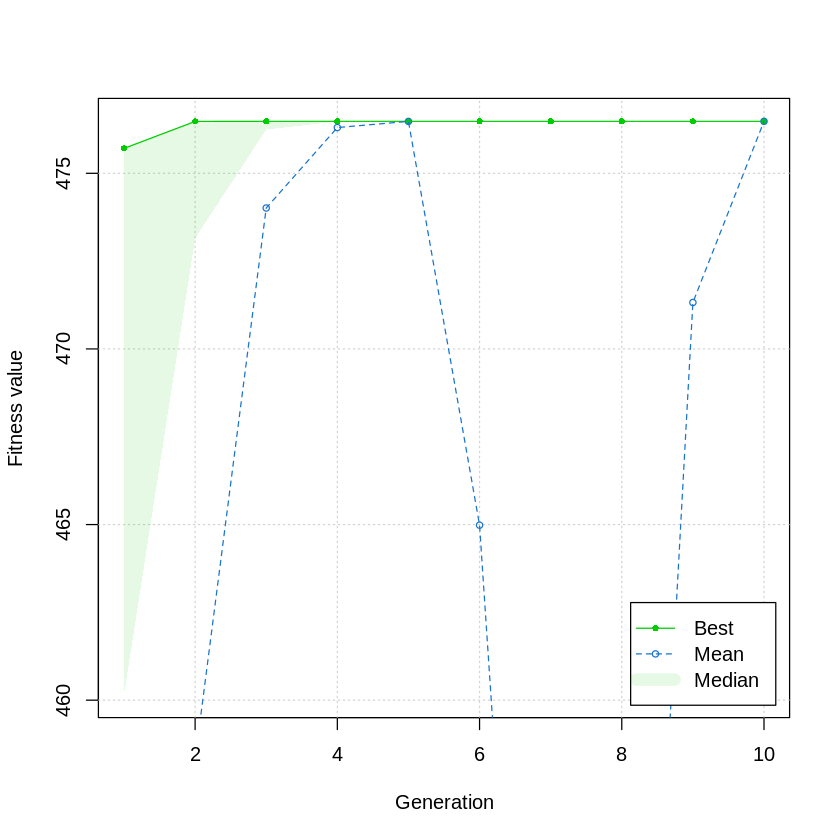

Fin_opt: 1.249466  L/h
mx_opt: 476.4802 g


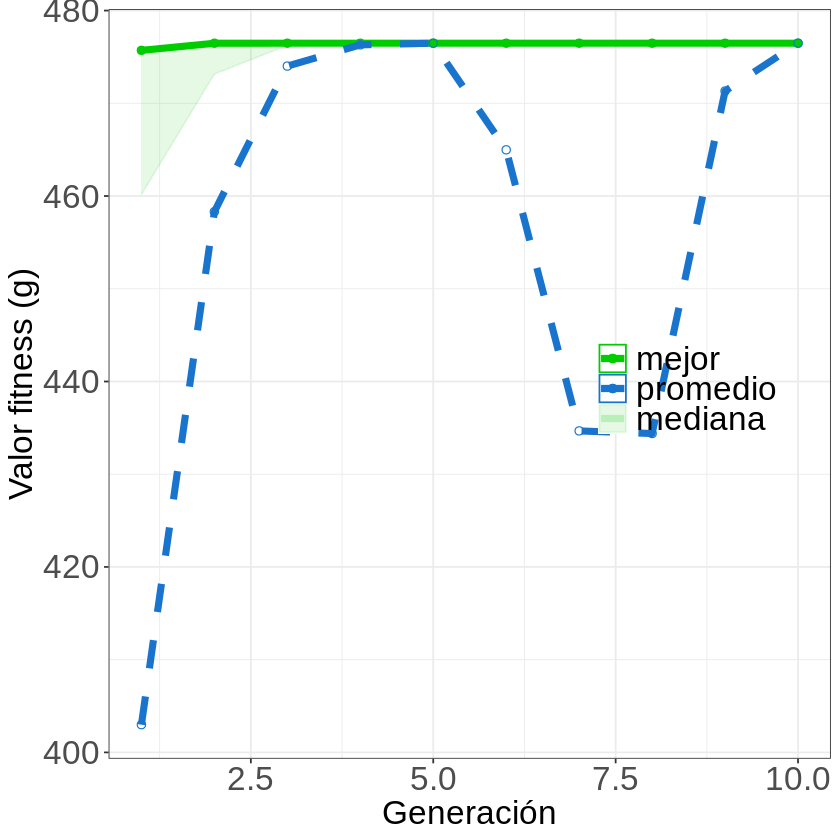

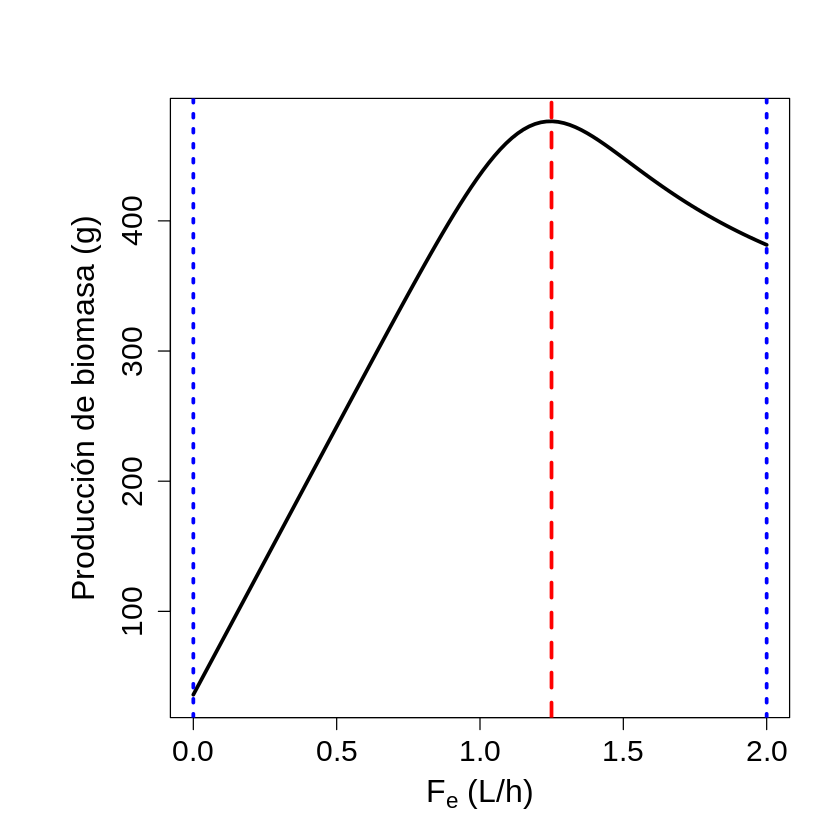

In [34]:
out_pk_opt_const <- show_results(GA_pk_const, p = p_pk)

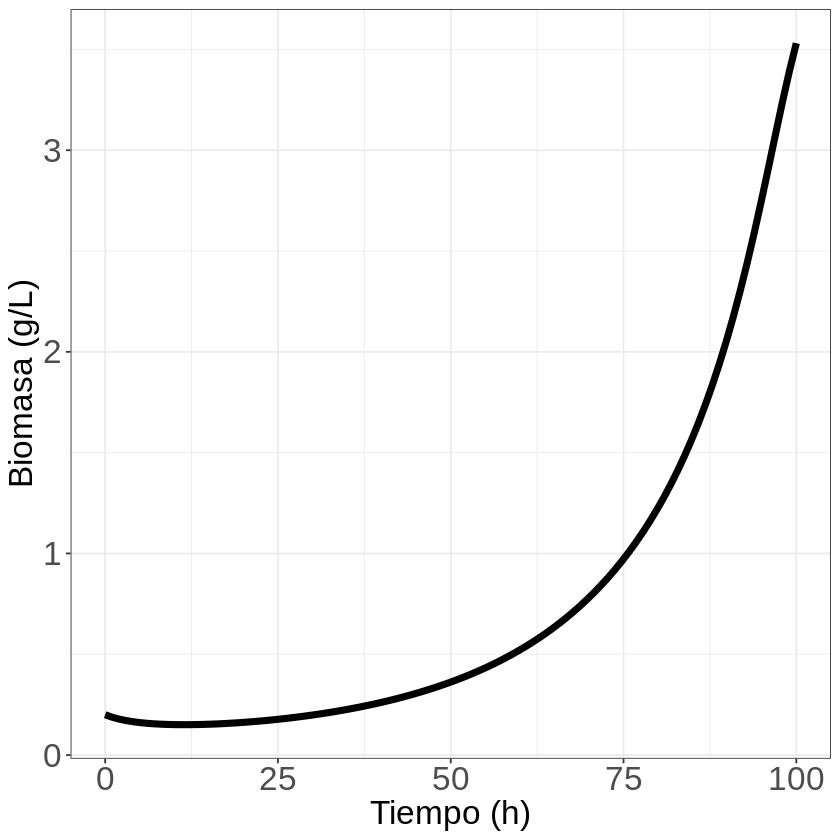

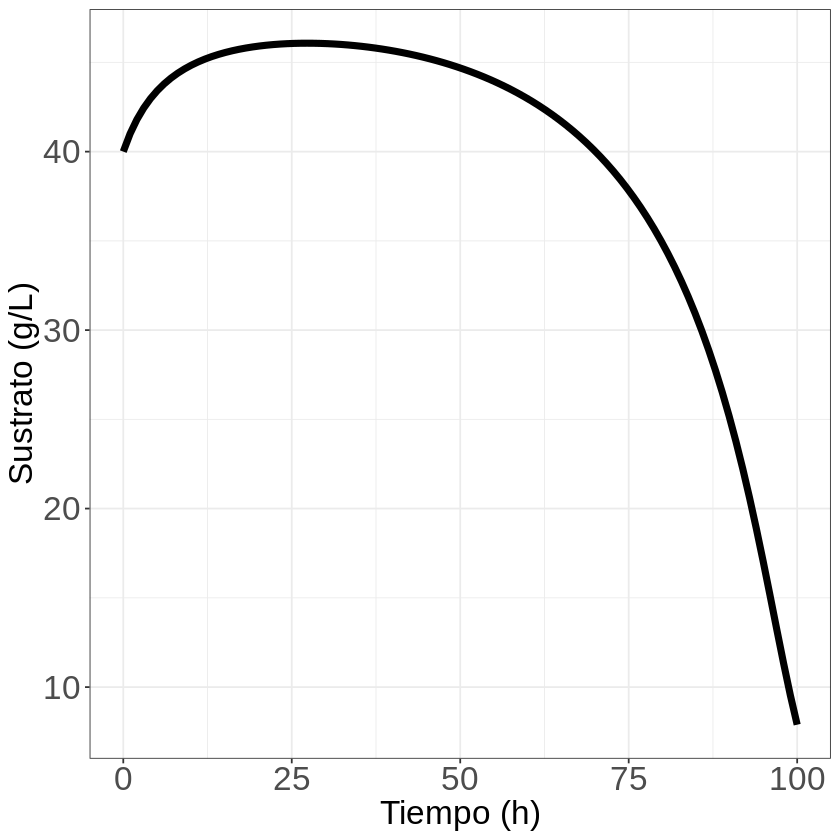

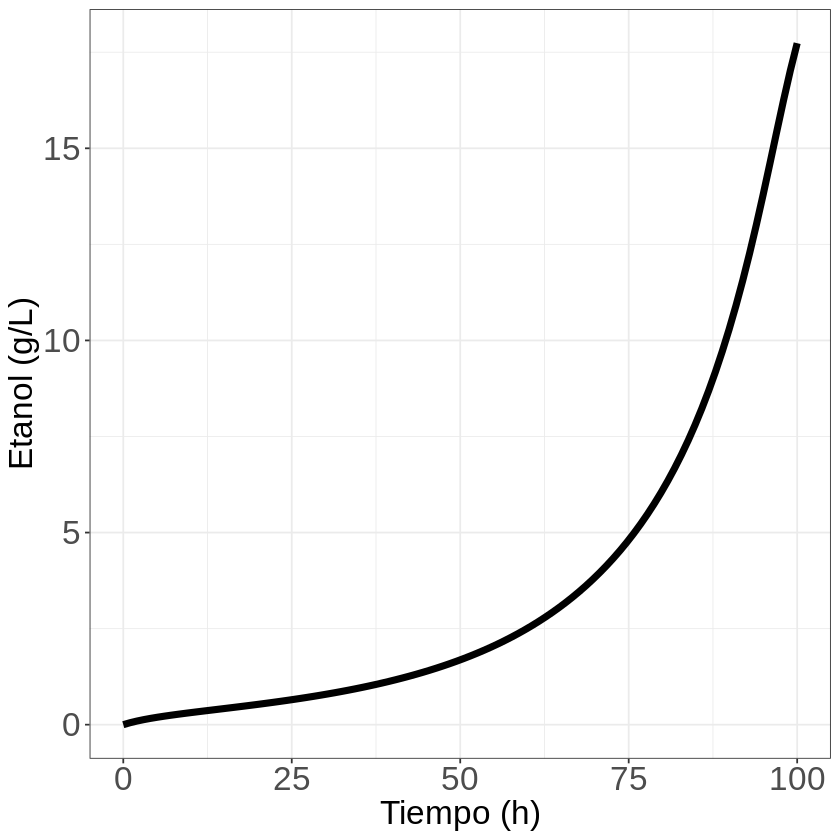

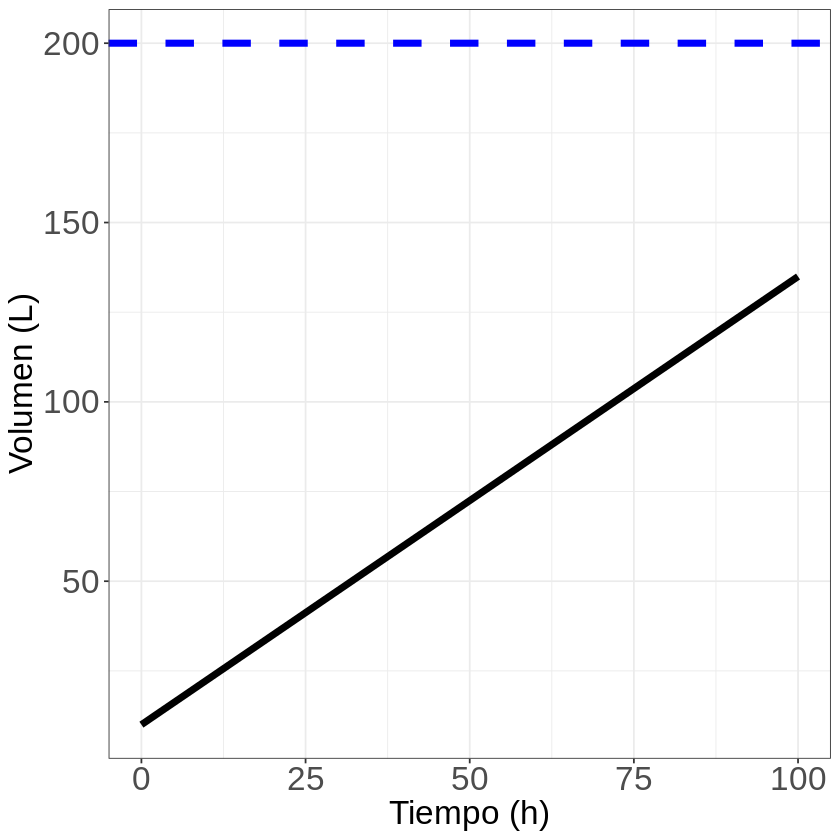

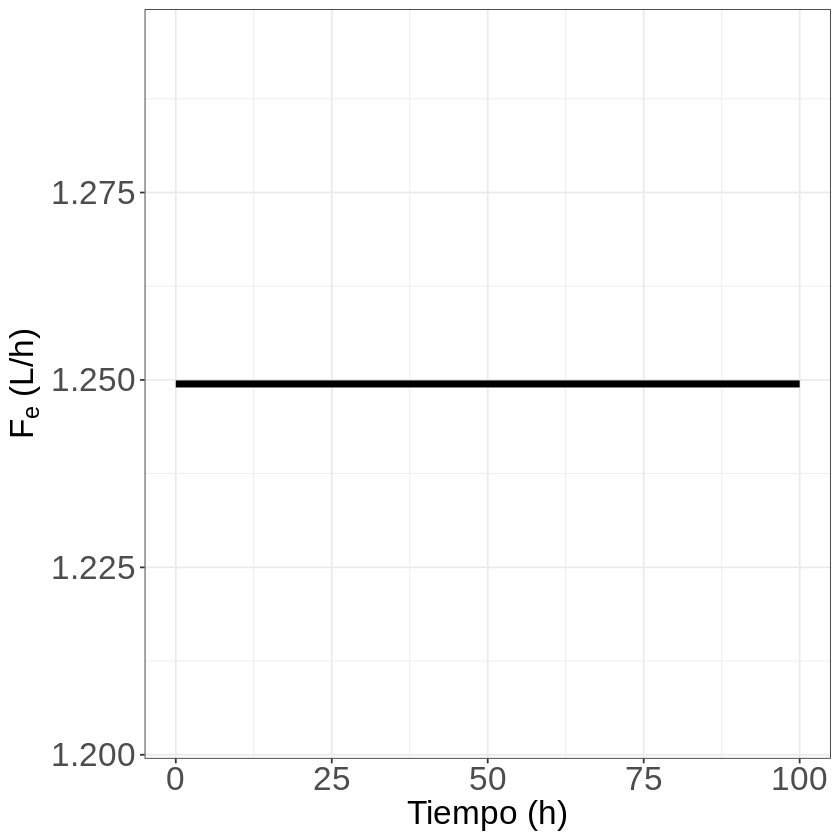

In [35]:
plot_data(out_pk_opt_const)

### Optimización de Fin para *Zygosaccharomyces bailii*

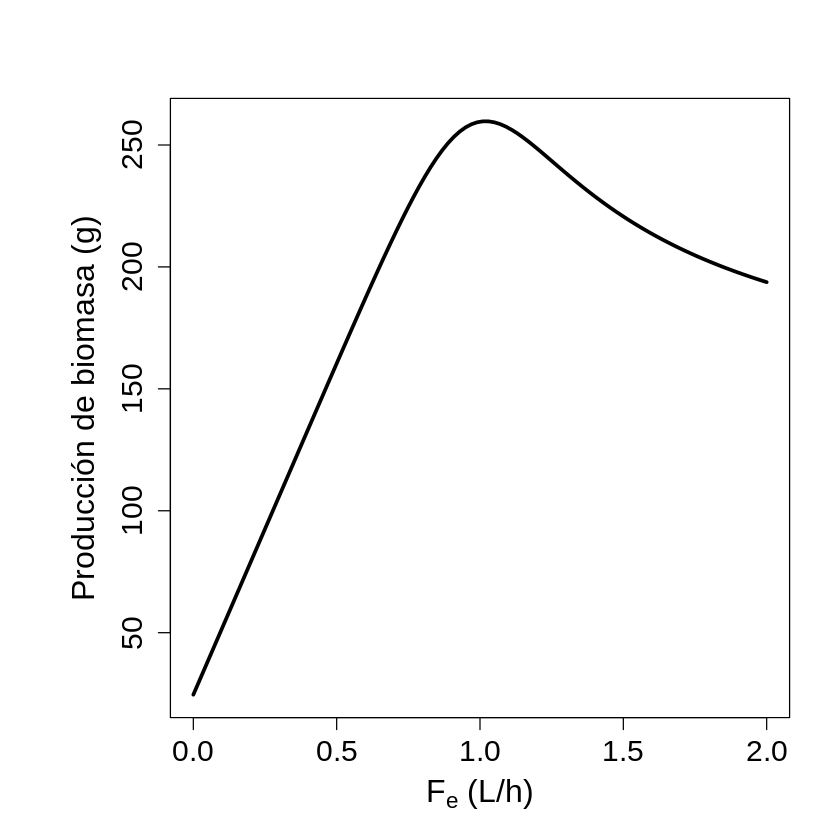

In [36]:
# mostrar función fitness evaluada para todos los Fe
show_fitness(times = times, state = s, parms = p_zb, Fe = Fe)

In [37]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_zb_const <- get_Fin_opt(p_zb, pop_size = pop_size_const, generations = generation_const)

tiempo de ejecución: 0.6393855 


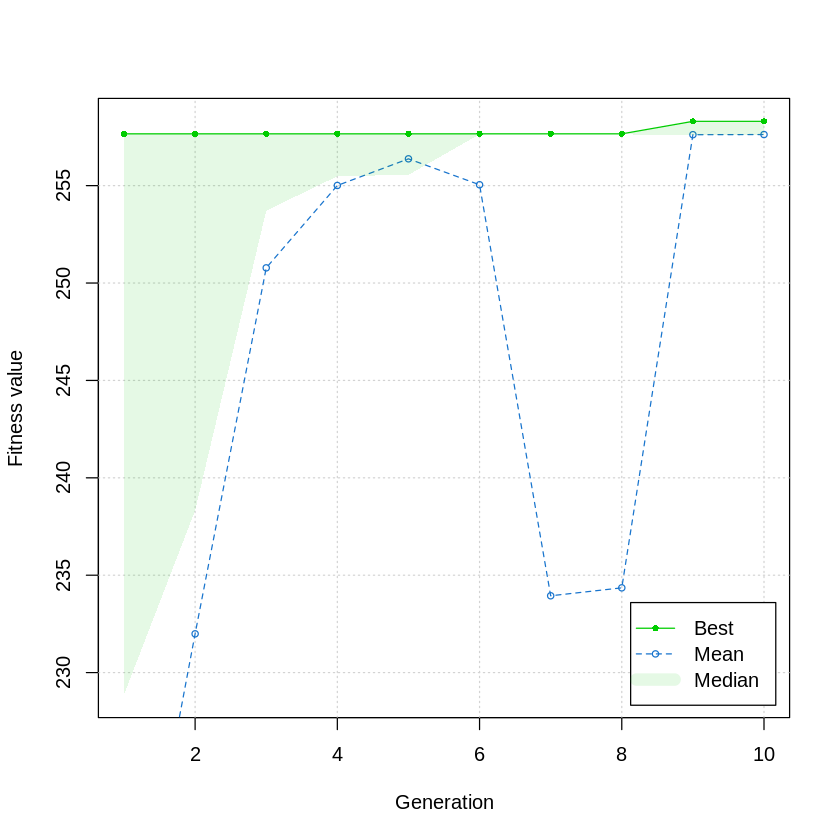

Fin_opt: 0.9663353  L/h
mx_opt: 258.3015 g


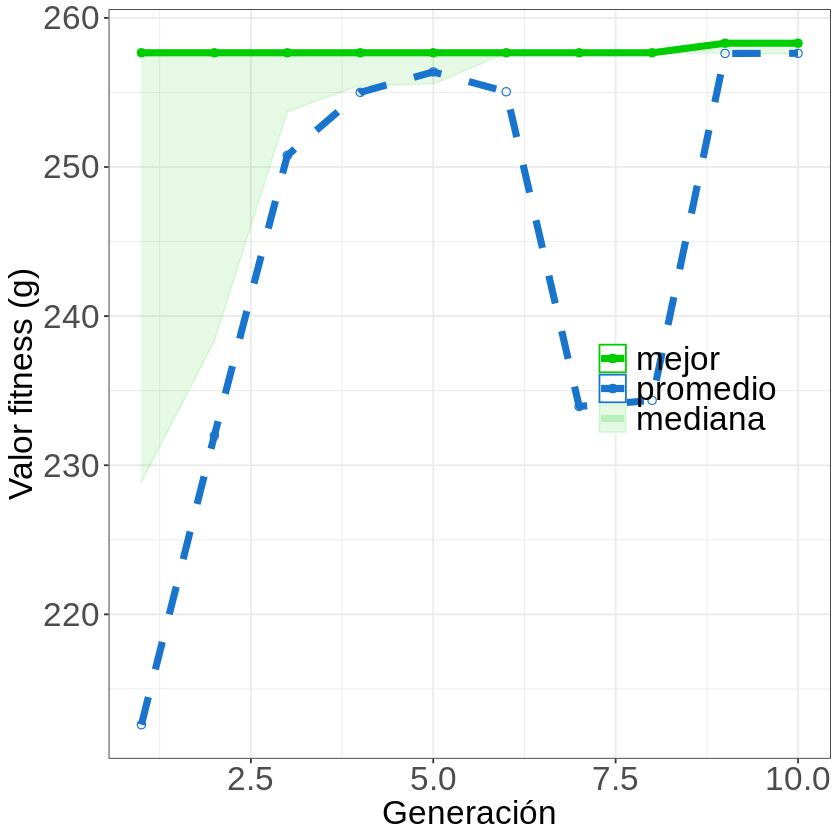

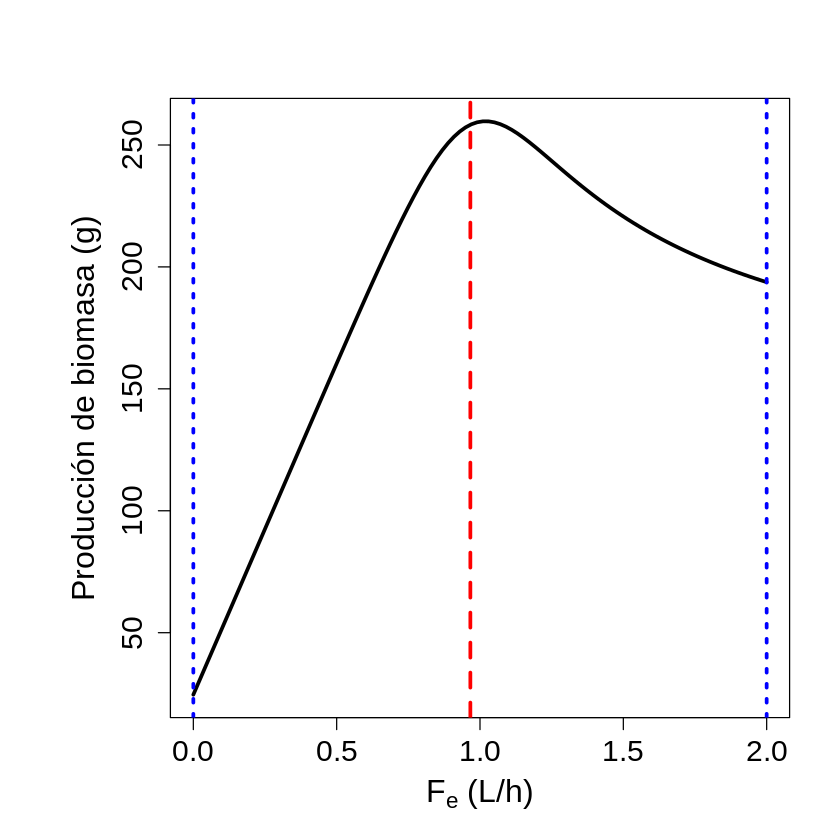

In [38]:
out_zb_opt_const <- show_results(GA_zb_const, p = p_zb)

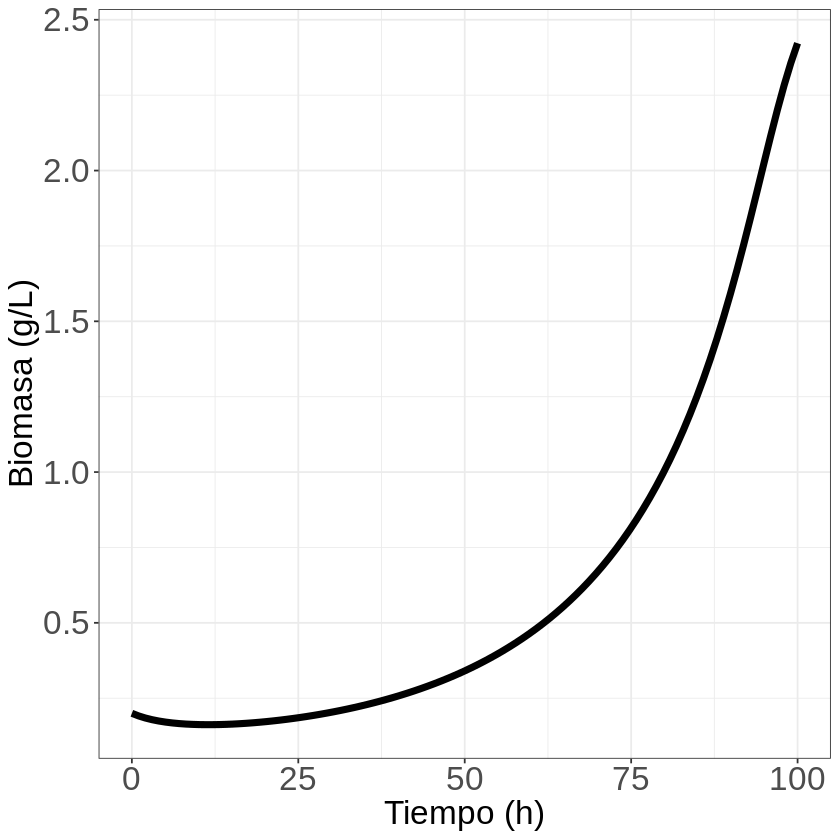

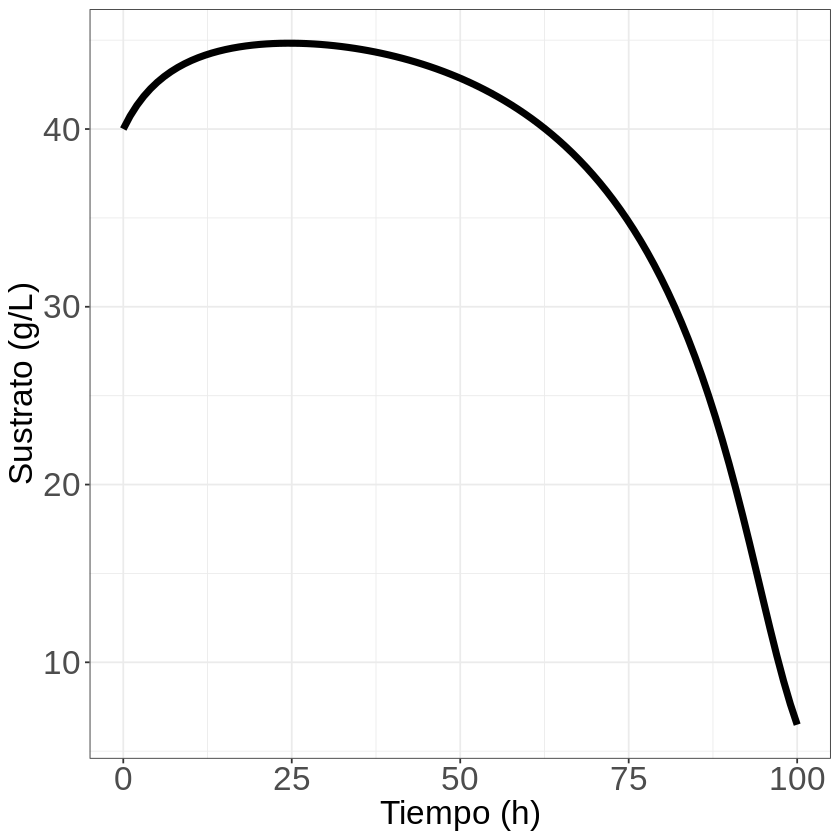

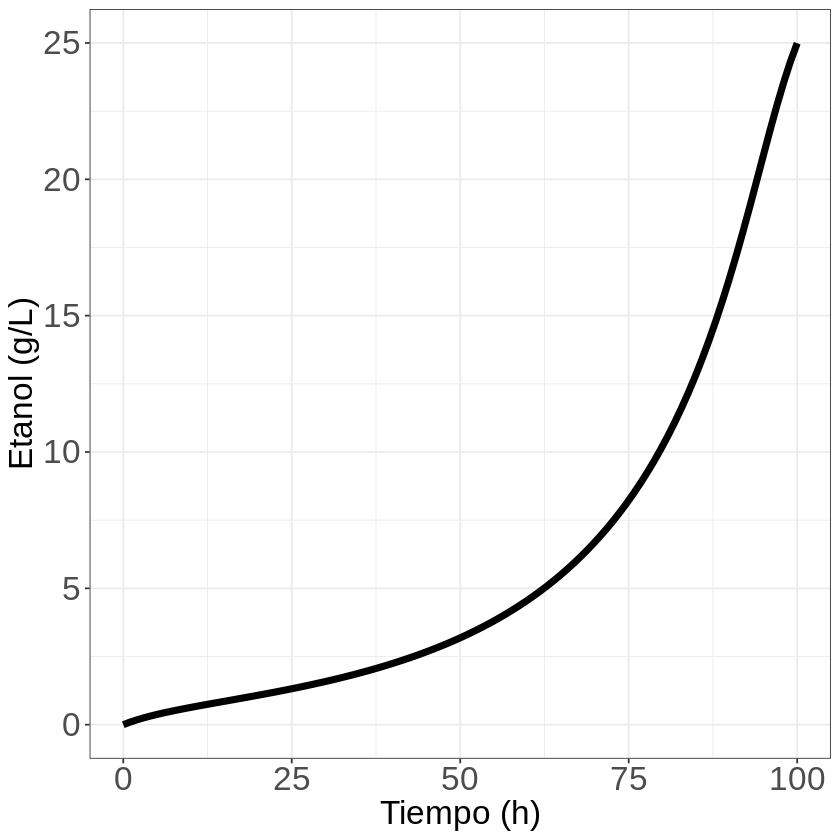

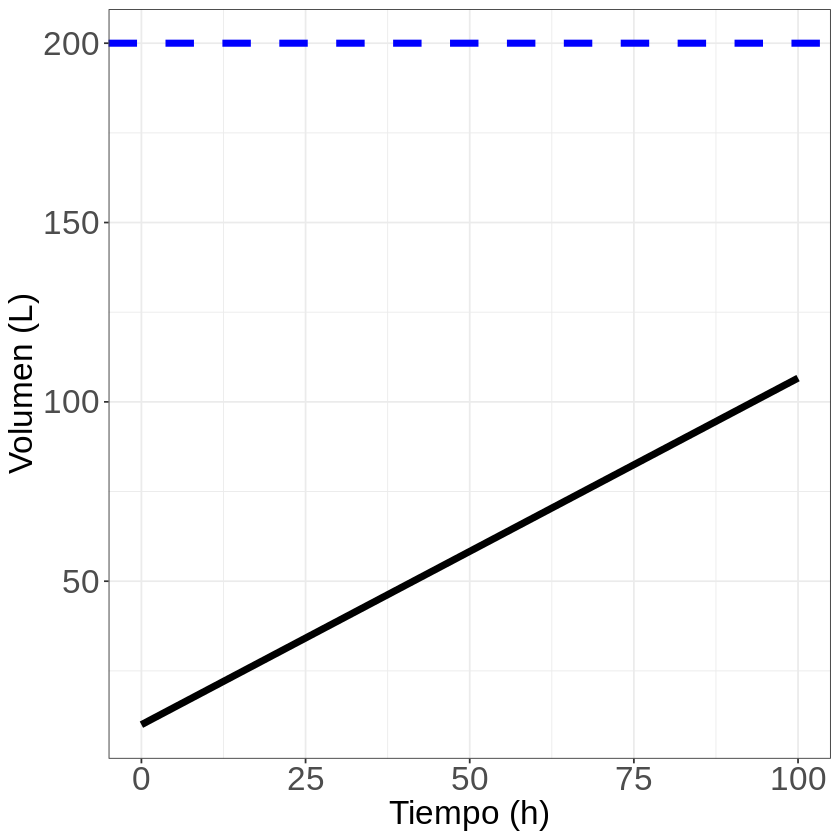

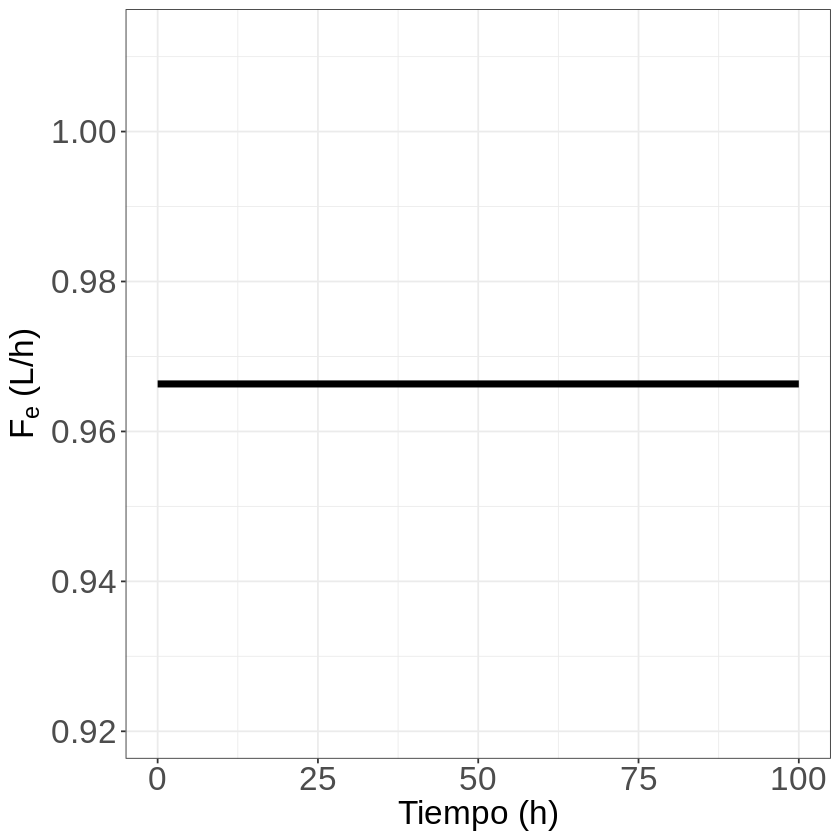

In [39]:
plot_data(out_zb_opt_const)

### Optimización de Fin para *Zygosaccharomyces rouxi*

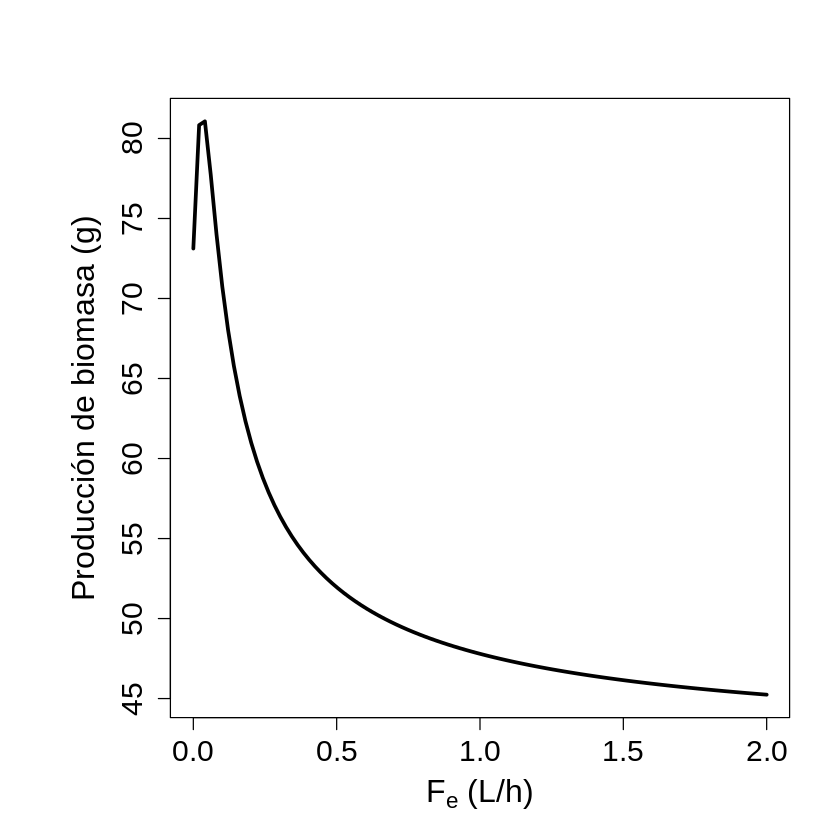

In [40]:
# mostrar función fitness evaluada para todos los Fe
show_fitness(times = times, state = s, parms = p_zr, Fe = Fe)

In [41]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_zr_const <- get_Fin_opt(p_zr, pop_size = pop_size_const, generations = generation_const)

tiempo de ejecución: 0.5707312 


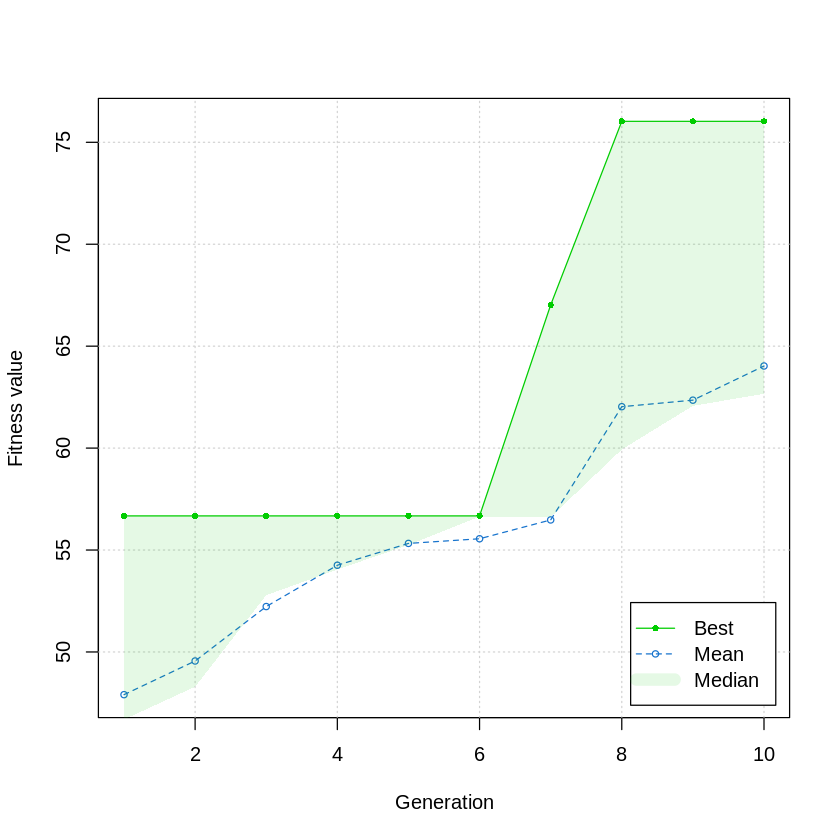

Fin_opt: 0.06974961  L/h
mx_opt: 76.02821 g


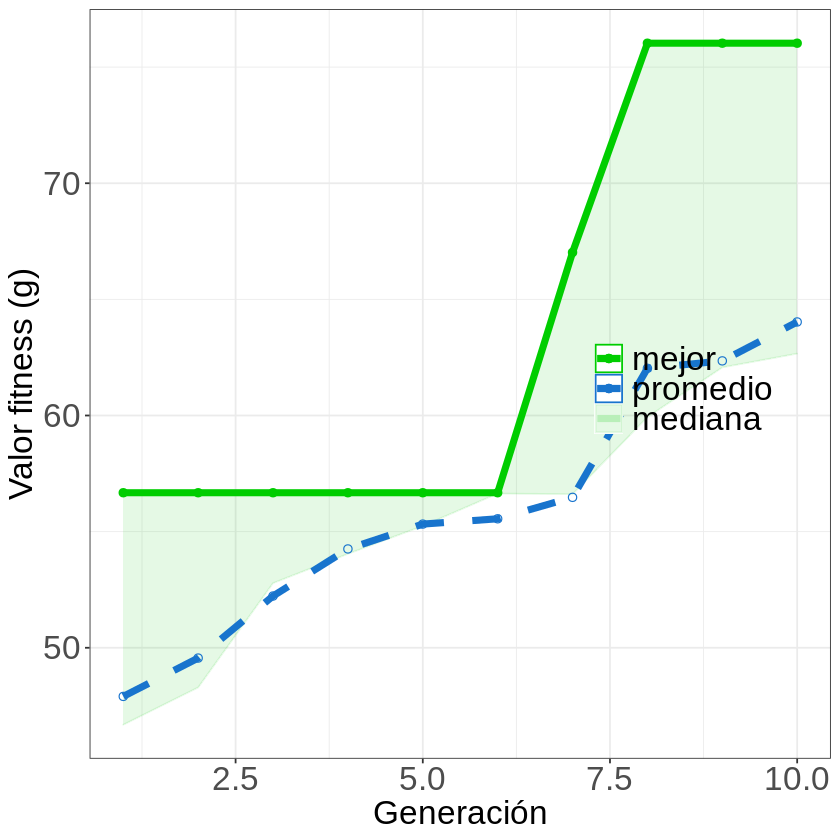

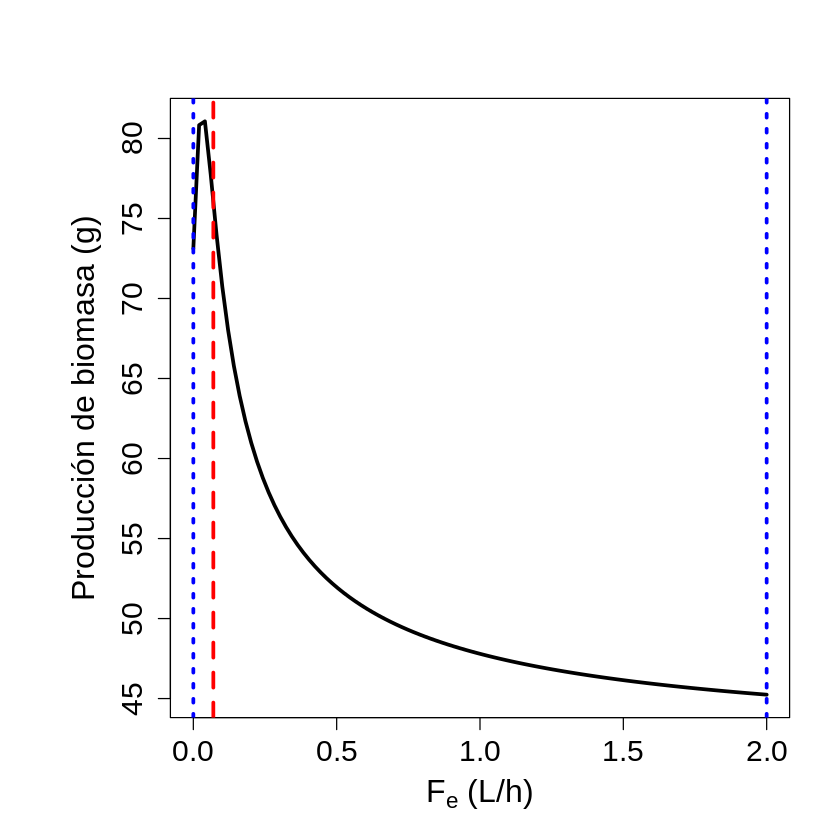

In [42]:
out_zr_opt_const <- show_results(GA_zr_const, p = p_zr)

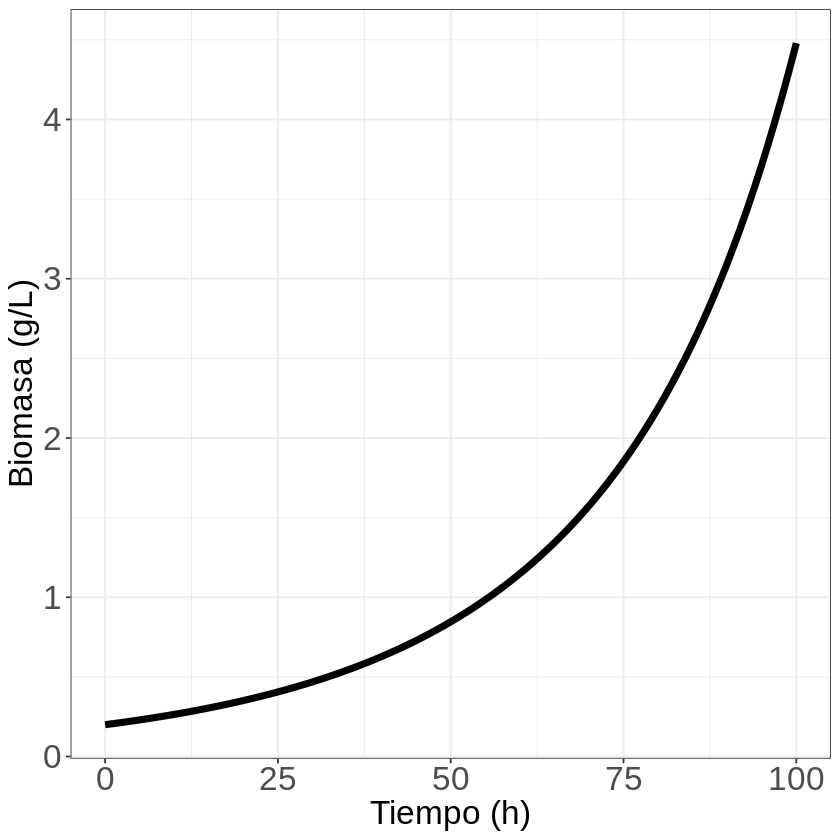

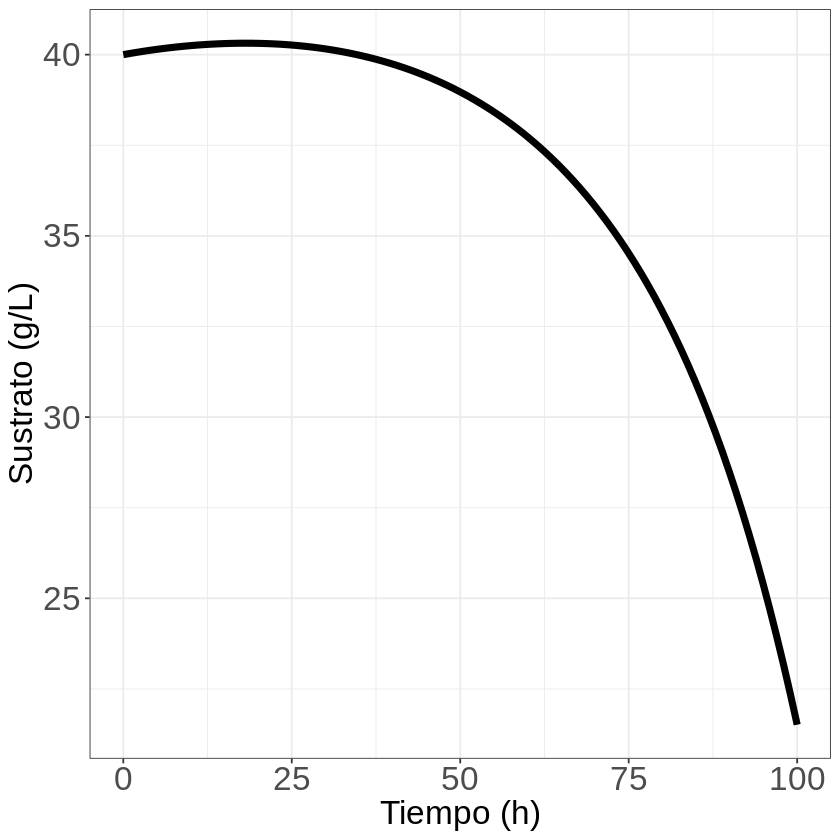

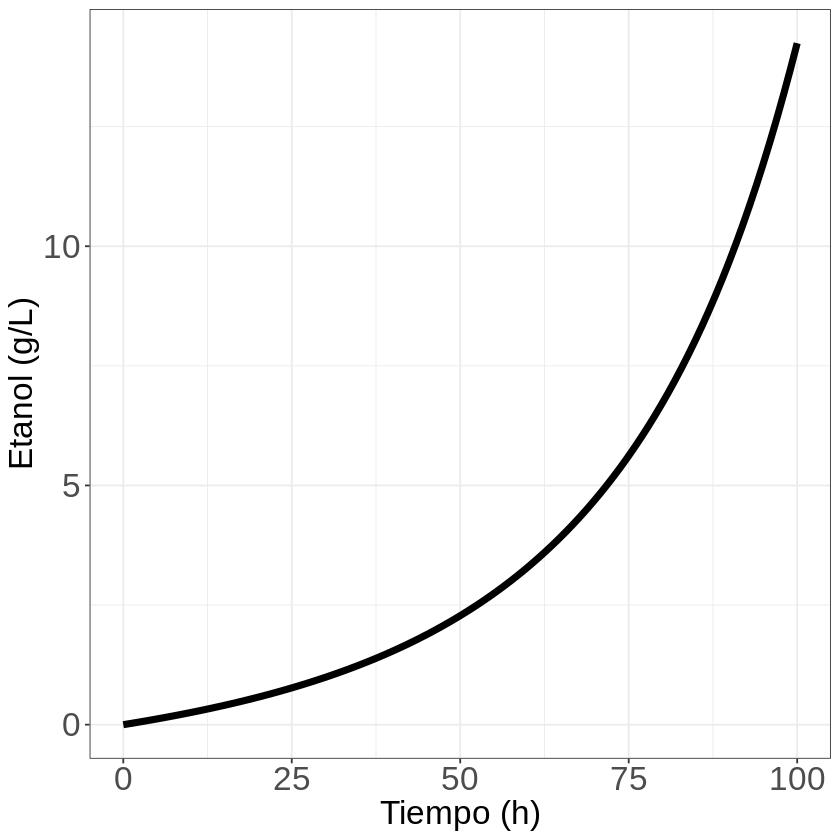

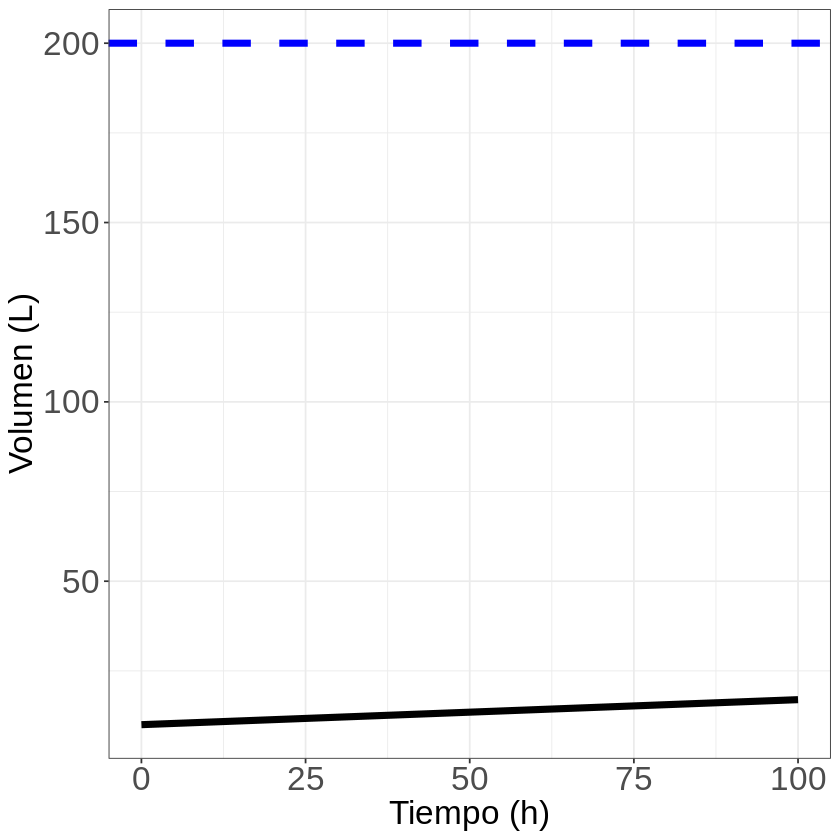

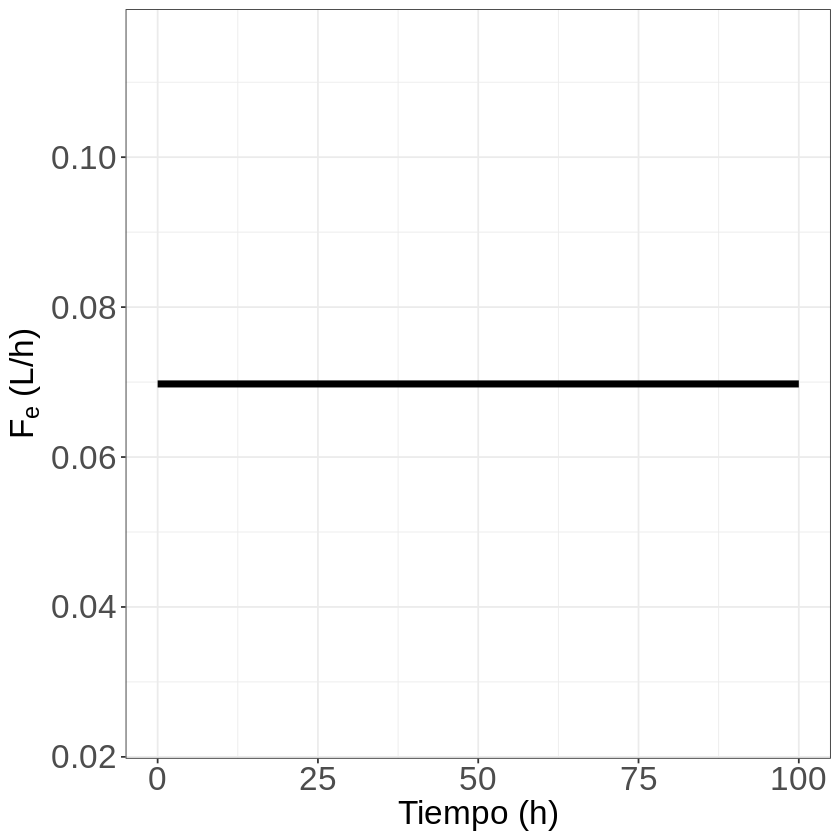

In [43]:
plot_data(out_zr_opt_const)

# Encontrar el perfil de alimentación $F_{e}$ que genera la máxima producción de biomasa $m_x$

Ahora optimizamos para encontrar el perfil $F_{e}$ que genere una máxima producción de biomasa

In [83]:
#@title función para variar Fe durante el proceso
change_Fe <- function(times, state, parms, Fe) {
        
        n <- length(times)
        # vectores para guardar los resultados
        V <- rep(state[1], n)
        su <- rep(state[2],n)
        x <- rep(state[3],n)
        p <- rep(state[4],n)
        
        # resolver EDO para los diferentes valores de Fin
        for (i in 1:(n-1)) {
                # actualizar tiempo de integración
                tspan <- c(times[i], times[i+1])
                # resolver EDOs
                out <- ode(y = state,
                           times = tspan,
                           func = model,
                           parms = parms,
                           Fe = Fe[i+1])# actualizar Fin
                m <- nrow(out)
                # actualizar condiciones iniciales
                state <- out[m,c(2,3,4,5)]
                # guardar resultados 
                out <- as.data.frame(out)
                V[i+1] <- out$V[m]
                su[i+1] <- out$s[m]
                x[i+1] <- out$x[m]
                p[i+1] <- out$p[m]
                Fe[i+1] <- out$Fe[m]
        }
        
        out <- data.frame(times = times, x = x, s = su, p = p, V = V, Fe = Fe)
        return(out)
}

In [84]:
Fe <- rep(0, length(times))
Fe[51:100] <- 1

In [85]:
out <- change_Fe(times = times, state = s, parms = p, Fe = Fe)
tail(out)

times     x        s        p        V        Fe
95   94.94949 8.281084 6.971611 32.98007 55.45455 1 
96   95.95960 8.358649 6.612819 33.29291 56.46465 1 
97   96.96970 8.429268 6.287738 33.57788 57.47475 1 
98   97.97980 8.493500 5.993620 33.83721 58.48485 1 
99   98.98990 8.551909 5.727704 34.07317 59.49495 1 
100 100.00000 8.605042 5.487293 34.28795 60.50505 1

In [86]:
n <- nrow(out)
cat("mx_end:", out$V[n]*out$x[n])

mx_end: 520.6485

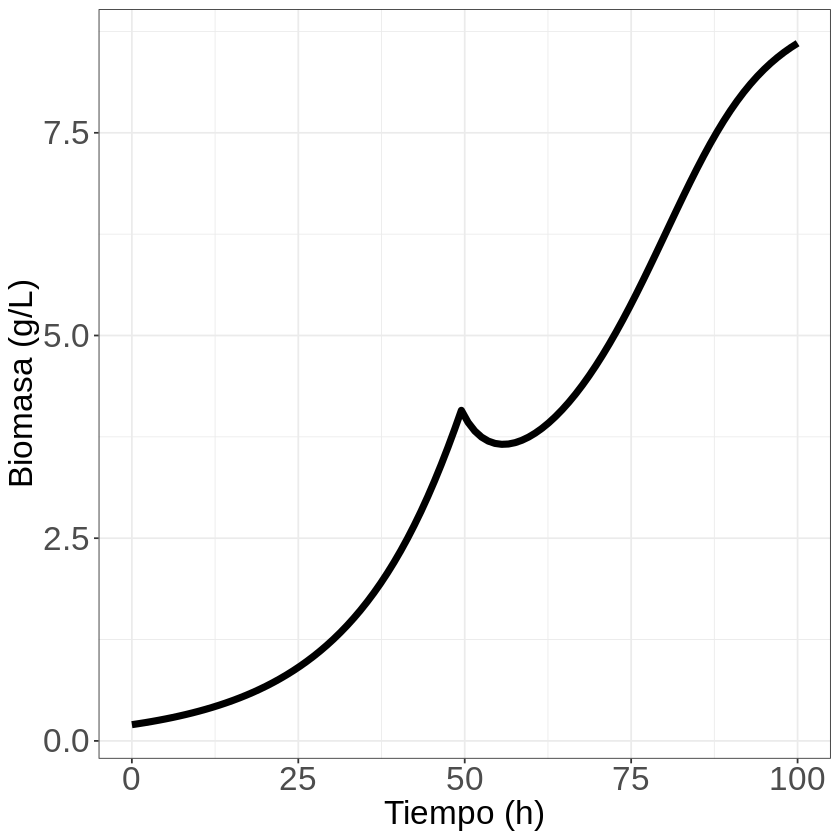

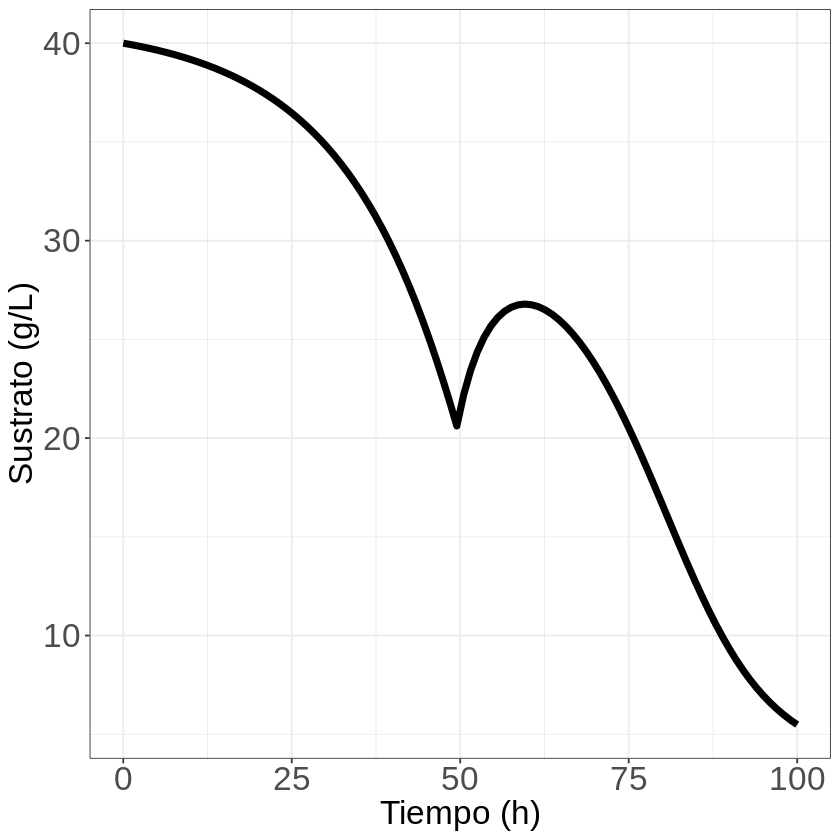

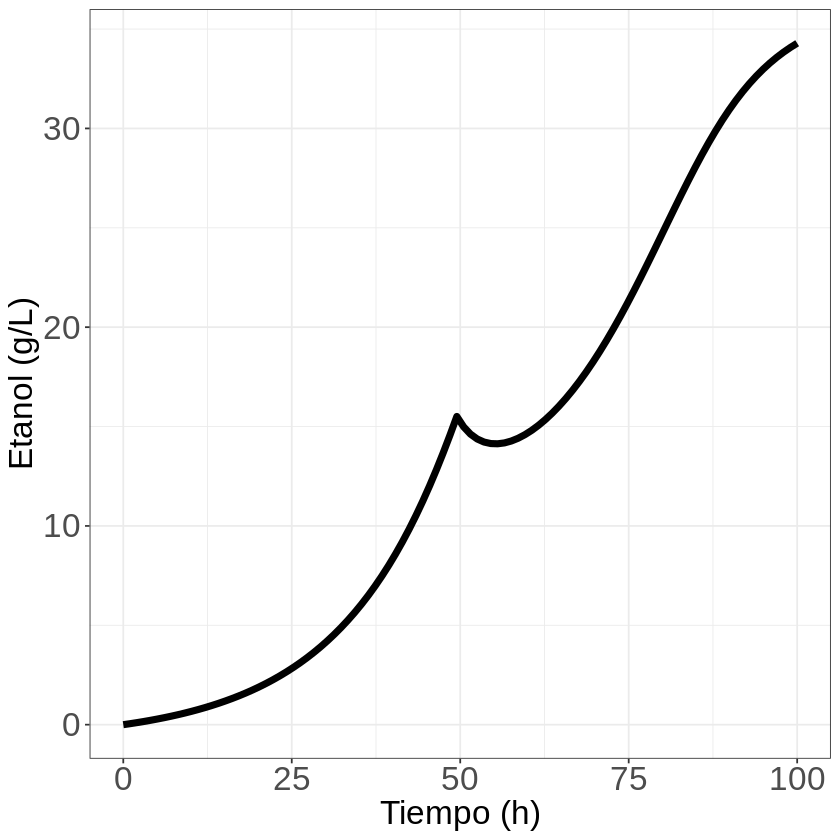

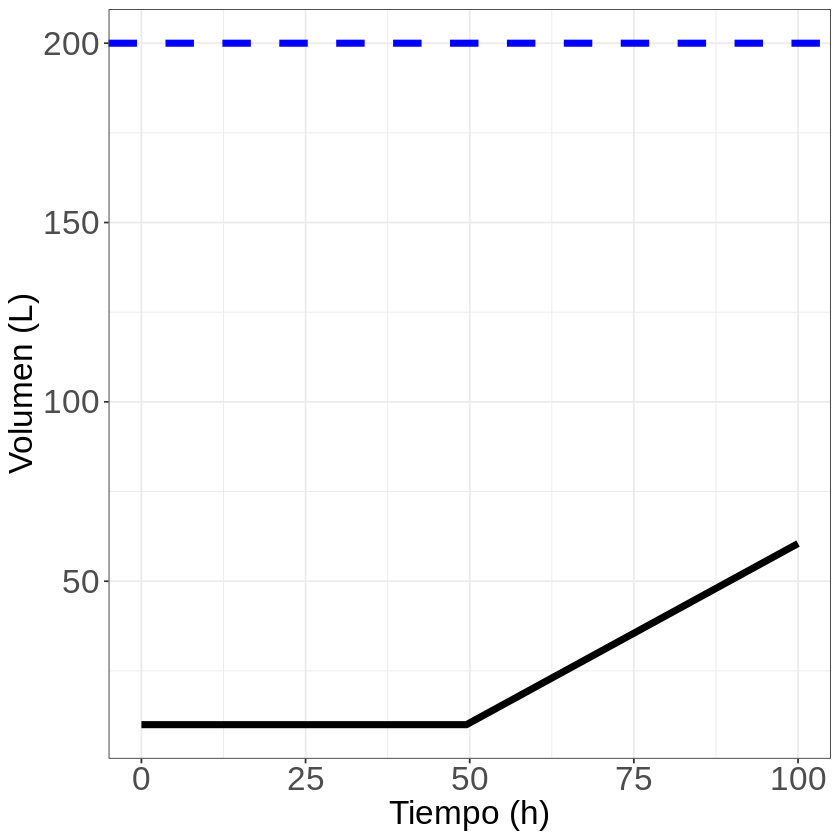

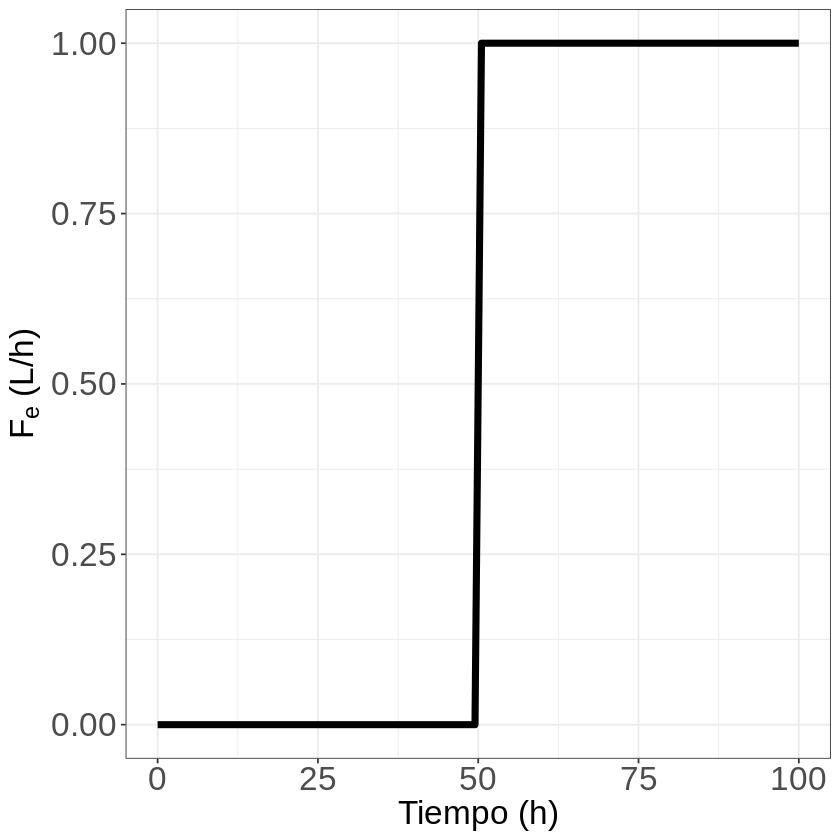

In [87]:
plot_data(out)

In [88]:
#@title función para suavizar el perfil de alimentación
smooth_Fe <- function(Fe) {
  for (i in 1:(length(Fe)/2)) {
    Fe[(2*i-1):(2*i)] = mean(Fe[(2*i-1):(2*i)])
  }
  return(Fe)
}

In [89]:
#@title función para modificar el perfil óptimo obtenido con el GA
modify_Fe <- function(Fe){
        Fe <- rep(Fe, each = 5)
        Fe <- smooth_Fe(Fe) # suavizar perfil
        return(Fe)
}

In [90]:
# @title función fitness para encontrar el perfil óptimo Fin de alimentación al biorreactor
fitness2 <- function(x, times, state, parms) {
        # x es el vector  con valores de Fin 
        # x tiene una longitud de 10, para hacerlo de tamaño 100 usamos rep()
        Fe <- modify_Fe(x)
        #Fin <- x
        # simular usando Fin variable 
        out <- change_Fe(times = times, state = state, 
        parms = parms, Fe = Fe)
        n <- length(times)
        # biomasa generada con el perfil Fin
        end_mx <- out$x[n]*out$V[n]
        
        return(end_mx)
}

In [91]:
fitness2(x = rep(c(0,1), each = 10), times = times, state = s, parms = p)

[1] 520.6485

### Optimización de perfil Fin para *Isstchenkia terrícola*

In [92]:
# @title función para obtener el perfil óptimo
get_Fin_opt2 <- function(p, pop_size, generations) {
    time1 <- Sys.time()
    GA <- ga(type = "real-valued",
            fitness = fitness2,
            times= times,
            state = s,
            parms = p,
            lower = rep(0, 20),
            upper = rep(2, 20),
            maxiter = 1000, 
            popSize = 50, 
            elitism = 2)
    time2 <- Sys.time()
    cat("timepo de ejecución:",time2 - time1)
    return(GA)
}

In [93]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_it <- get_Fin_opt2(p_it, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución: 35.74881

In [147]:
#@title función para mostrar resultados de optimización del perfil óptimo
show_results2 <- function(GA, GA_const, p) {
    # mostrar evolución del algoritmo
    show_GA_evol(GA)
    # valor máximo de biomasa que se obtuvo
    cat("mx_opt:", GA@fitnessValue, "g\n")
    cat("mx_opt:", GA_const@fitnessValue, "g (Fin constante)")
    # guardar perfil óptimo
    Fe_opt <- modify_Fe(Fe = GA@solution[1,])
    # graficar perfil óptimo
    par(mar = c(5,7,4,2) + 0.1)
    plot(times, Fe_opt, type = "l", lwd = 3, 
        ylab = expression(paste(F[e], " (L/h)")), xlab = "Tiempo (h)", cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,2))
    abline(h = mean(Fe_opt), lty = 2, lwd = 3, col = "red")
    abline(h = GA_const@solution, lty = 3, lwd = 3, col = "blue")
    # simular con perfil óptimo
    out_opt <- change_Fe(times = times, state = s, parms = p, Fe = Fe_opt)
    
    return(out_opt)
}

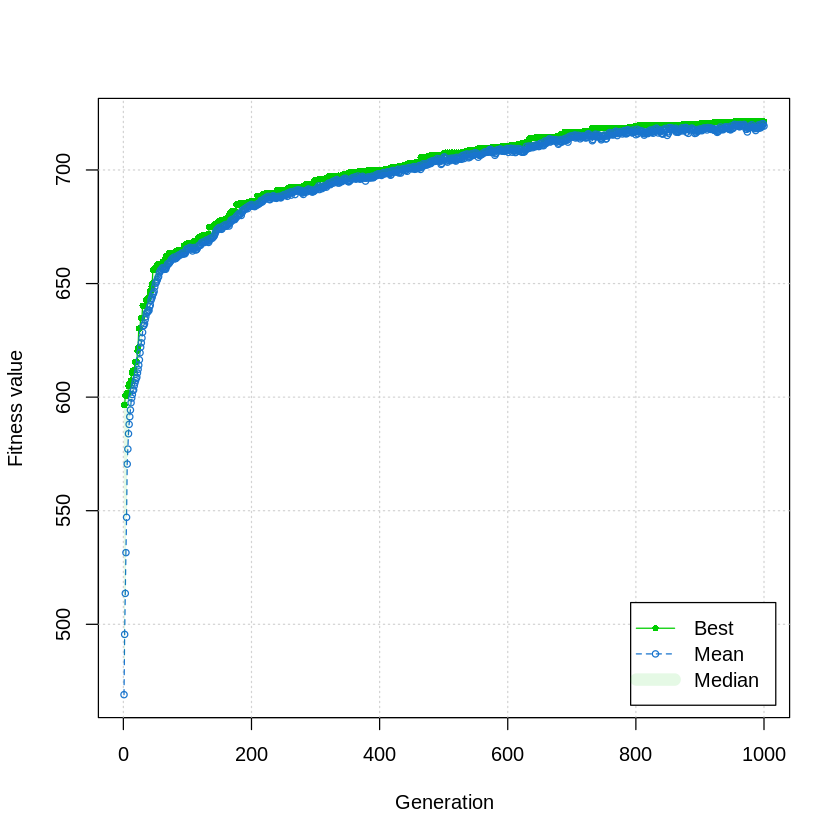

mx_opt: 721.4138 g
mx_opt: 651.7111 g (Fin constante)

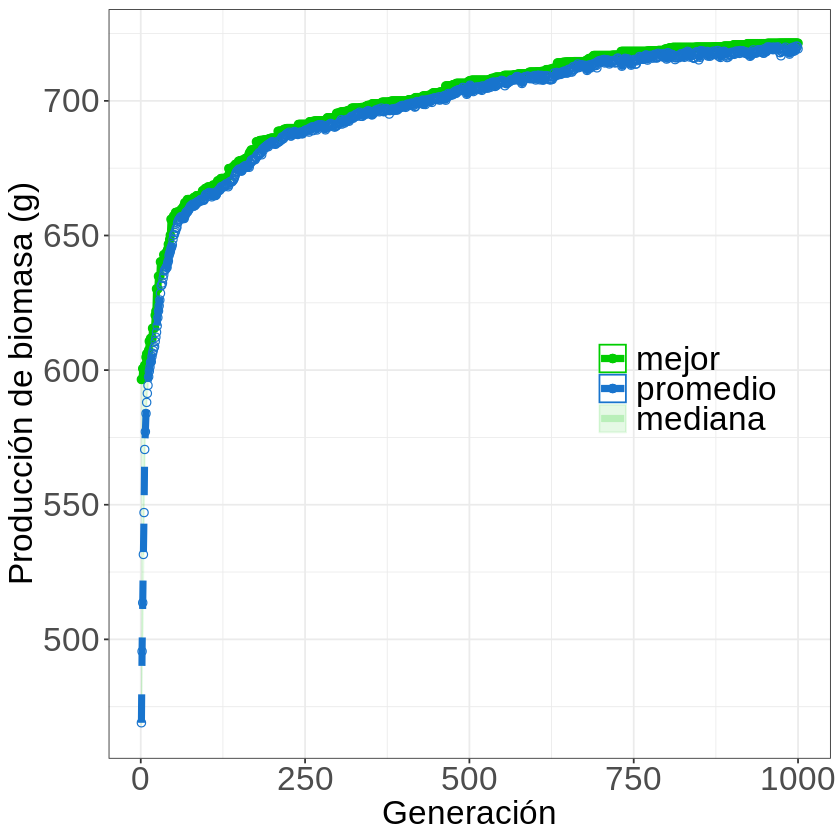

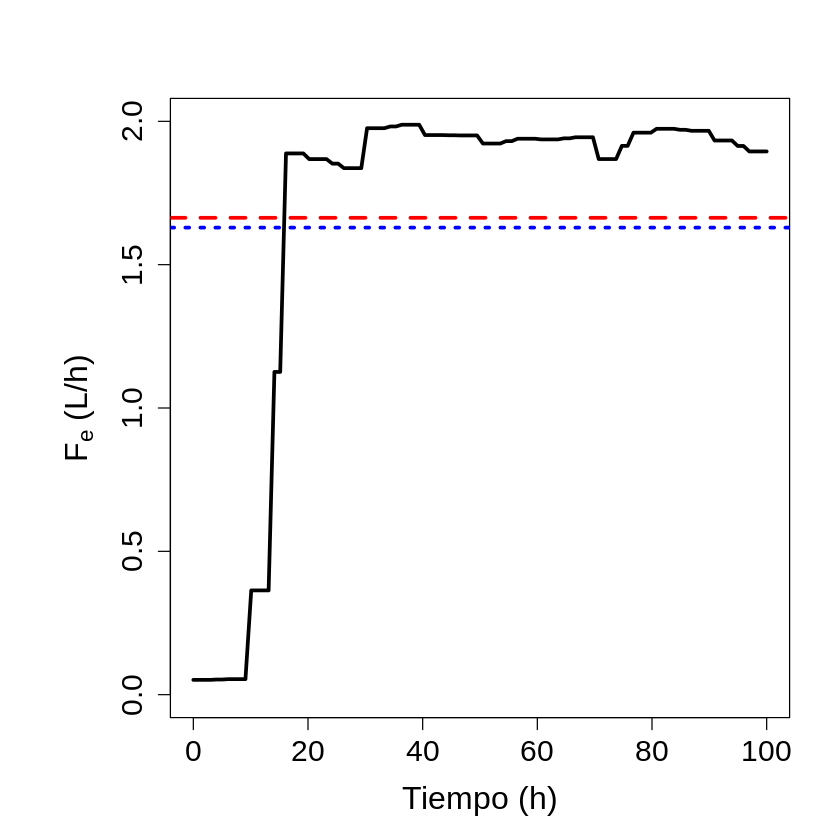

In [151]:
out_it_opt <- show_results2(GA_it,GA_it_const,p_it)

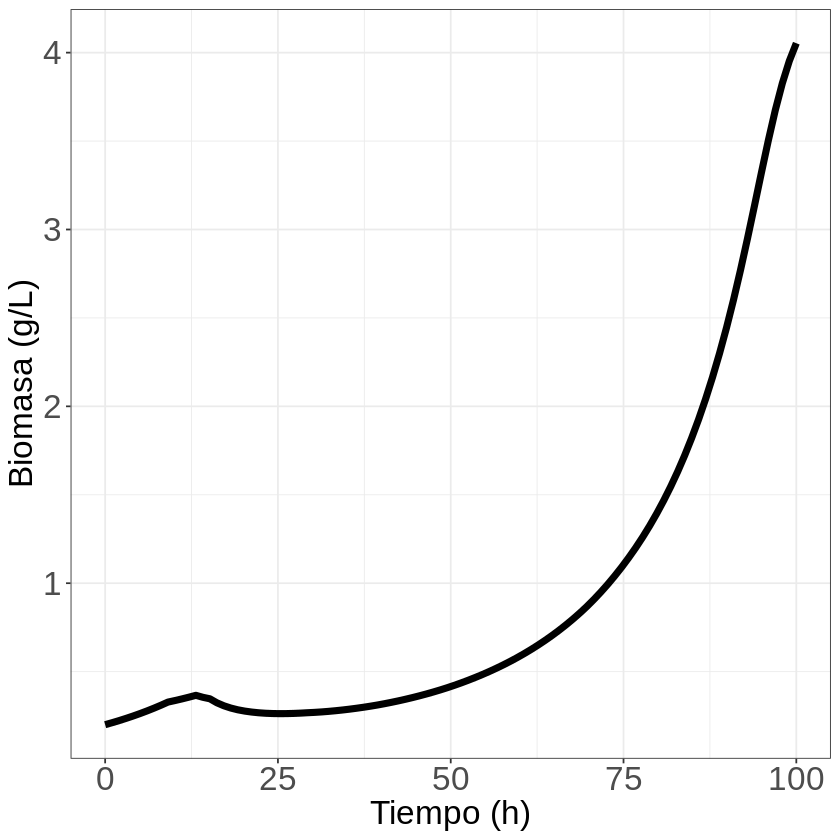

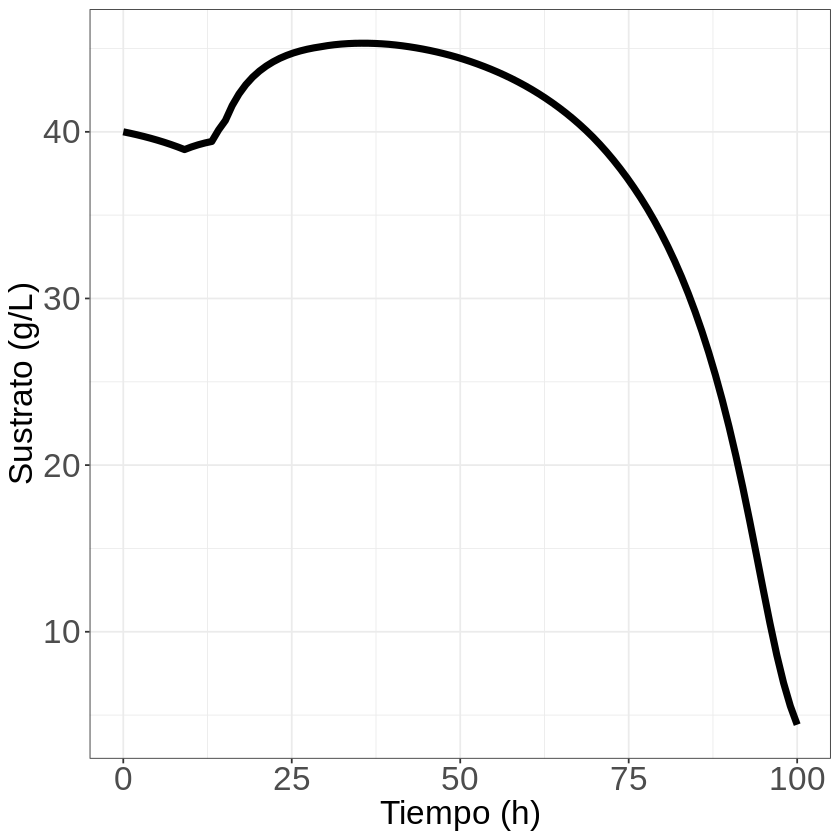

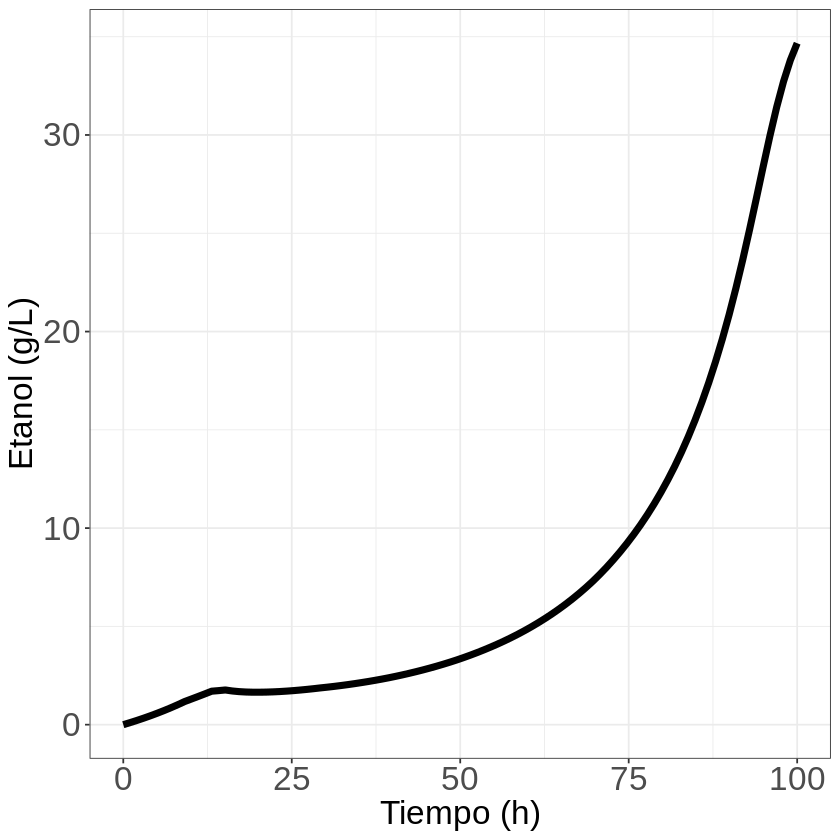

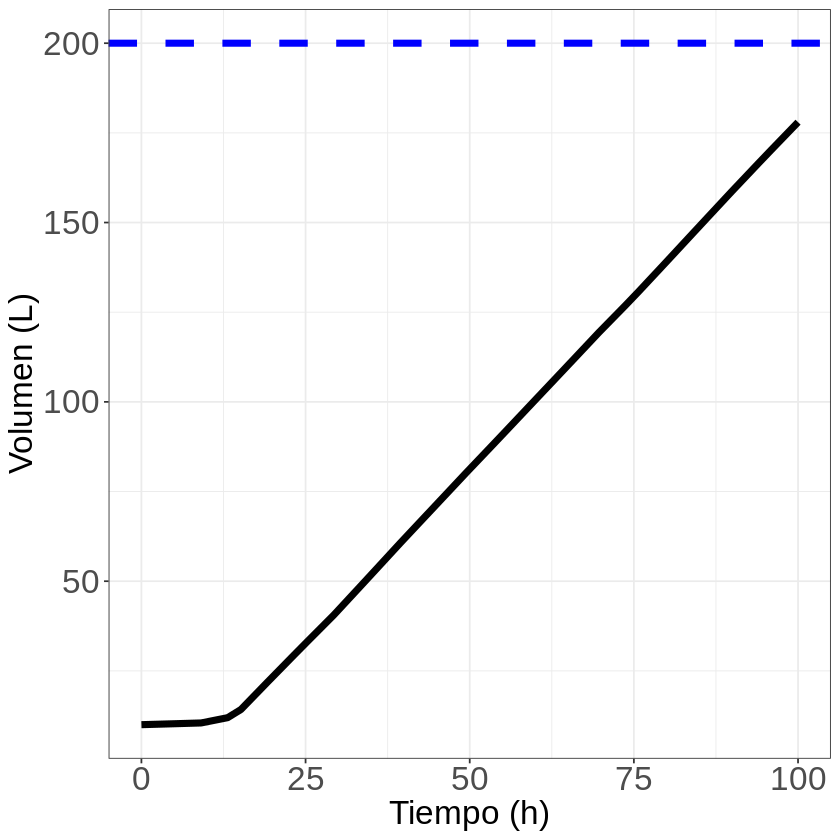

times     x        s         p        V        Fe      
95   94.94949 3.321035 12.554786 28.38290 168.3927 1.914071
96   95.95960 3.504744 10.514202 29.95974 170.3261 1.914071
97   96.96970 3.676038  8.611708 31.43006 172.2403 1.894999
98   97.97980 3.826977  6.935781 32.72577 174.1544 1.894999
99   98.98990 3.952978  5.537470 33.80756 176.0686 1.894999
100 100.00000 4.053281  4.425223 34.66891 177.9827 1.894999

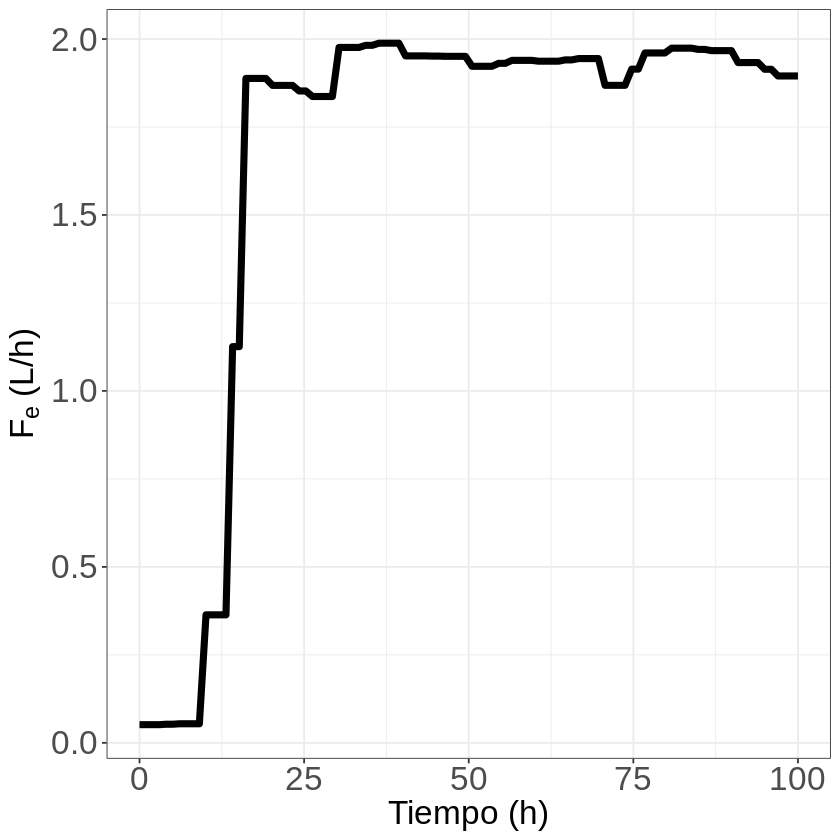

In [96]:
plot_data(out_it_opt)
tail(out_it_opt)

### Optimización del perfil Fin para *Kluyveromyces marxianus*

In [97]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_km <- get_Fin_opt2(p_km, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución: 34.62068

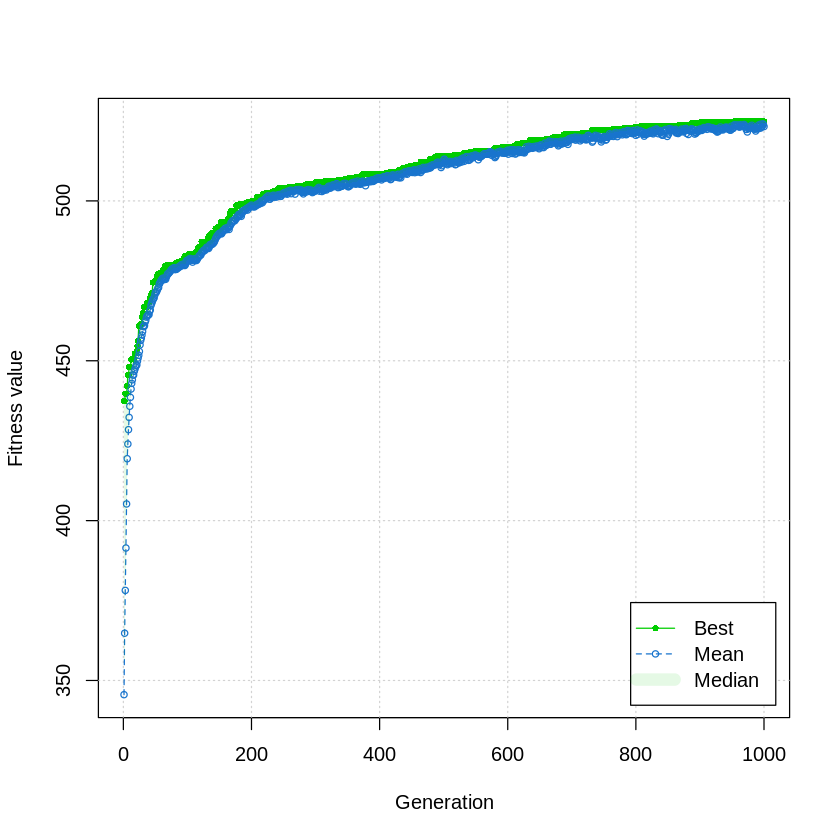

mx_opt: 524.8923 g
mx_opt: 473.2654 g (Fin constante)

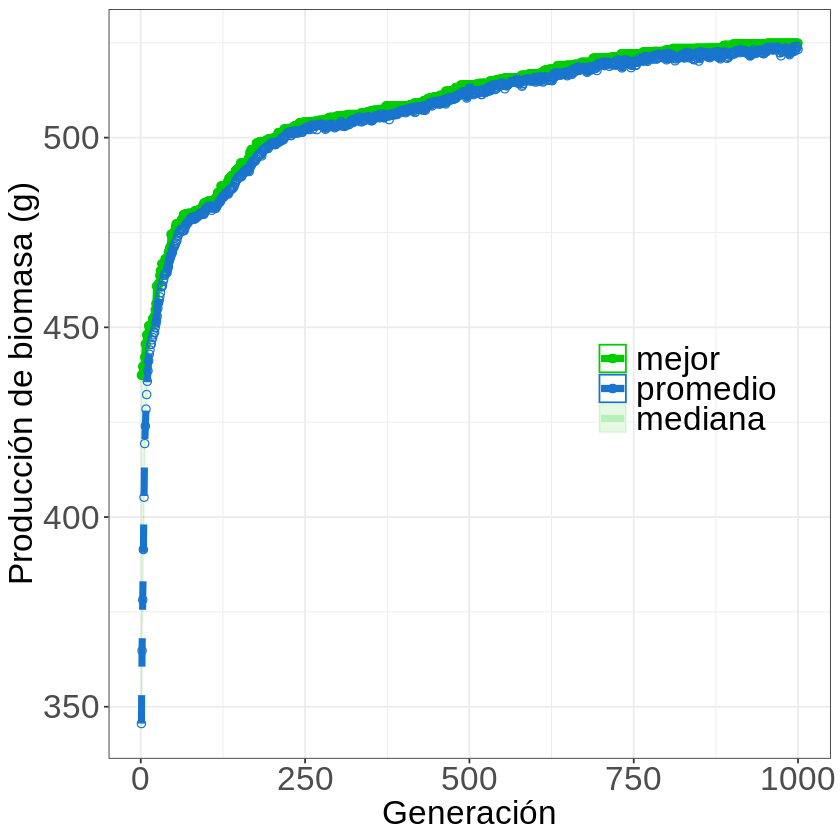

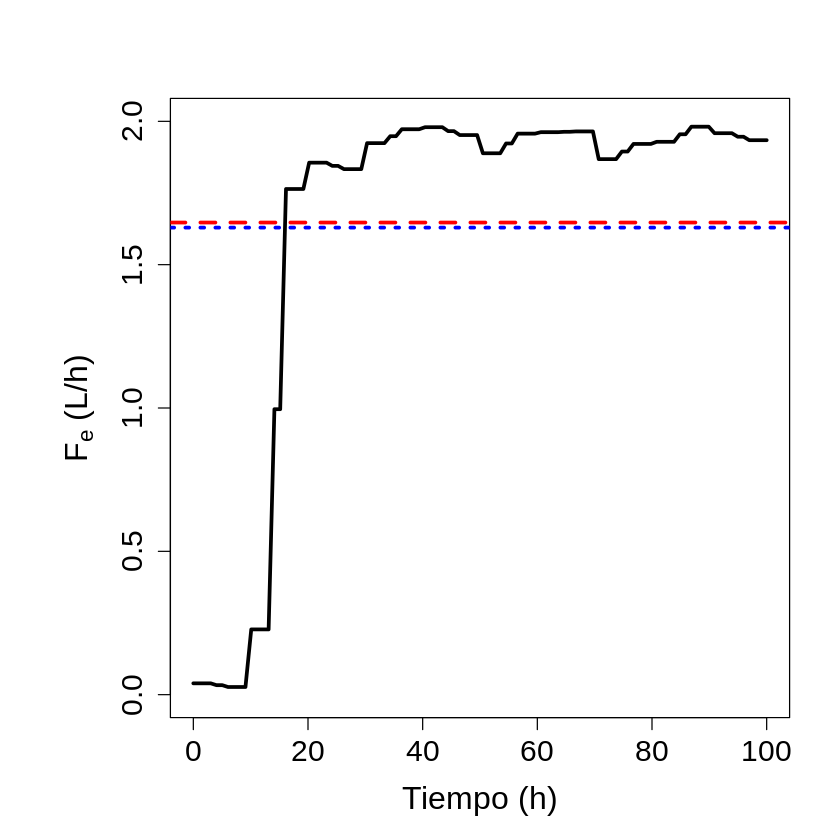

In [152]:
out_km_opt <- show_results2(GA_km,GA_km_const,p_km)

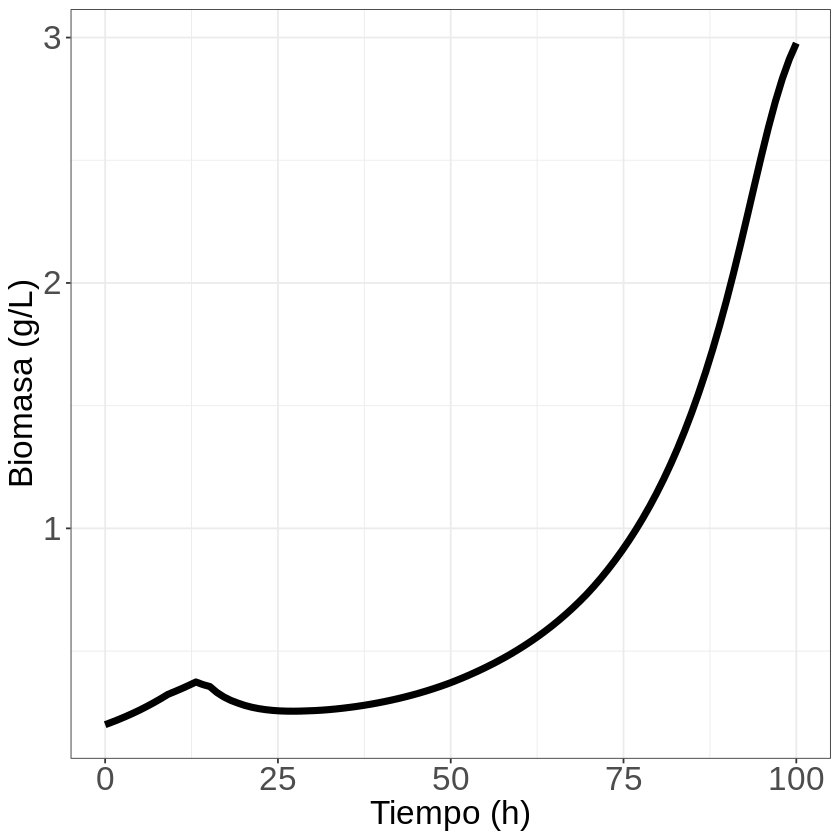

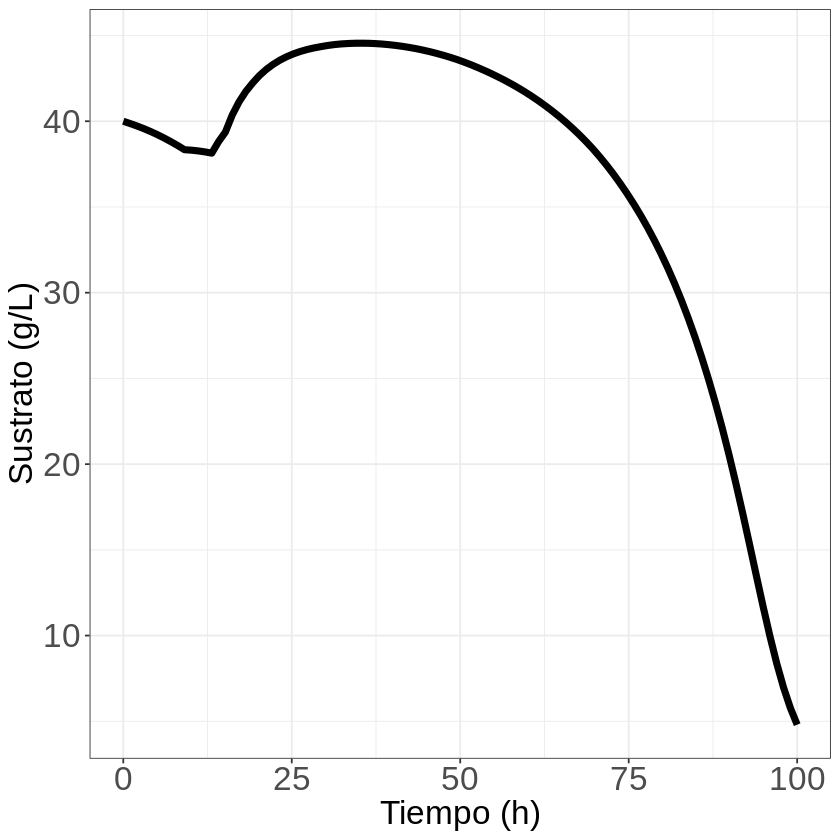

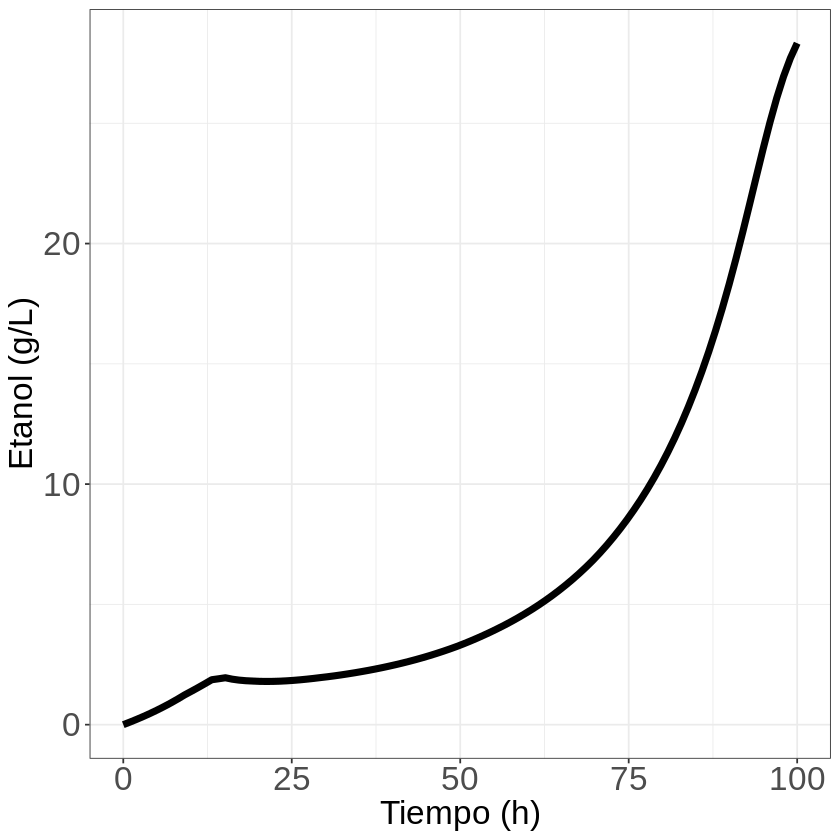

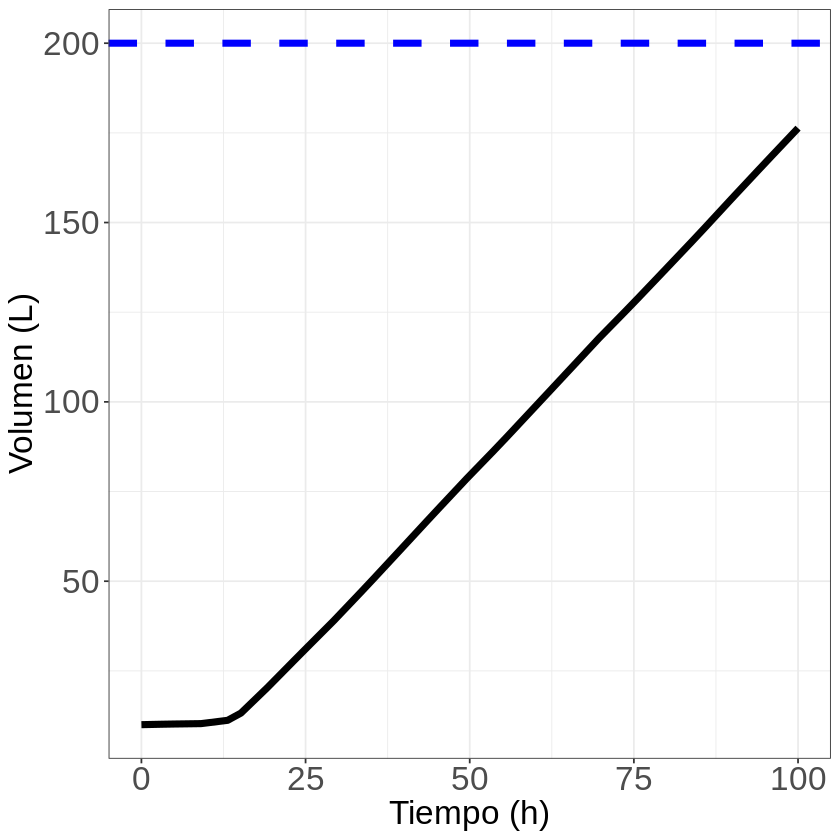

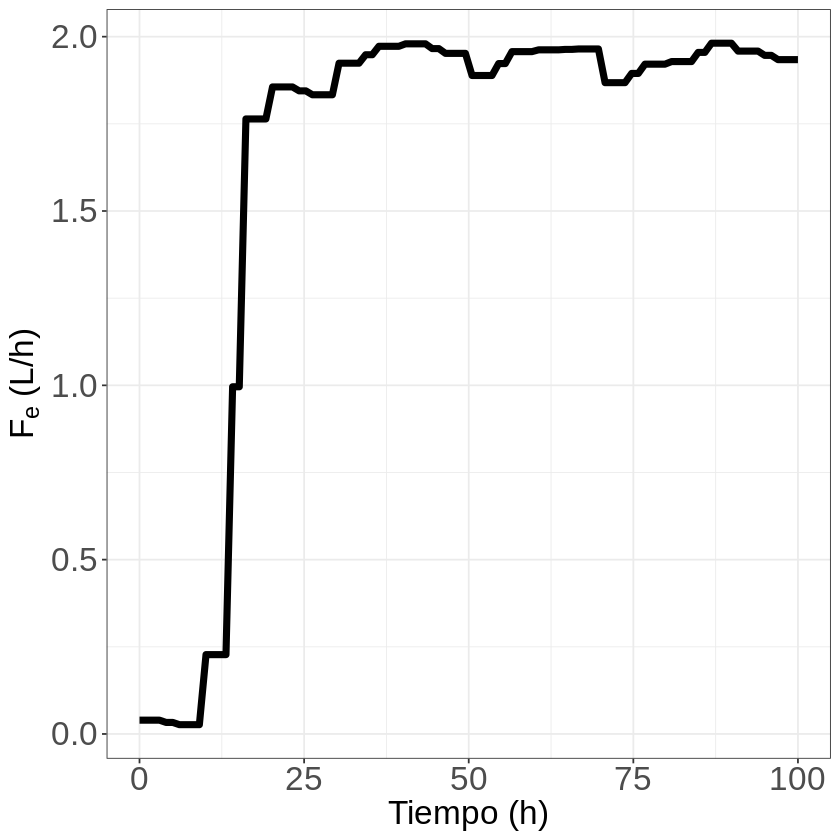

In [99]:
plot_data(out_km_opt)

### Optimización de perfil Fin para *Pichia kluyveri*

In [100]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_pk <- get_Fin_opt2(p_pk, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución: 34.30883

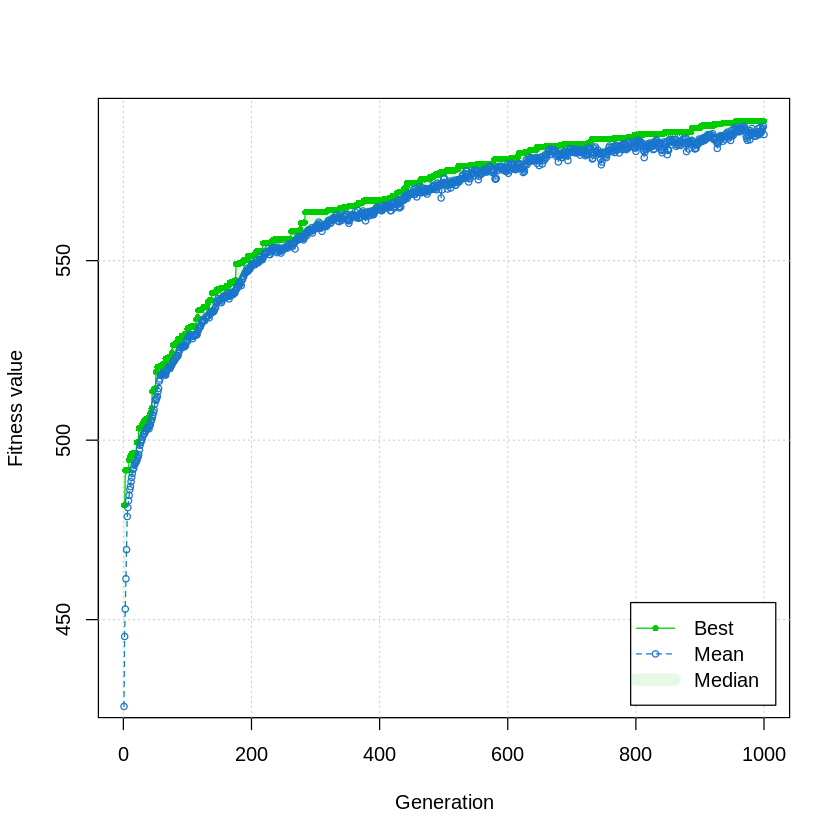

mx_opt: 588.8083 g
mx_opt: 476.4802 g (Fin constante)

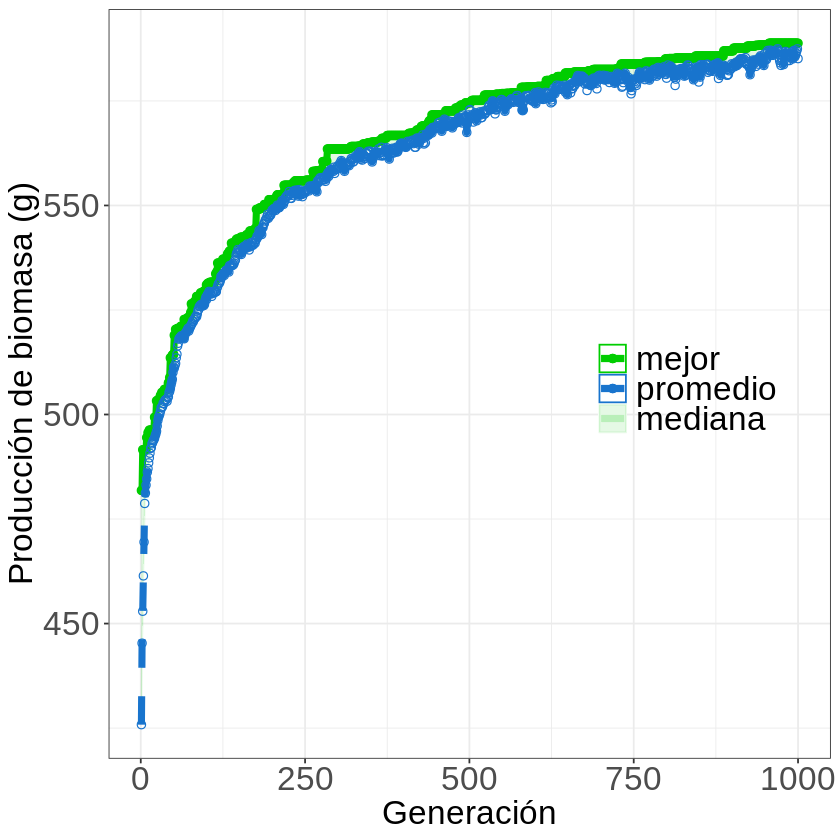

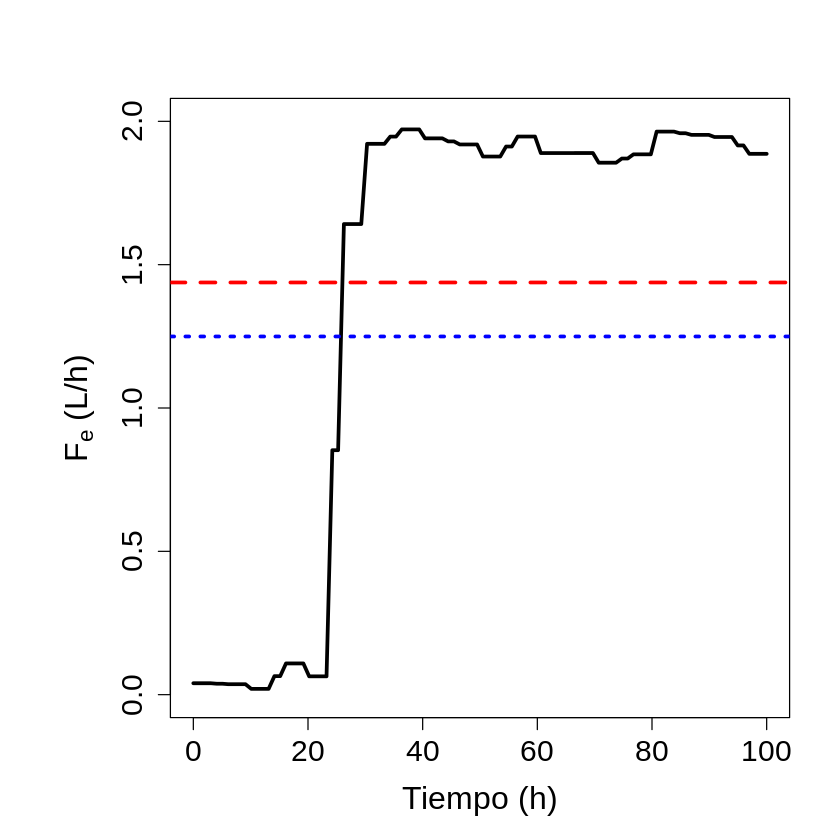

In [153]:
out_pk_opt <- show_results2(GA_pk,GA_pk_const,p_pk)

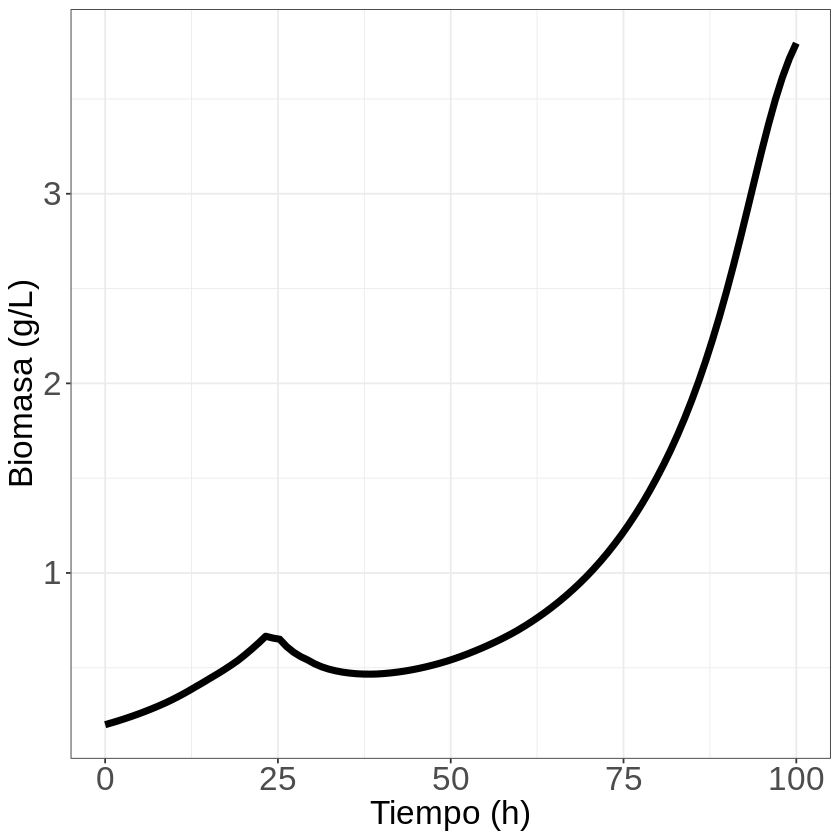

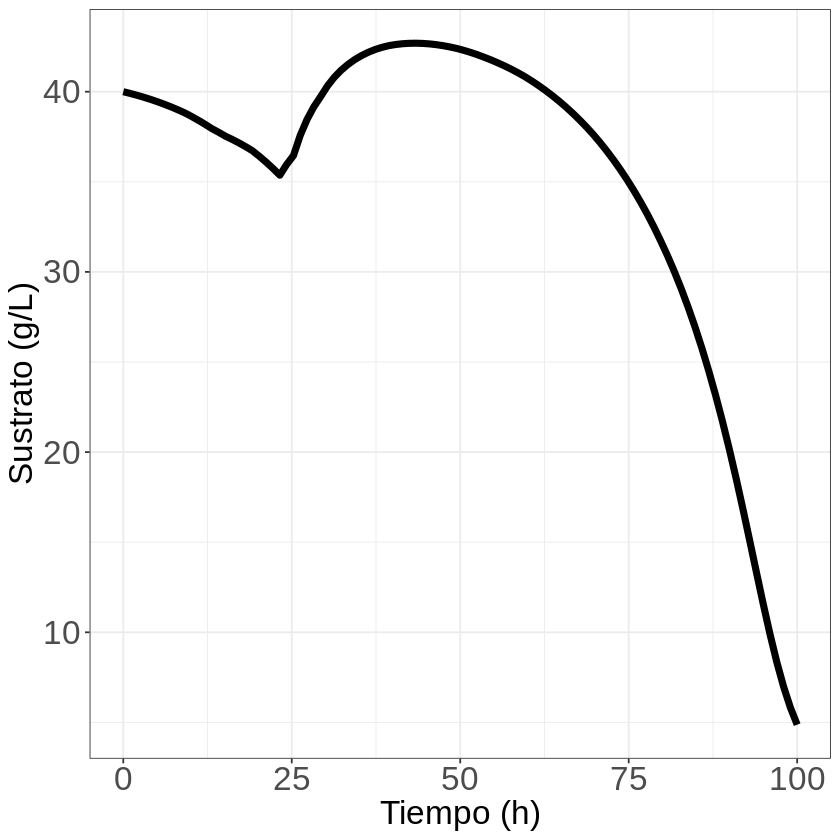

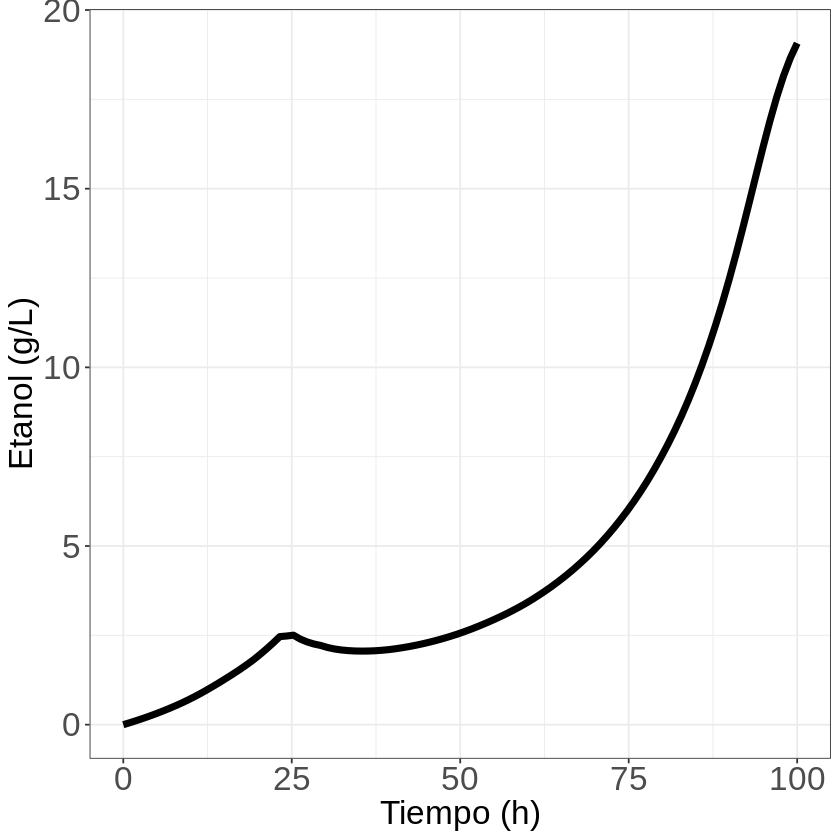

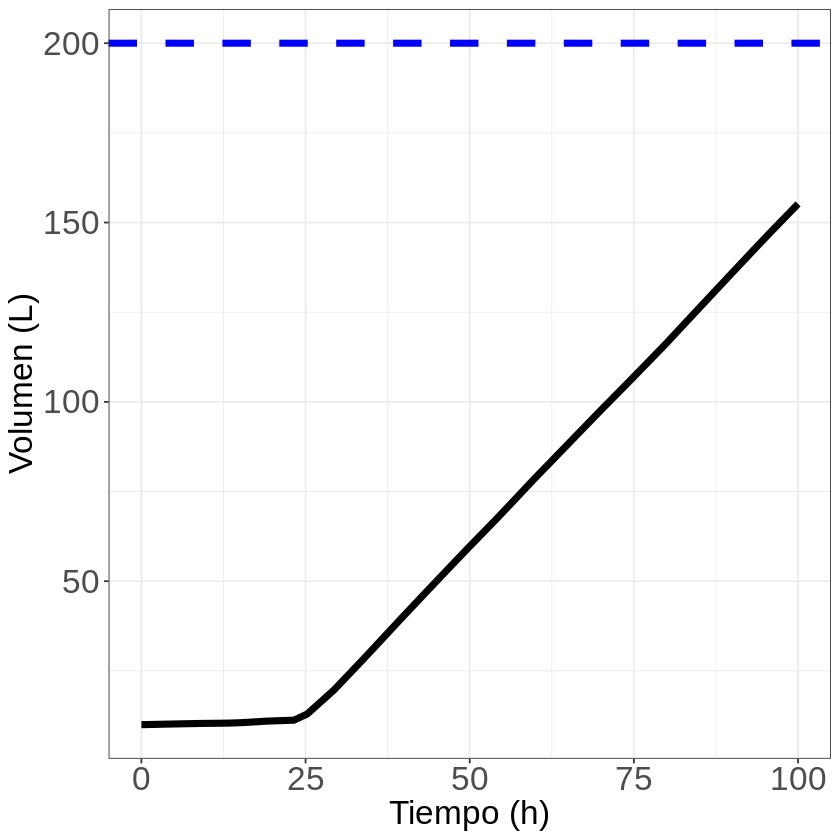

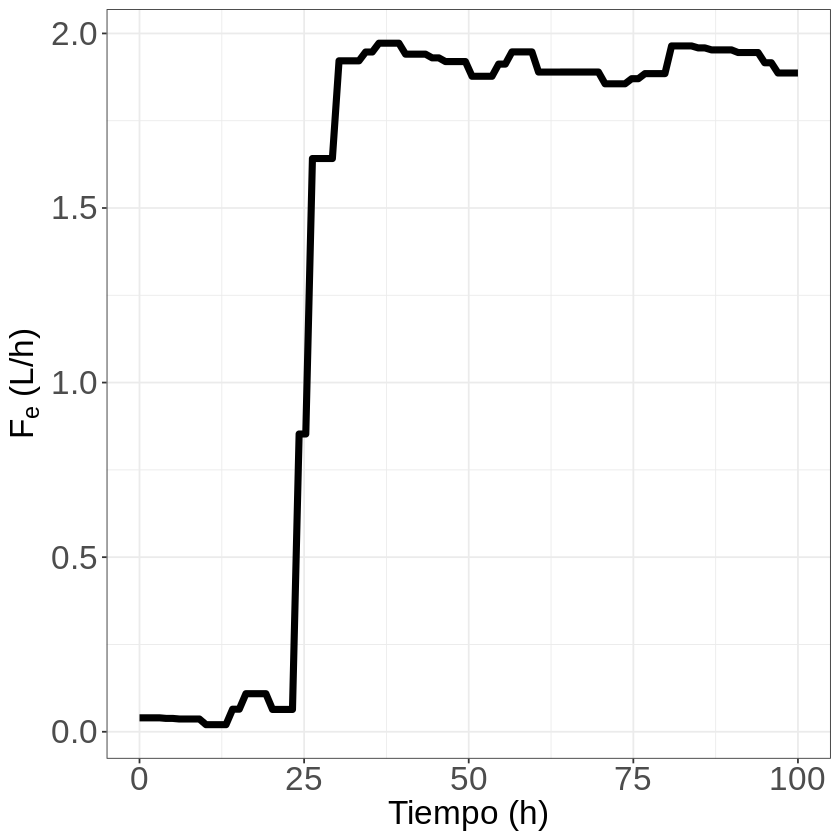

In [102]:
plot_data(out_pk_opt)

### Optimización de perfil Fin para *Zygosaccharomyces bailii*

In [103]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_zb <- get_Fin_opt2(p_zb, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución: 33.92592

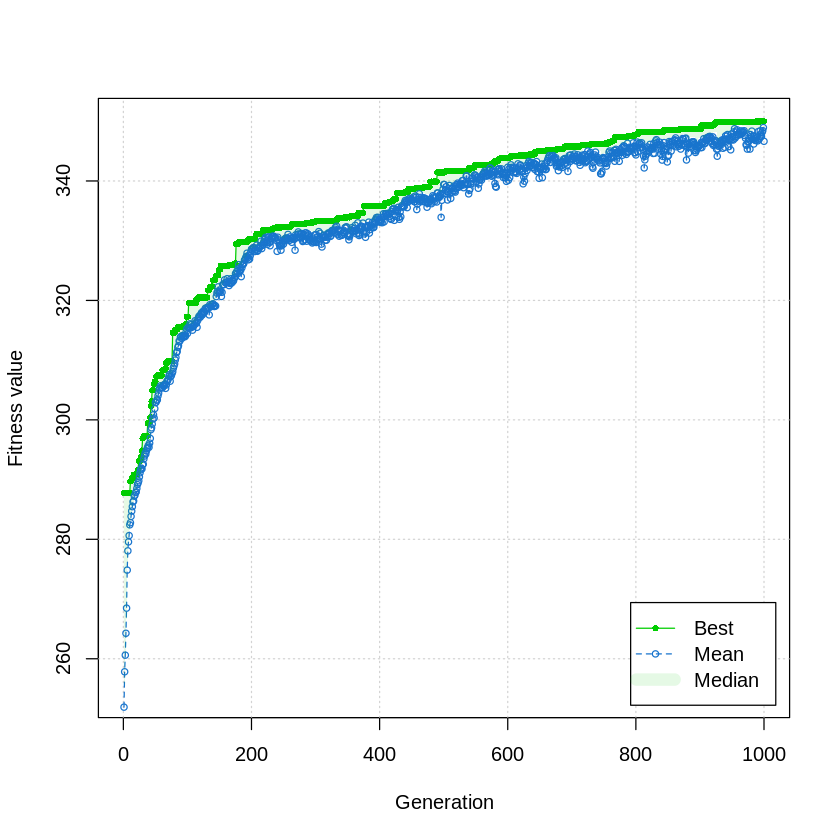

mx_opt: 349.9873 g
mx_opt: 258.3015 g (Fin constante)

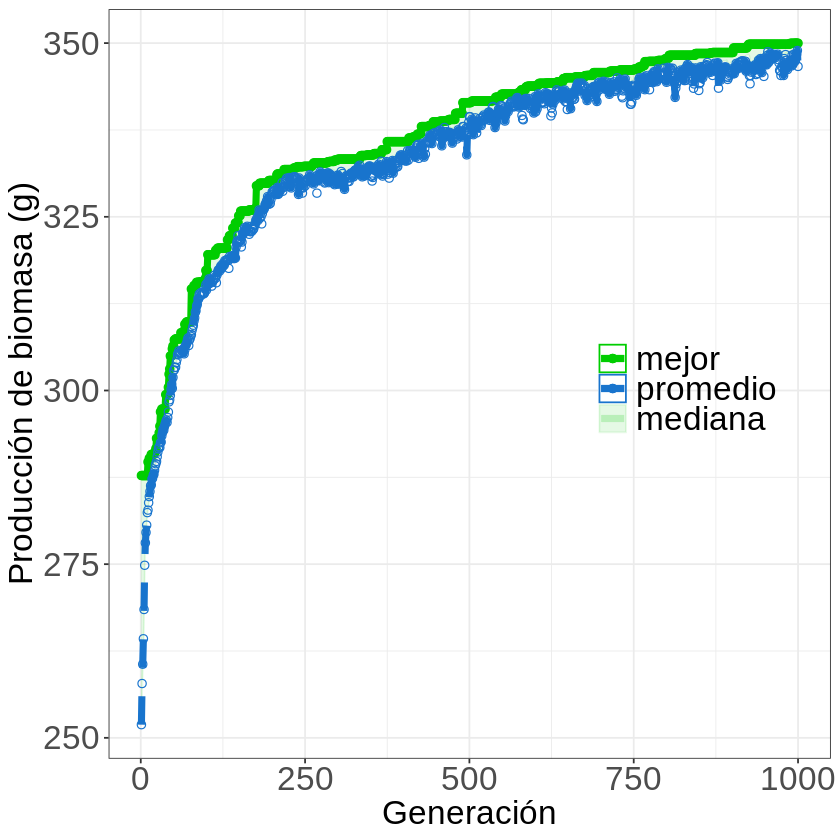

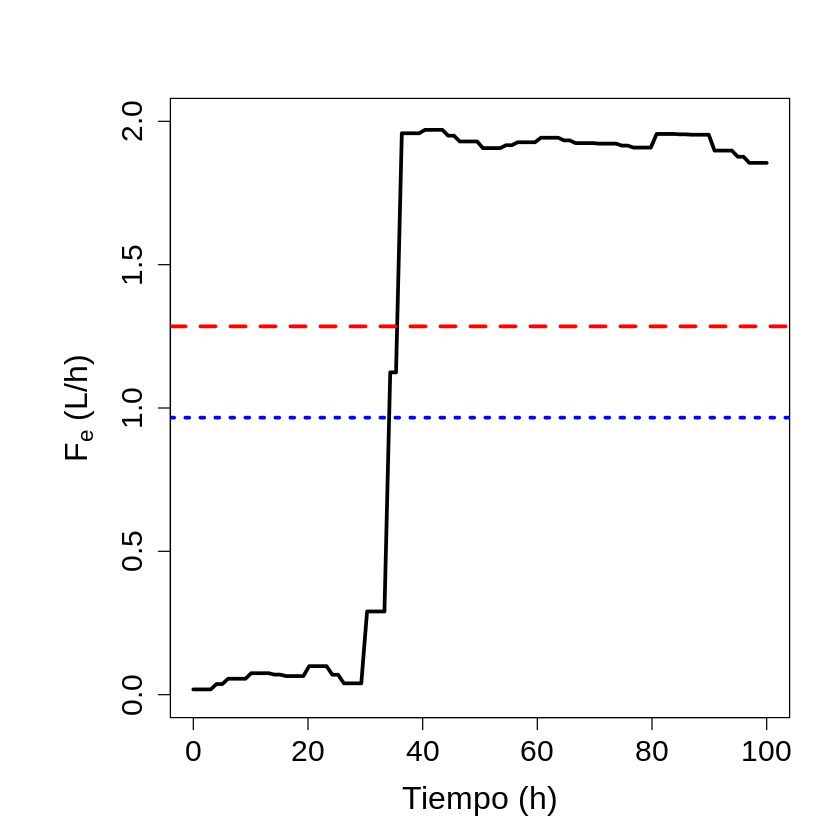

In [154]:
out_zb_opt <- show_results2(GA_zb, GA_zb_const, p_zb)

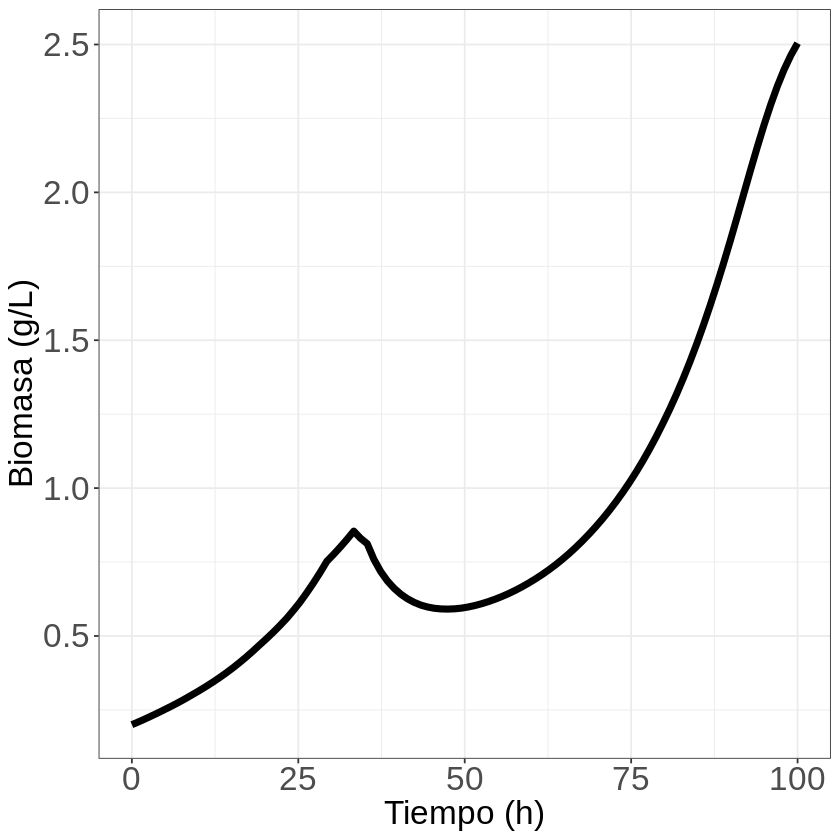

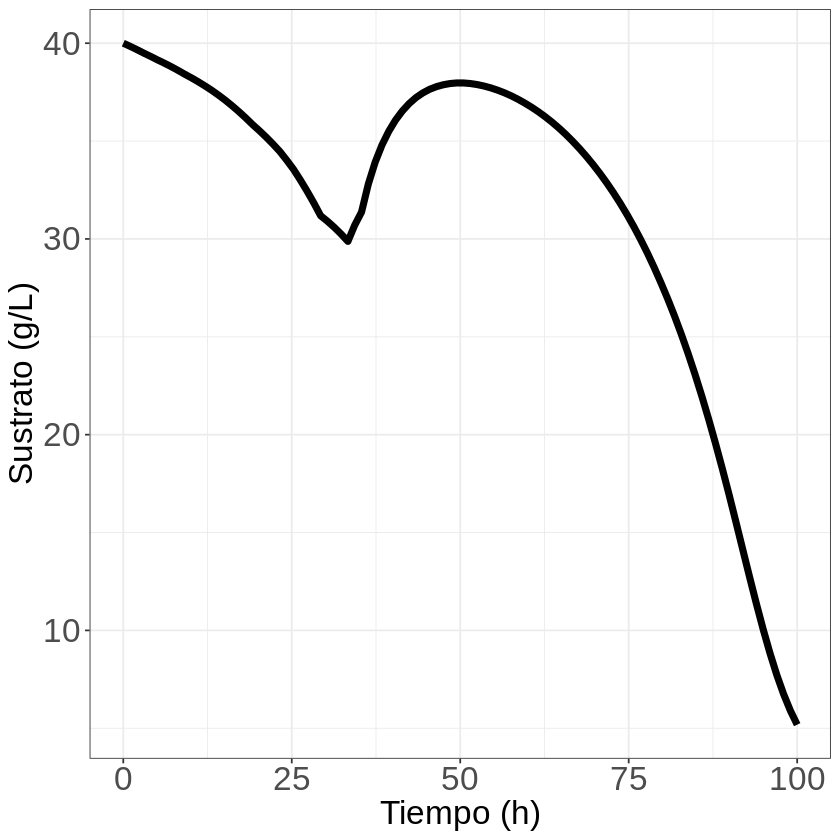

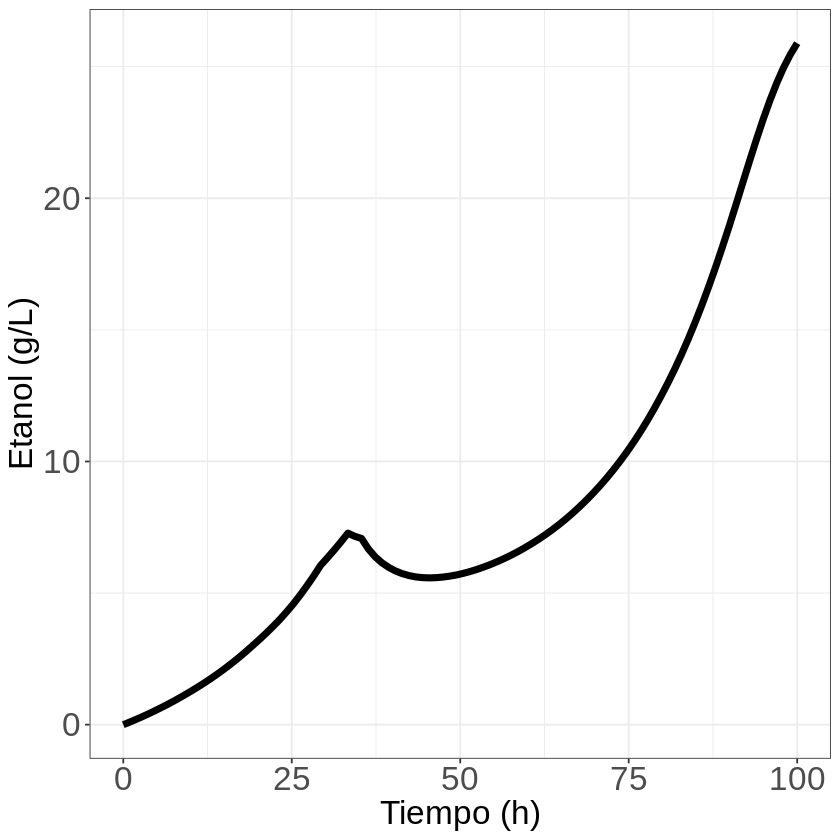

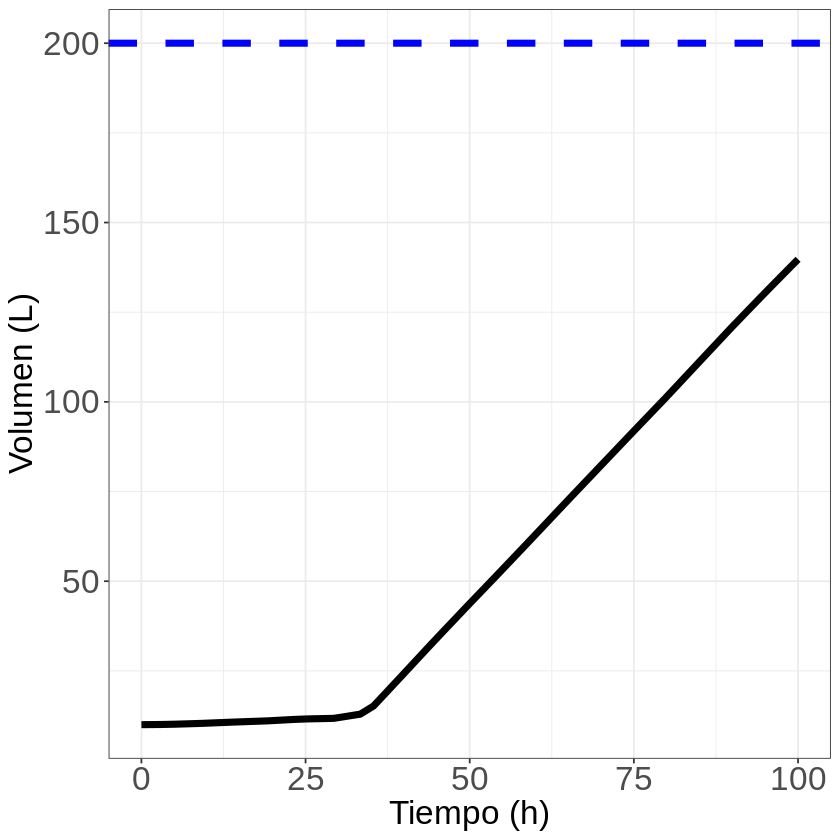

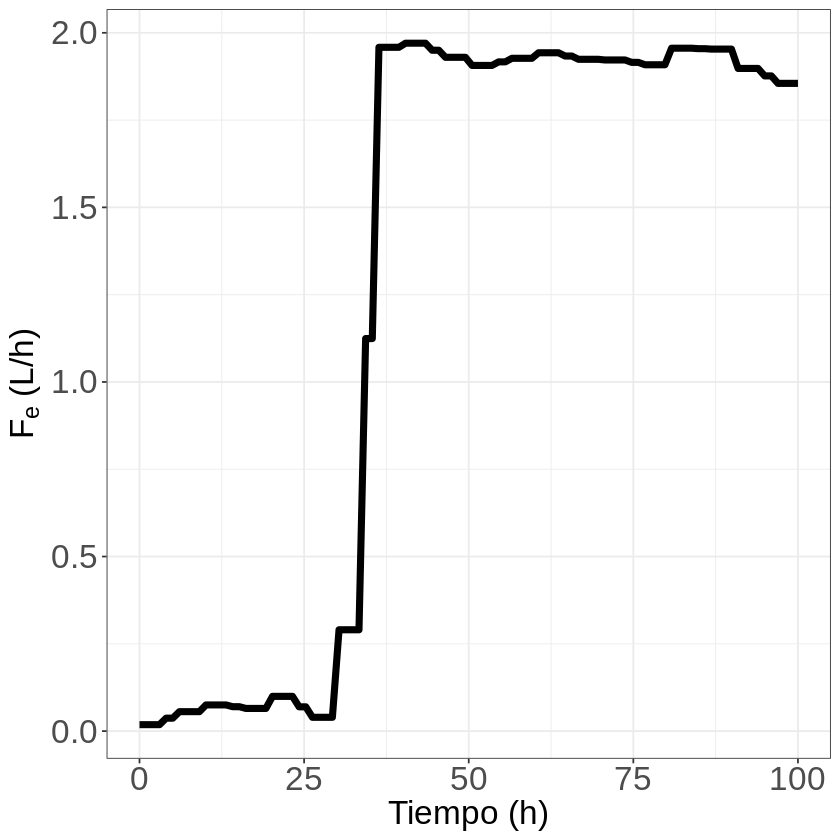

In [105]:
plot_data(out_zb_opt)

### Optimización de Fin para *Zygosaccharomyces rouxi*

In [106]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_zr <- get_Fin_opt2(p_zr, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución: 30.11611

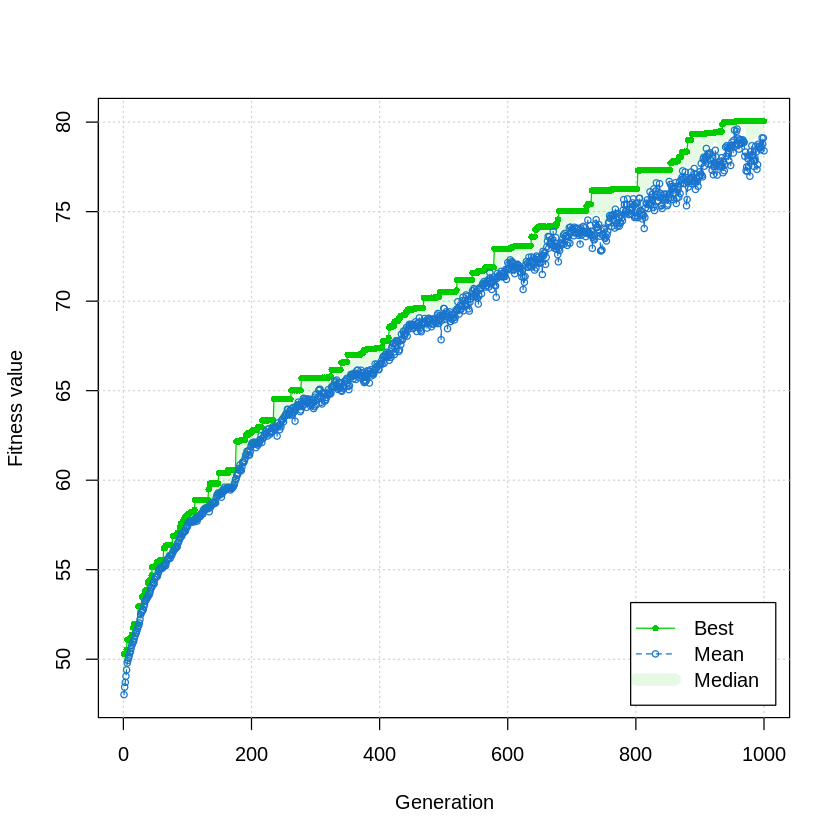

mx_opt: 80.04243 g
mx_opt: 76.02821 g (Fin constante)

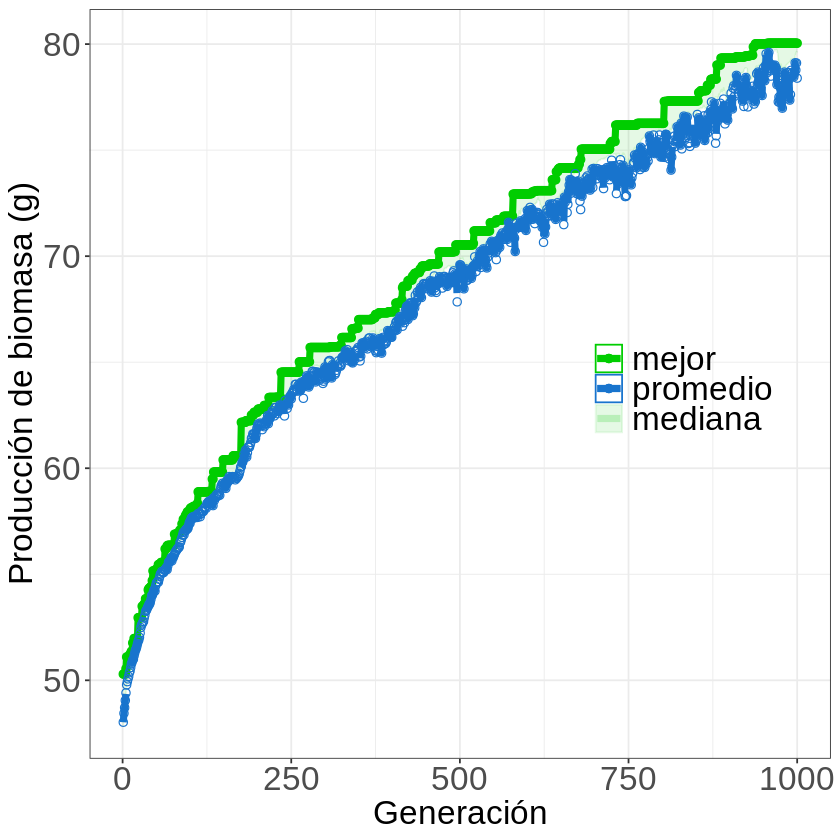

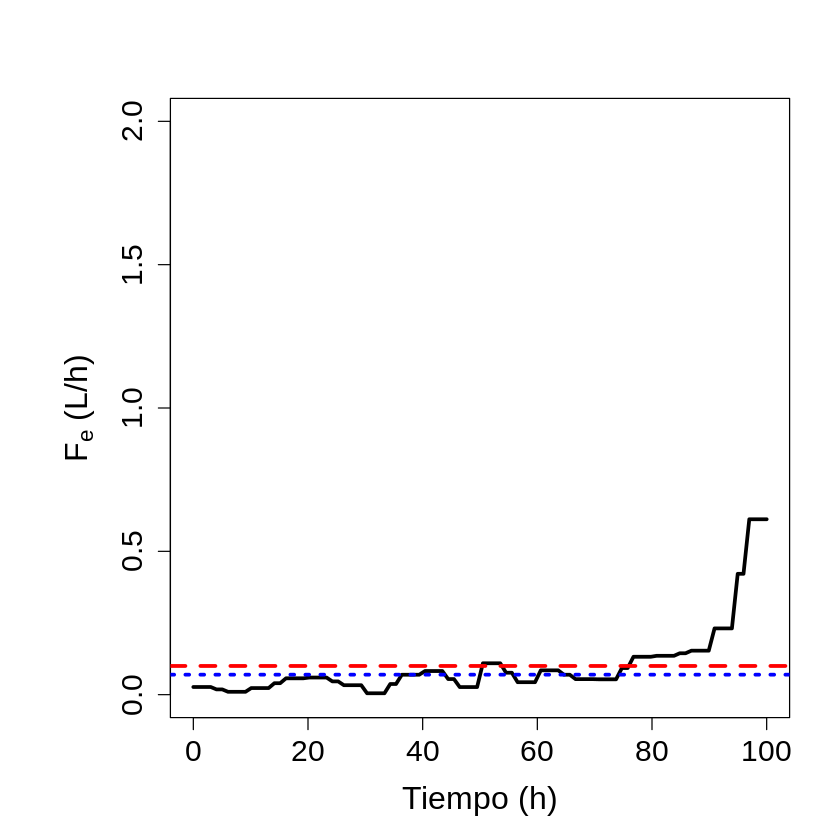

In [155]:
out_zr_opt <- show_results2(GA_zr,GA_zr_const,p_zr)

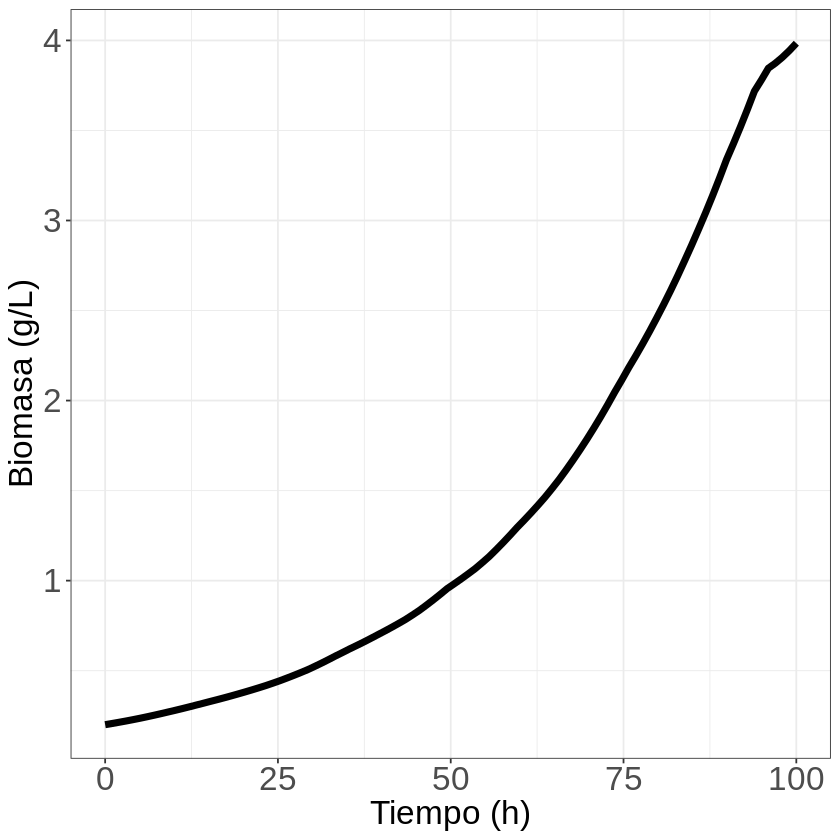

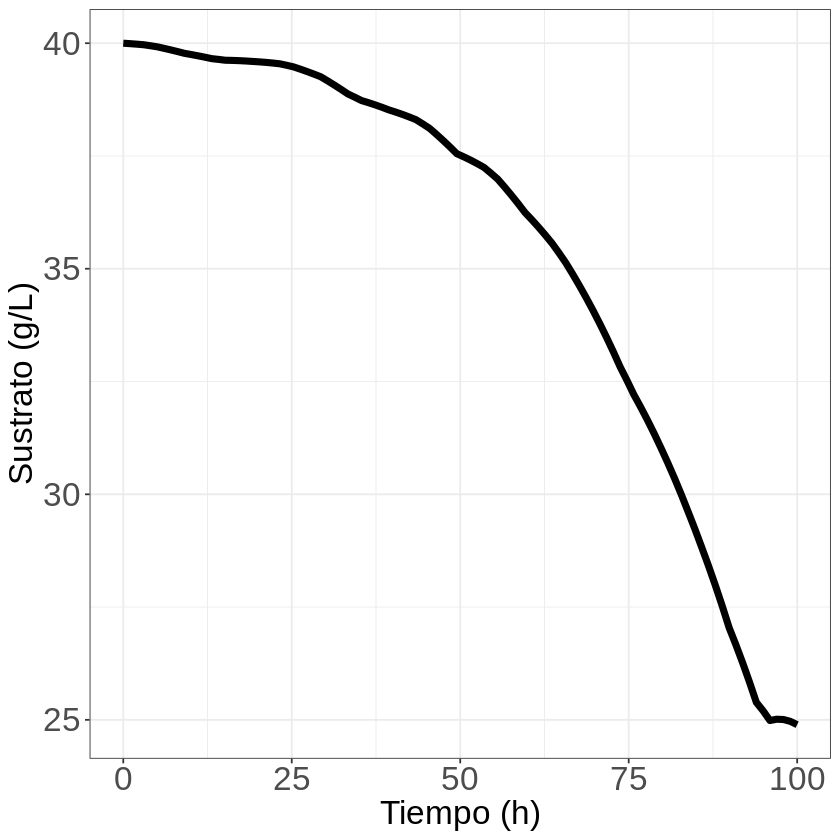

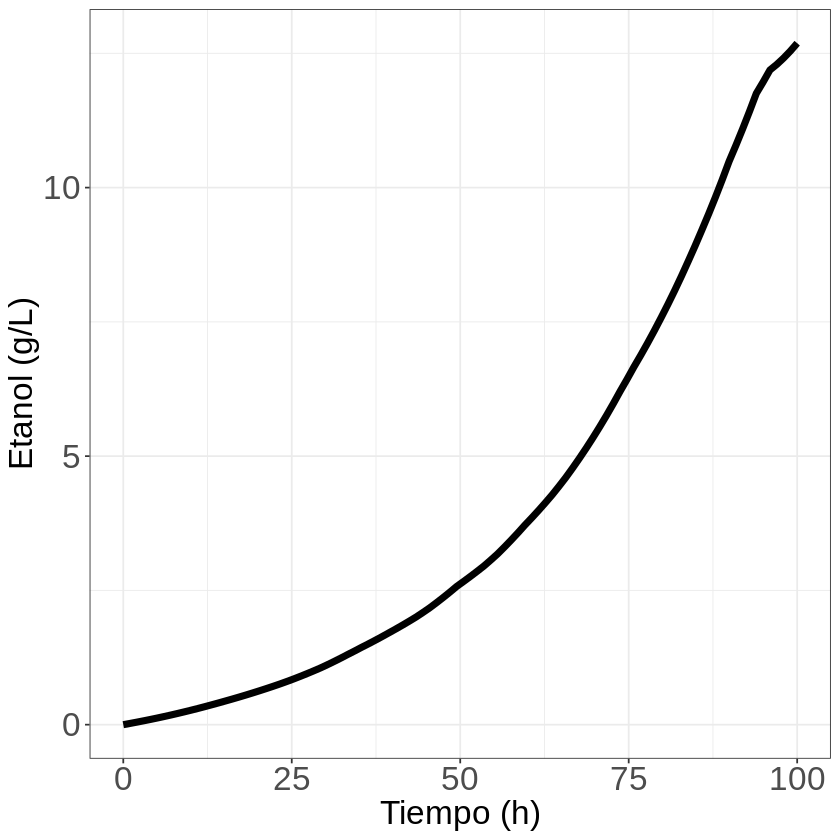

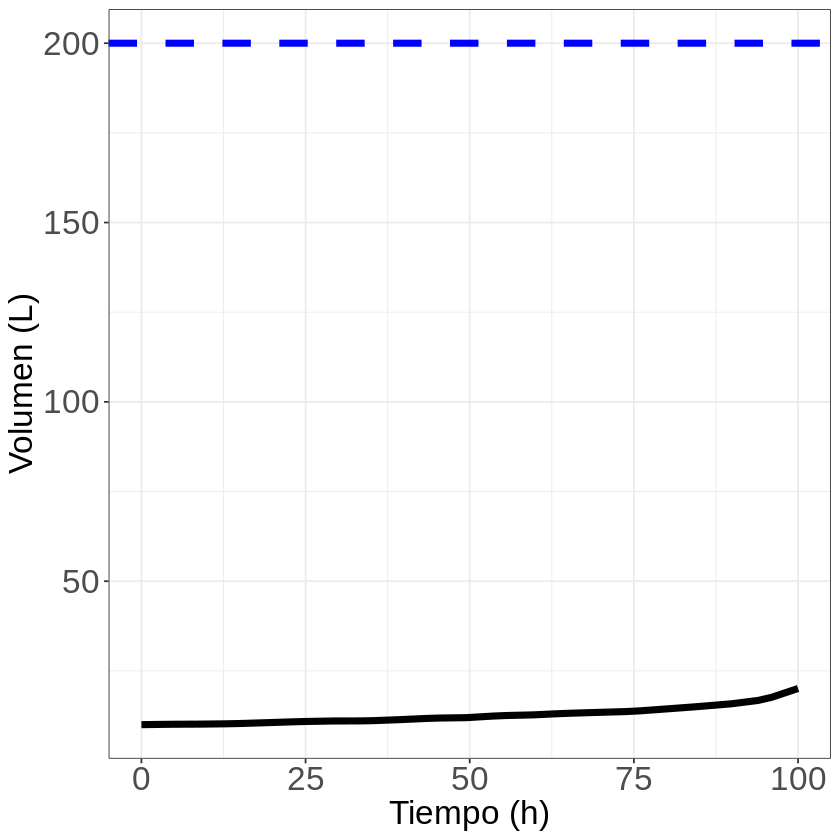

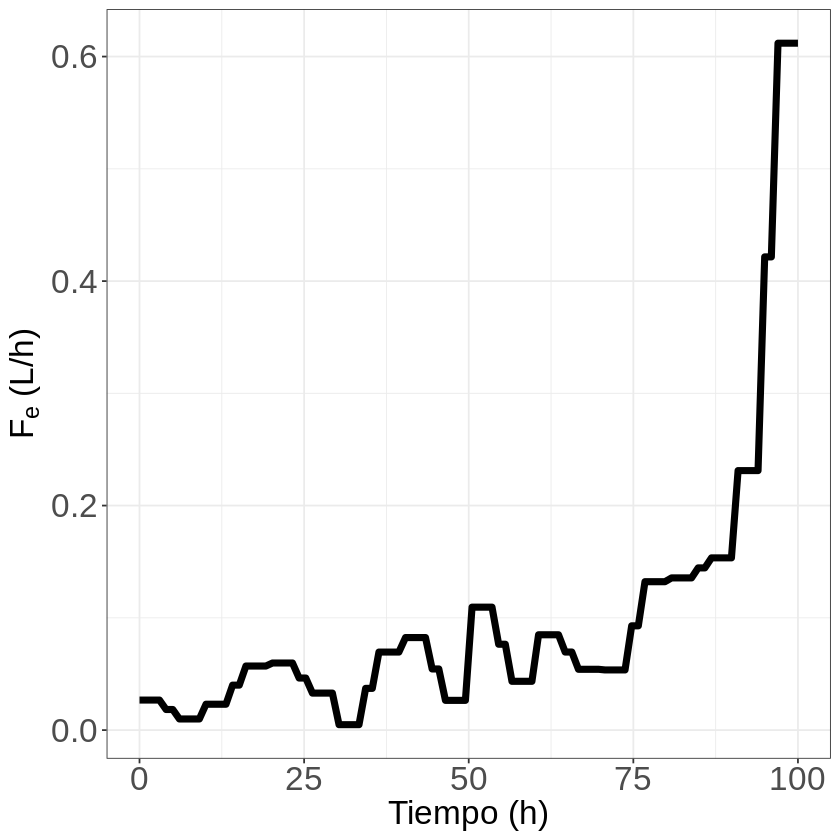

In [108]:
plot_data(out_zr_opt)

# Resultados 

|levadura |	$F_{e}$ constante	|	$F_{e}$ variable	|	$F_{e}$ constant |	$F_{e}$ variable	|
|:---:|:---:|:---:|:---:|:---:|
| |	$F_{e}^{opt}$ 	|	$m_x^{opt}$	|	$F_{e}$ promedio |	$m_x^{opt}$	|
| IT | 1.62926 L/h | 651.711 g | 1.663 L/h | 721.4138 g |
| KM | 1.62926 L/h | 473.2654 g | 1.6469 L/h | 524.8923 g |
| PK | 1.249466 L/h | 476.4802 g | 1.4378 L/h | 588.8083 g |
| ZB | 0.9663 L/h | 258.3015 g | 1.2847 L/h | 349.9873 g |
| ZR | 0.069749 L/h | 76.02821 g | 0.10013 L/h | 80.0424 g |

In [109]:
# @title máxima producción de biomasa generada con Fe constante 
cat("IT: \n")
cat("Fin_opt:", GA_it_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_it_const@fitnessValue, "g","\n")
cat("KM: \n")
cat("Fin_opt:", GA_km_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_km_const@fitnessValue, "g","\n")
cat("PK: \n")
cat("Fin_opt:", GA_pk_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_pk_const@fitnessValue, "g","\n")
cat("ZB: \n")
cat("Fin_opt:", GA_zb_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zb_const@fitnessValue, "g","\n")
cat("ZR: \n")
cat("Fin_opt:", GA_zr_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zr_const@fitnessValue, "g","\n")


IT: 
Fin_opt: 1.62926  L/h 
mx_opt: 651.7111 g 
KM: 
Fin_opt: 1.62926  L/h 
mx_opt: 473.2654 g 
PK: 
Fin_opt: 1.249466  L/h 
mx_opt: 476.4802 g 
ZB: 
Fin_opt: 0.9663353  L/h 
mx_opt: 258.3015 g 
ZR: 
Fin_opt: 0.06974961  L/h 
mx_opt: 76.02821 g 


In [110]:
# @title máxima producción de biomasa generada con el perfil Fe 
cat("IT: \n")
cat("Fin_opt_avg:", mean(GA_it@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_it@fitnessValue, "g","\n")
cat("KM: \n")
cat("Fin_opt_avg:", mean(GA_km@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_km@fitnessValue, "g","\n")
cat("PK: \n")
cat("Fin_opt_avg:", mean(GA_pk@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_pk@fitnessValue, "g","\n")
cat("ZB: \n")
cat("Fin_opt_avg:", mean(GA_zb@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zb@fitnessValue, "g","\n")
cat("ZR: \n")
cat("Fin_opt_avg:", mean(GA_zr@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zr@fitnessValue, "g","\n")

IT: 
Fin_opt_avg: 1.663545  L/h 
mx_opt: 721.4138 g 
KM: 
Fin_opt_avg: 1.646966  L/h 
mx_opt: 524.8923 g 
PK: 
Fin_opt_avg: 1.437852  L/h 
mx_opt: 588.8083 g 
ZB: 
Fin_opt_avg: 1.284754  L/h 
mx_opt: 349.9873 g 
ZR: 
Fin_opt_avg: 0.1001383  L/h 
mx_opt: 80.04243 g 


In [111]:
data_Fe <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(GA_it_const@fitnessValue,GA_km_const@fitnessValue,GA_pk_const@fitnessValue,GA_zb_const@fitnessValue,GA_zr_const@fitnessValue))

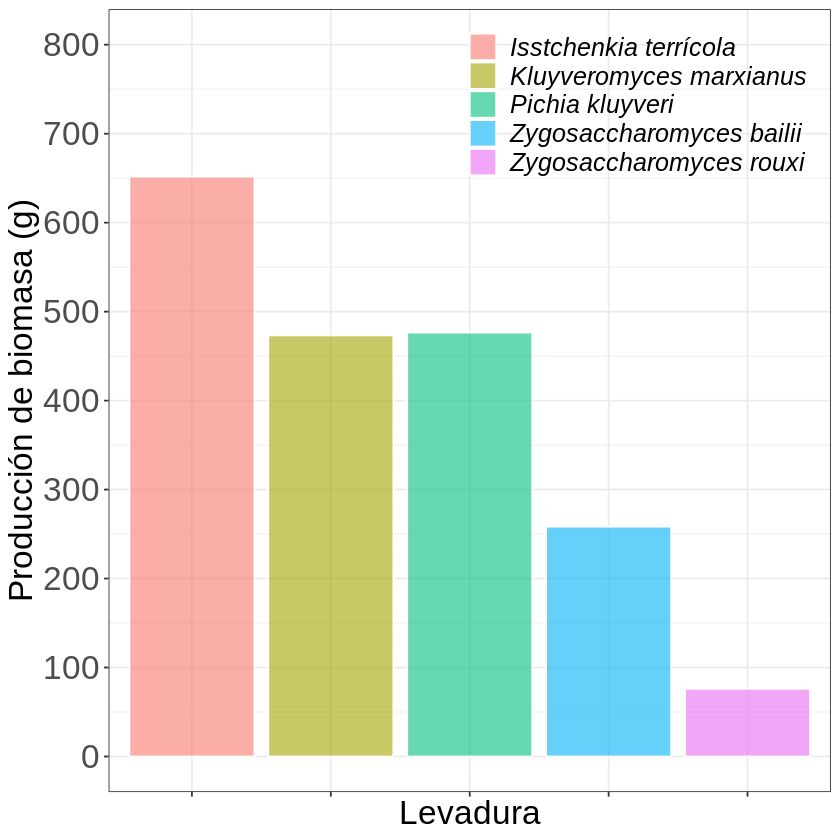

In [112]:
ggplot(data=data_Fe, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Producción de biomasa (g)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  scale_y_continuous(limits = c(0, 800), breaks = seq(0, 800, 100)) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.text.x = element_blank(),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

In [113]:
data_profil <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(GA_it@fitnessValue, GA_km@fitnessValue, GA_pk@fitnessValue, GA_zb@fitnessValue, GA_zr@fitnessValue))

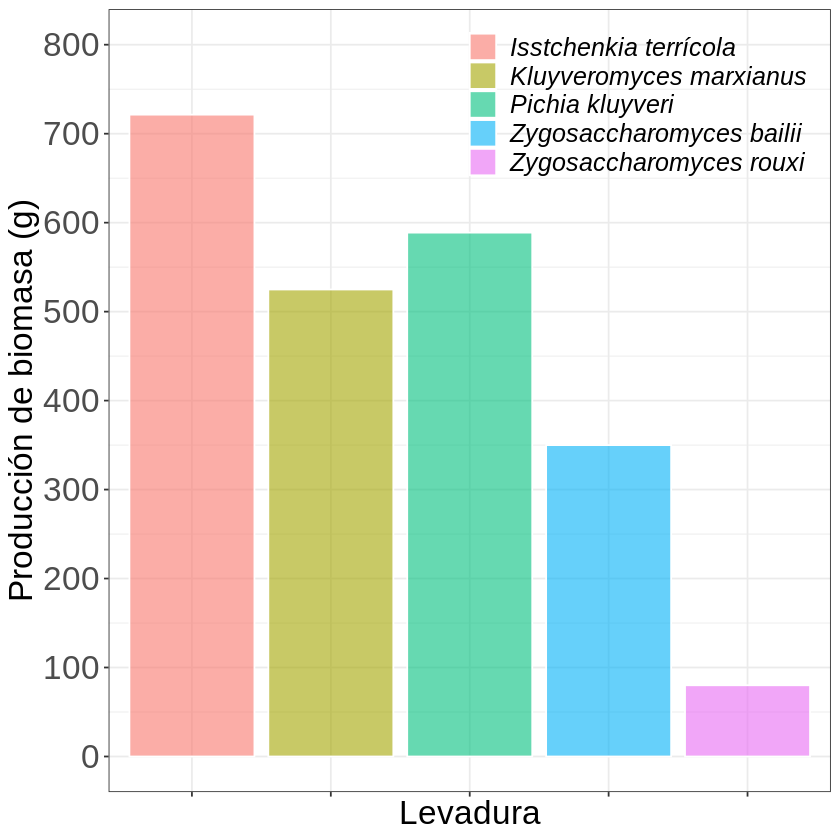

In [114]:
ggplot(data=data_profil, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Producción de biomasa (g)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  scale_y_continuous(limits = c(0, 800), breaks = seq(0, 800, 100)) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x = element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

### Comparación de la producción de biomasa con flujo de alimentación constante

In [115]:
data_mx_time_const <- data.frame(times = rep(out_it_opt_const$time,5), mx = c(out_it_opt_const$x*out_it_opt_const$V,out_km_opt_const$x*out_km_opt_const$V,
                                      out_pk_opt_const$x*out_pk_opt_const$V,out_zb_opt_const$x*out_zb_opt_const$V,out_zr_opt_const$x*out_zr_opt_const$V),
                          lev = rep(c("Isstchenkia terrícola","Kluyveromyces marxianus","Pichia kluyveri",
                          "Zygosaccharomyces bailii","Zygosaccharomyces rouxi"), each = length(out_it_opt_const$time)))

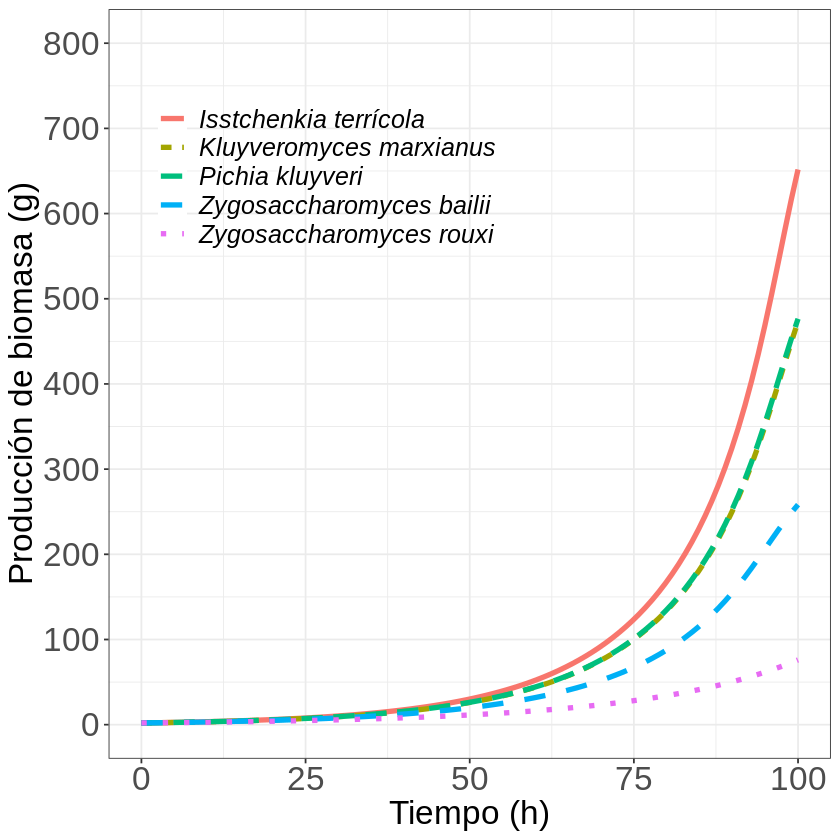

In [116]:
ggplot(data = data_mx_time_const,aes(x = times, y = mx, col = lev, lty = lev))+
    geom_line(lwd = 1.5) +
    ylab("Producción de biomasa (g)") +
    xlab("Tiempo (h)") +
    scale_y_continuous(limits = c(0, 800), breaks = seq(0, 800, 100)) +
    theme_bw() +
    theme( 
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.3, 0.80), 
            legend.background = element_rect(fill=NA))+
            labs(col = "") +
            labs(lty = "")


### Comparación en la producción de biomasa durante la fermentación con flujo de alimentación variable

In [117]:
data_mx_time <- data.frame(times = rep(out_it_opt$times,5), mx = c(out_it_opt$x*out_it_opt$V,out_km_opt$x*out_km_opt$V,
                                      out_pk_opt$x*out_pk_opt$V,out_zb_opt$x*out_zb_opt$V,out_zr_opt$x*out_zr_opt$V),
                          lev = rep(c("Isstchenkia terrícola","Kluyveromyces marxianus","Pichia kluyveri",
                          "Zygosaccharomyces bailii","Zygosaccharomyces rouxi"), each = length(out_it_opt$times)))

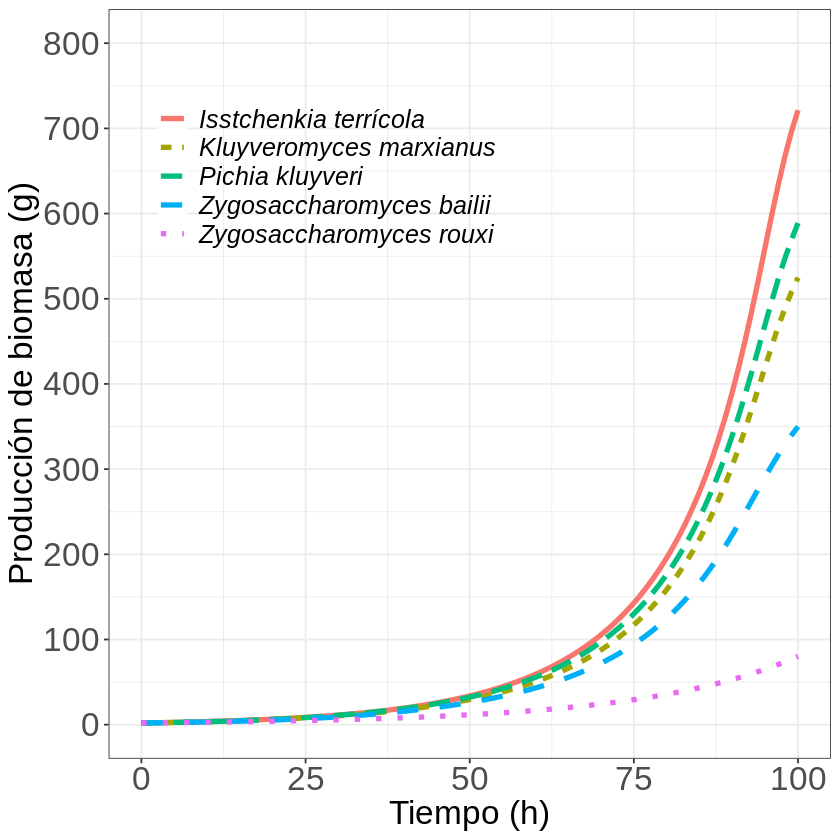

In [118]:
ggplot(data = data_mx_time,aes(x = times, y = mx, col = lev, lty = lev))+
    geom_line(lwd = 1.5) +
    ylab("Producción de biomasa (g)") +
    xlab("Tiempo (h)") +
    scale_y_continuous(limits = c(0, 800), breaks = seq(0, 800, 100)) +
    theme_bw() +
    theme( 
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.3, 0.80), 
            legend.background = element_rect(fill=NA))+
            labs(col = "") +
            labs(lty = "")


### Comparación en el consumo de sustrato durante la fermentación con flujo de alimentación constante

In [136]:
get_substrate <- function(Fe, sf){
    if(length(Fe) > 1) {
        Fe <- modify_Fe(Fe)
        delta_t <- tf/length(times)
        consumed_sub <- sum(Fe*sf*delta_t)
    }
    else {
        consumed_sub <- Fe*sf*tf    
    }
    return(consumed_sub)
}

In [133]:
data_ms_const <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    ms = c(get_substrate(GA_it_const@solution,sf),get_substrate(GA_km_const@solution,sf),get_substrate(GA_pk_const@solution,sf),
                    get_substrate(GA_zb_const@solution,sf),get_substrate(GA_zr_const@solution,sf)))

x1     
[1,] 1.62926

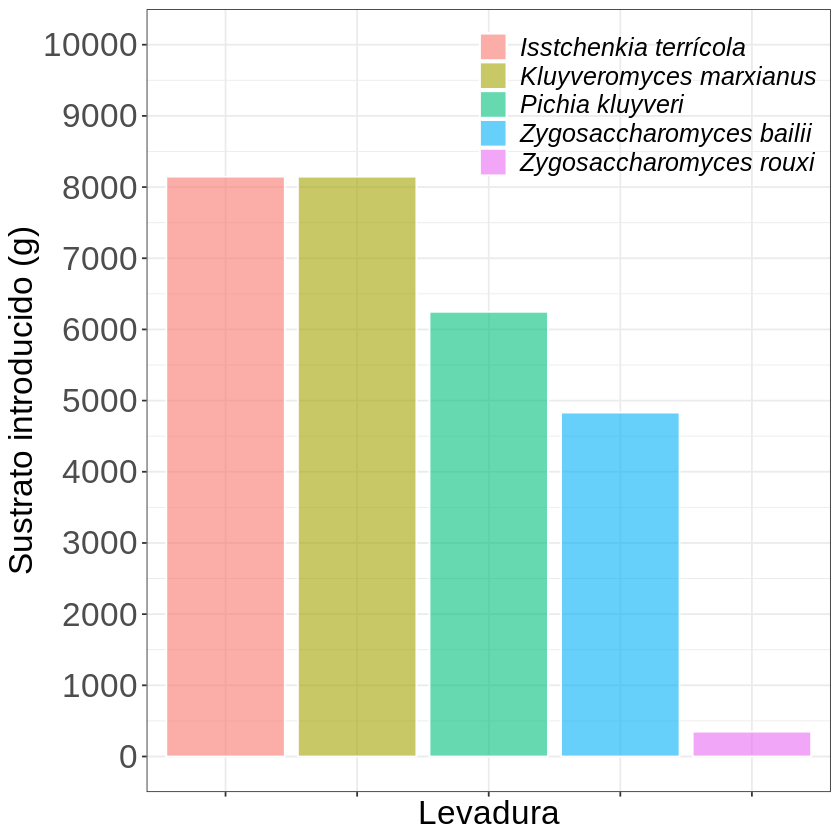

In [140]:
ggplot(data=data_ms_const, aes(x=lev, y=ms, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Sustrato introducido (g)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  scale_y_continuous(limits = c(0, 10000), breaks = seq(0, 10000, 1000)) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x = element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

### Comparación en el consumo de sustrato durante la fermentación con flujo de alimentación variable

In [137]:
data_ms <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    ms = c(get_substrate(GA_it@solution,sf),get_substrate(GA_km@solution,sf),get_substrate(GA_pk@solution,sf),
                    get_substrate(GA_zb@solution,sf),get_substrate(GA_zr@solution,sf)))

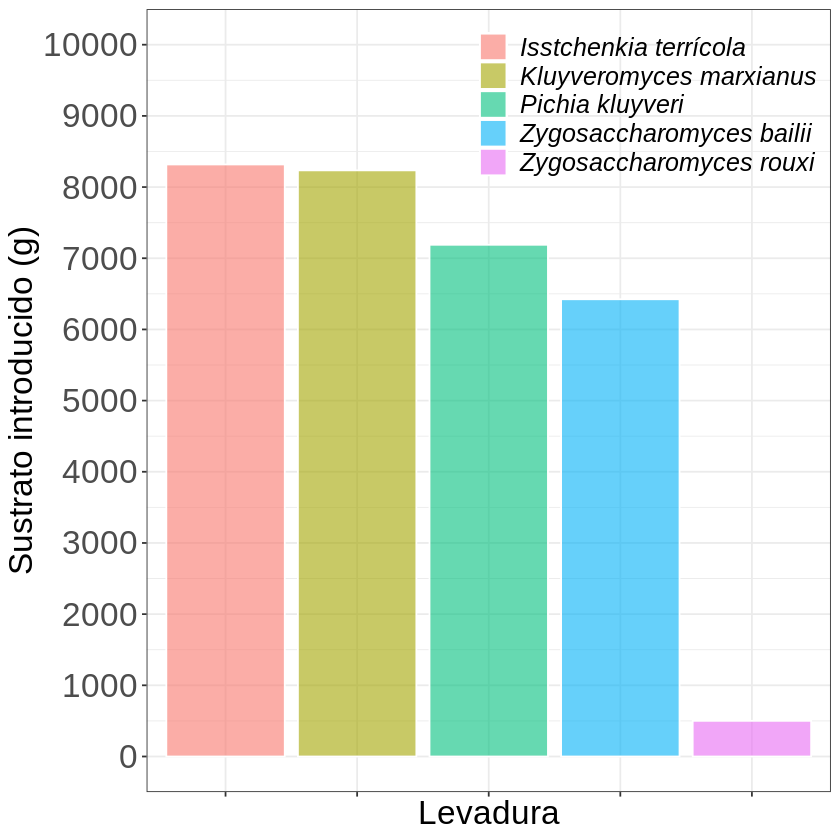

In [141]:
ggplot(data=data_ms, aes(x=lev, y=ms, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Sustrato introducido (g)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  scale_y_continuous(limits = c(0, 10000), breaks = seq(0, 10000, 1000)) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x = element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            